In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools
import json

### Intro
Dans ce notebook, j'ai cherché à visualiser la répartition de la réutilisation des process dans snakemake pour trois métriques : "tools", "levenshtein" n-gram. 
* "tools" considère qu'un processus p2 est réutilisé si il a le même ensemble d'outils qu'un autre processus p1. quand à "levenshtein", c'est si pour p2, son score de similarité est >85% à un processus p1.
* "levenshtein" est calculée comme suit, avec d = max(len(p1),len(p2)) : l(p1,p2) = (d-levenshtein(p1,p2))/d. C'est une normalisation qui nous permet d'avoir une mesure de similarité à partir d'une mesure de distance d'édition.
é
Pour obtenir les groupes de process similaires avec levenshtein, nous avons forcé la transitivité si l(p1,p2)>85% et l(p2,p3)>85%, p1,p2 et p3 sont dans le même groupe.
Ces calculs ont été effectués sur une base de processus snakemake contenant au moins un outil.
Ces calculs ont été effectués dans d'autres scripts : ils sont longs à effectuer (>3j pour 6500 process snk).

In [25]:
def importing_json_files(file_wf):
    f_wf = open(file_wf) #informations for nf
    # returns JSON object as
    # a dictionary
    wf = json.load(f_wf)
    f_wf.close
    return wf

#importing the wf and auth dict (github info)
dict_nf = importing_json_files('../json/wf_new_crawl_nextflow.json')
auth_nf = importing_json_files('../json/author_clem_nf.json')
dict_snk = importing_json_files('../json/wf_crawl_snakemake.json')
auth_snk = importing_json_files('../json/author_clem_snk.json')


In [120]:
#importing the similarity groups df

#Snakemake

df_snk = pd.read_csv("../csv/df_groups_snk.csv")
df_snk_lev = pd.read_csv("../csv/sim_snk_lev.csv")
df_snk_lev_wf = pd.read_csv("../csv/sim_snk_lev_wf.csv")
df_snk_ngram = pd.read_csv("../csv/sim_snk_ngram.csv")
df_snk_ngram_wf = pd.read_csv("../csv/sim_snk_ngram_wf.csv")

#Nextflow
df_nf = pd.read_csv("../csv/df_groups_nf.csv")
df_nf_lev = pd.read_csv("../csv/sim_nf_lev.csv")
df_nf_lev_wf = pd.read_csv("../csv/sim_nf_lev_wf.csv")
df_nf_ngram = pd.read_csv("../csv/sim_nf_ngram.csv")
df_nf_ngram_wf = pd.read_csv("../csv/sim_nf_ngram_wf.csv")

#Nf-core

df_nf_lev_non_nfc = pd.read_csv("../csv/sim_nf_lev_non_nfc.csv")
df_nf_lev_non_nfc_wf = pd.read_csv("../csv/sim_nf_lev_non_nfc_wf.csv")
df_nf_non_nfc_ngram = pd.read_csv("../csv/sim_nf_ngram_non_nfc.csv")
df_nf_non_nfc_ngram_wf = pd.read_csv("../csv/sim_nf_ngram_non_nfc_wf.csv")
df_nf_lev_nfc = pd.read_csv("../csv/sim_nf_lev_nfc.csv")
df_nf_lev_nfc_wf = pd.read_csv("../csv/sim_nf_lev_nfc_wf.csv")
df_nf_nfc_ngram = pd.read_csv("../csv/sim_nf_ngram_nfc.csv")
df_nf_nfc_ngram_wf = pd.read_csv("../csv/sim_nf_ngram_nfc_wf.csv")

### Réutilisation des process

Regardons la répartition de la réutilisation des process selon les différentes métriques :
- fréquence de réutilisation des process (combien de process sont utilisés n fois ?)
- dans combien de workflows les process sont ils utilisés ?

Note : On calcule ces métriques sur la base complète de workflows et sur la base de workflows uniques

In [69]:
def disp_fig_props(df_tot,sys,proc):
    fig = df_tot.plot(x="nb_reuse",y=["prop_proc_ngram","prop_proc_lev","prop_proc_tools"], kind="bar", color = ['red','green','blue'], label = ['ngram','lev','tools'])
    fig.set_xticklabels(fig.get_xticklabels(), rotation=80, size=5)
    fig.set_xlabel("Number of times used with the metric 'levenshtein' and the metric 'tools' in "+sys)
    fig.set_ylabel('Percent of '+proc)
    fig.legend(loc='best')
    fig.set_yscale('log')
    plt.show()
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return fig

In [124]:
def disp_fig_props_wf(df_tot,sys):
    fig = df_tot.plot(x="nb_wf",y=["prop_proc_ngram","prop_proc_lev","prop_proc_tools"], kind="bar", color = ['red','green','blue'], label = ['ngram','lev','tools'])
    fig.set_xticklabels(fig.get_xticklabels(), rotation=80, size=5)
    fig.set_xlabel("Number of wf used in with the metric 'levenshtein', 'tools' and 'ngram' in "+sys)
    fig.set_ylabel('Nb of workflows')
    fig.legend(loc='best')
    #fig.set_yscale('log')
    plt.show()
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return fig

In [100]:
def disp_single_metric(df,metric,sys,name):
    df=df.sort_values(by=[metric])
    fig2 = df.plot(x=metric,y="prop_proc", kind="bar", color = 'green', label = name)
    fig2.set_xticklabels(fig2.get_xticklabels(), rotation=80, size=5)
    fig2.set_xlabel("""Number of times used with the metric """+ name +"""' in """+sys)
    fig2.set_ylabel('Percent of processors')
    fig2.legend(loc='best')
    #fig2.set_yscale('log'
    plt.show()
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return fig2

In [114]:
def display_fig_stats_metric(df_sim_lev,sys,metric):
    ax = df_sim_lev.sort_values(by=["nb_reuse"], ascending = False).plot(x='Unnamed: 0', y="nb_reuse", kind="bar", label = "times used "+metric, color = "red")
    ax.set_title("Usage count of processors for metric "+ metric+ " for "+sys) 
    plt.xticks([])
    #ax.set_xticklabels(l, rotation=80, size=5)
    ax.set_xlabel("Distinct processors")
    ax.set_ylabel("Nb of times used")
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500


In [106]:
def display_fig_stats_process(df_sim, df_sim_p,df_sim_m, nb_proc, sys):
    df_sim_s = df_sim.sort_values(by=["nb_reuse"], ascending = False).head(nb_proc)
    df_sim_l = df_sim_p.sort_values(by=["nb_reuse"], ascending = False).head(nb_proc)
    df_sim_t = df_sim_m.sort_values(by=["nb_reuse"], ascending = False).head(nb_proc)
    ax = df_sim_s.plot(x='Unnamed: 0', y="nb_reuse", kind="bar", label = "times used tool", color = "orange")
    df_sim_t.plot(x='Unnamed: 0', y="nb_reuse", ax=ax ,  kind="bar", color = "yellow", label = "times used ngram")
    df_sim_l.plot(x='Unnamed: 0', y="nb_reuse", ax=ax ,  kind="bar", color = "red", label = "times used levenshtein")
    ax.set_title('Usage count of the '+str(nb_proc)+' most used processors for metrics tools, levenshtein and ngram in '+sys) 
    plt.xticks([])
    ax.set_yscale('log')
    #ax.set_xticklabels(l, rotation=80, size=5)
    ax.set_xlabel("Distinct processors")
    ax.set_ylabel("Nb of times used")
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return ax

In [133]:
def make_df_tot(df_ngram,df_lev,df_tools,metric):
    df_lev["prop_proc_lev"]=df_lev["prop_proc"]
    df_ngram["prop_proc_ngram"]=df_ngram["prop_proc"]
    df_tools["prop_proc_tools"]=df_tools["prop_proc"]
    df_tot = pd.merge(df_ngram[[metric,"prop_proc_ngram"]], df_tools[[metric,"prop_proc_tools"]],on=metric,how="outer")
    df_tot = pd.merge(df_lev[[metric,"prop_proc_lev"]], df_tot[[metric,"prop_proc_tools","prop_proc_ngram"]],on=metric,how="outer") 
    
    df_tot = df_tot.fillna(0)
    df_tot=df_tot.sort_values(by=[metric], ascending=True)
    return df_tot

In [57]:
df_snk_ngram.head()

Unnamed: 0  nb_reuse  nb_proc  prop_proc  nb_own   prop_own   nb_wf  \
0           0       1.0   2513.0  75.104603  2534.0  75.732218  2520.0   
1           1       2.0    413.0  12.343096   543.0  16.228332   474.0   
2           2       3.0    150.0   4.482965   137.0   4.094441   143.0   
3           3       4.0     97.0   2.898984    66.0   1.972504    94.0   
4           4       5.0     42.0   1.255230    25.0   0.747161    31.0   

     prop_wf  prop_proc_ngram  prop_wf_ngram  
0  75.313808        75.104603      75.313808  
1  14.166169        12.343096      14.166169  
2   4.273760         4.482965       4.273760  
3   2.809325         2.898984       2.809325  
4   0.926479         1.255230       0.926479

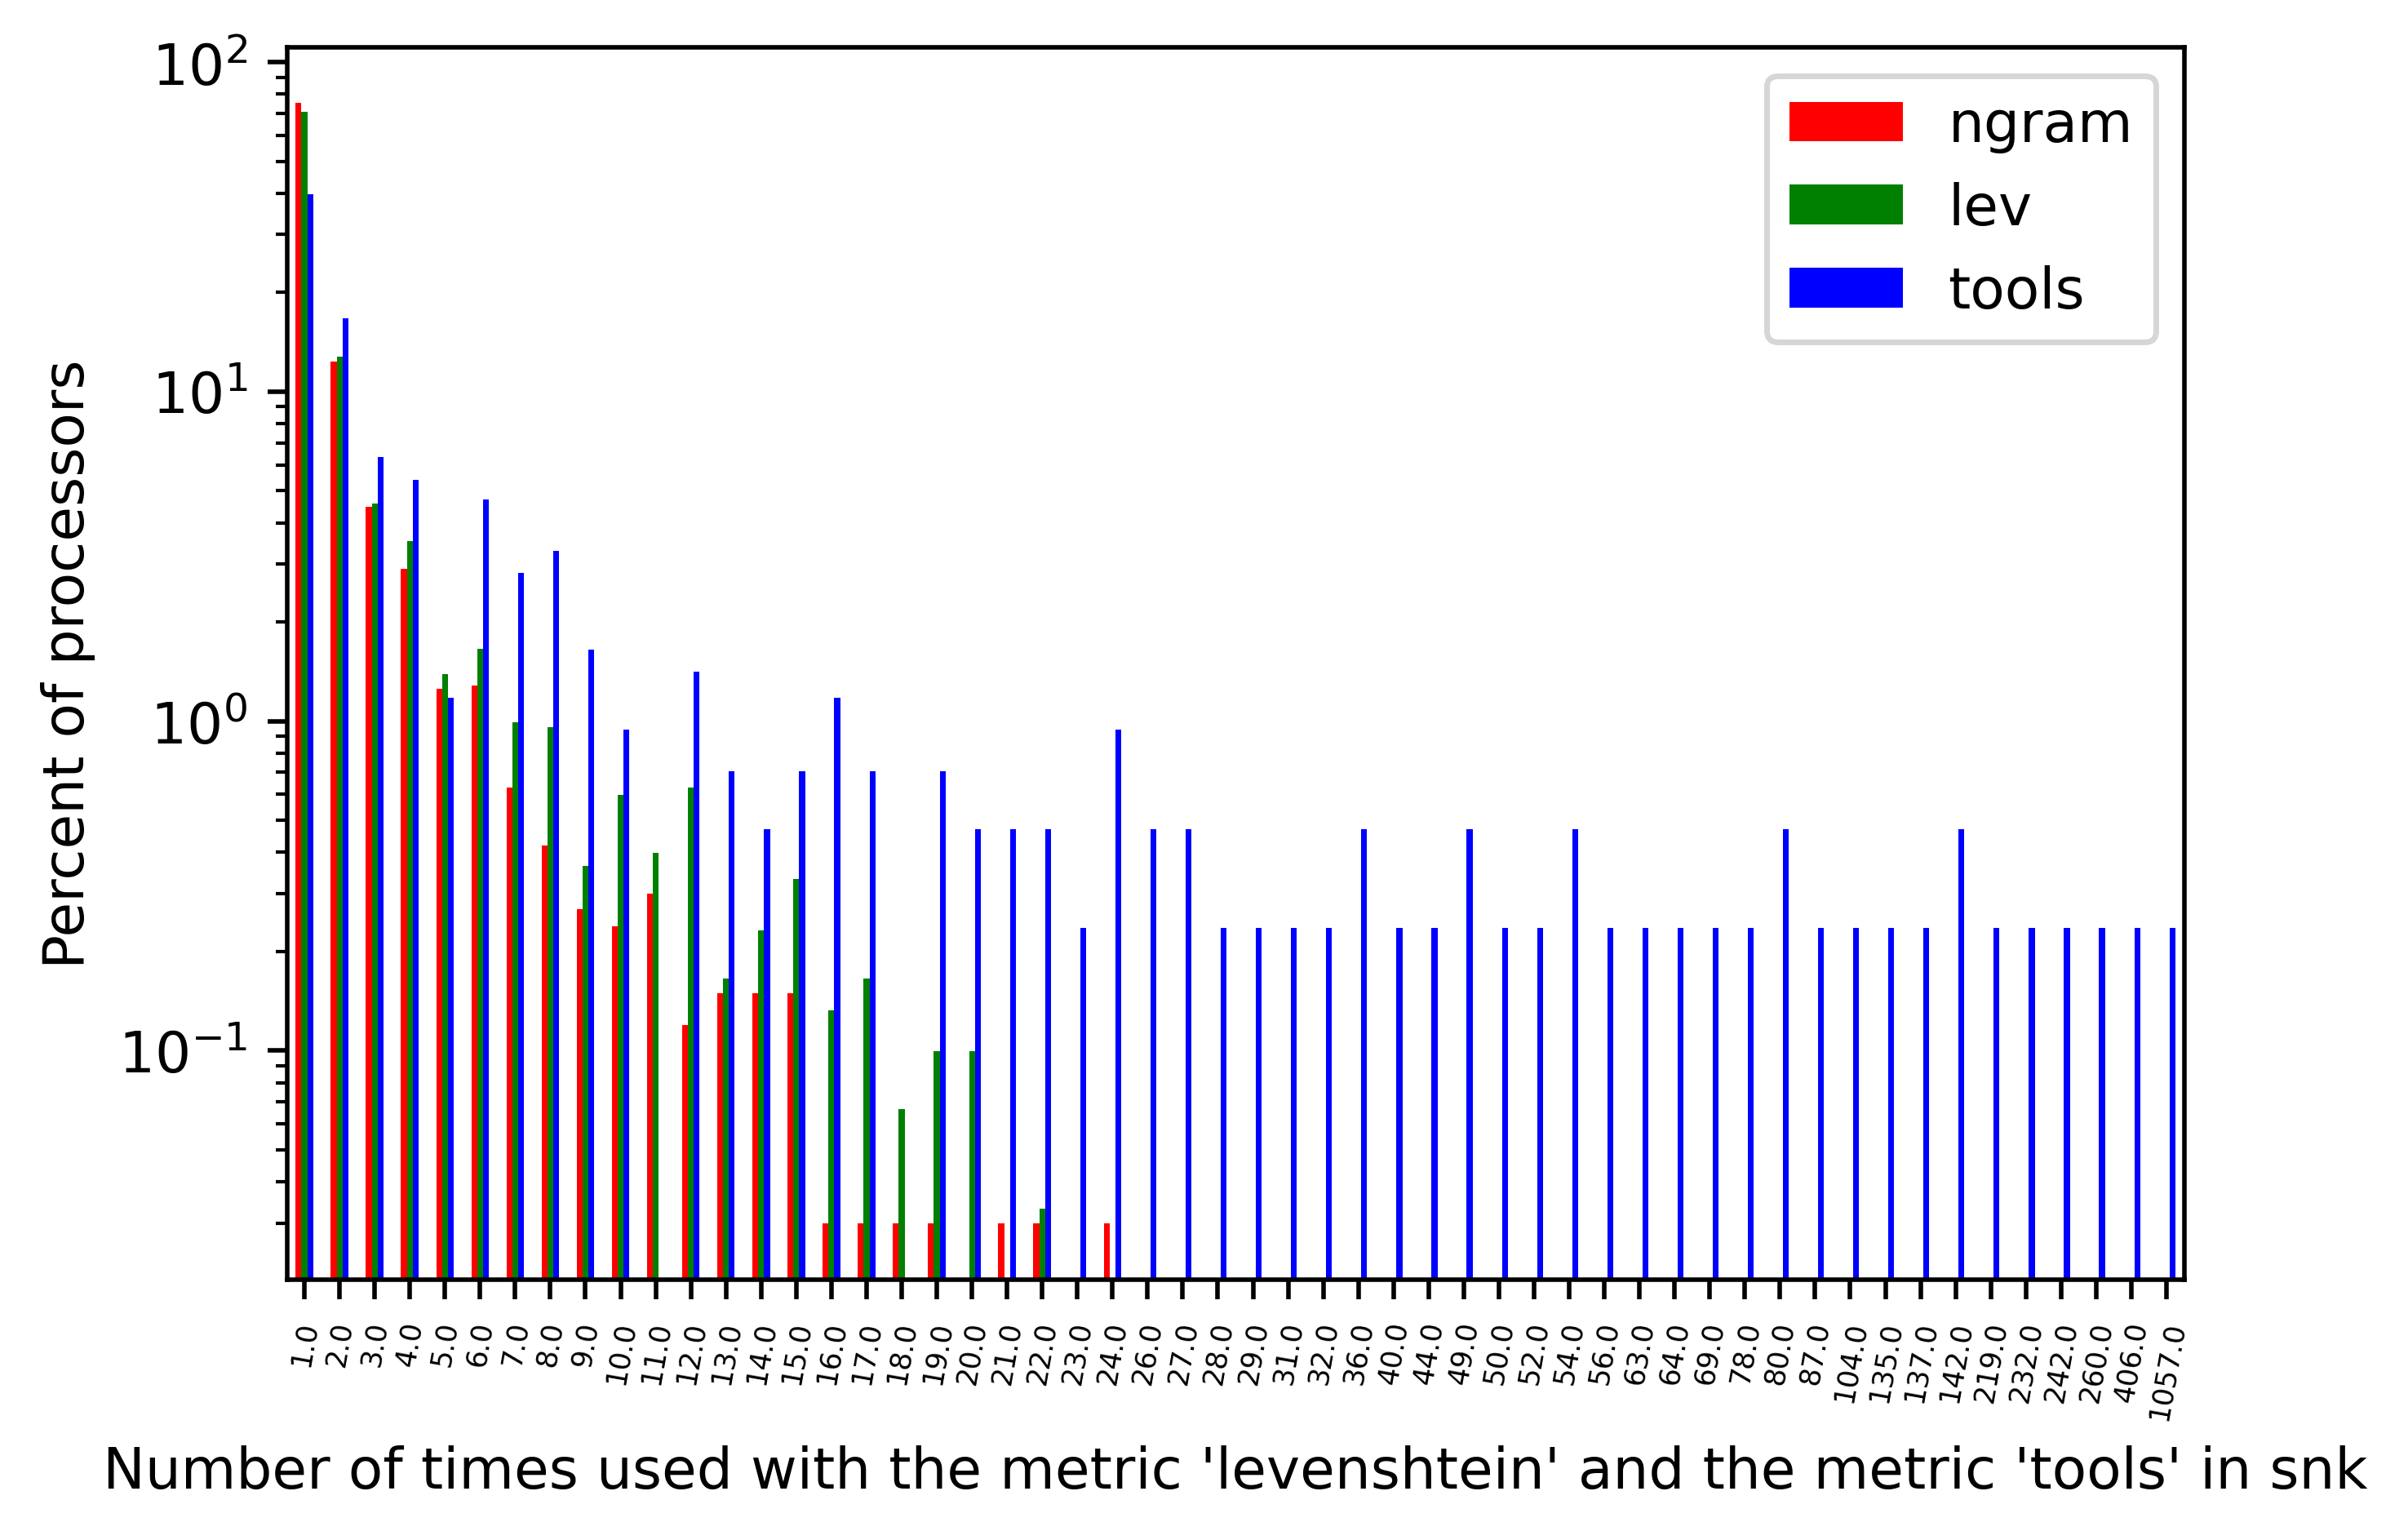

In [58]:
df_tot=make_df_tot(df_snk_ngram,df_snk_lev,df_snk,"nb_reuse")
fig_snk = disp_fig_props(df_tot,'snk',"processors")

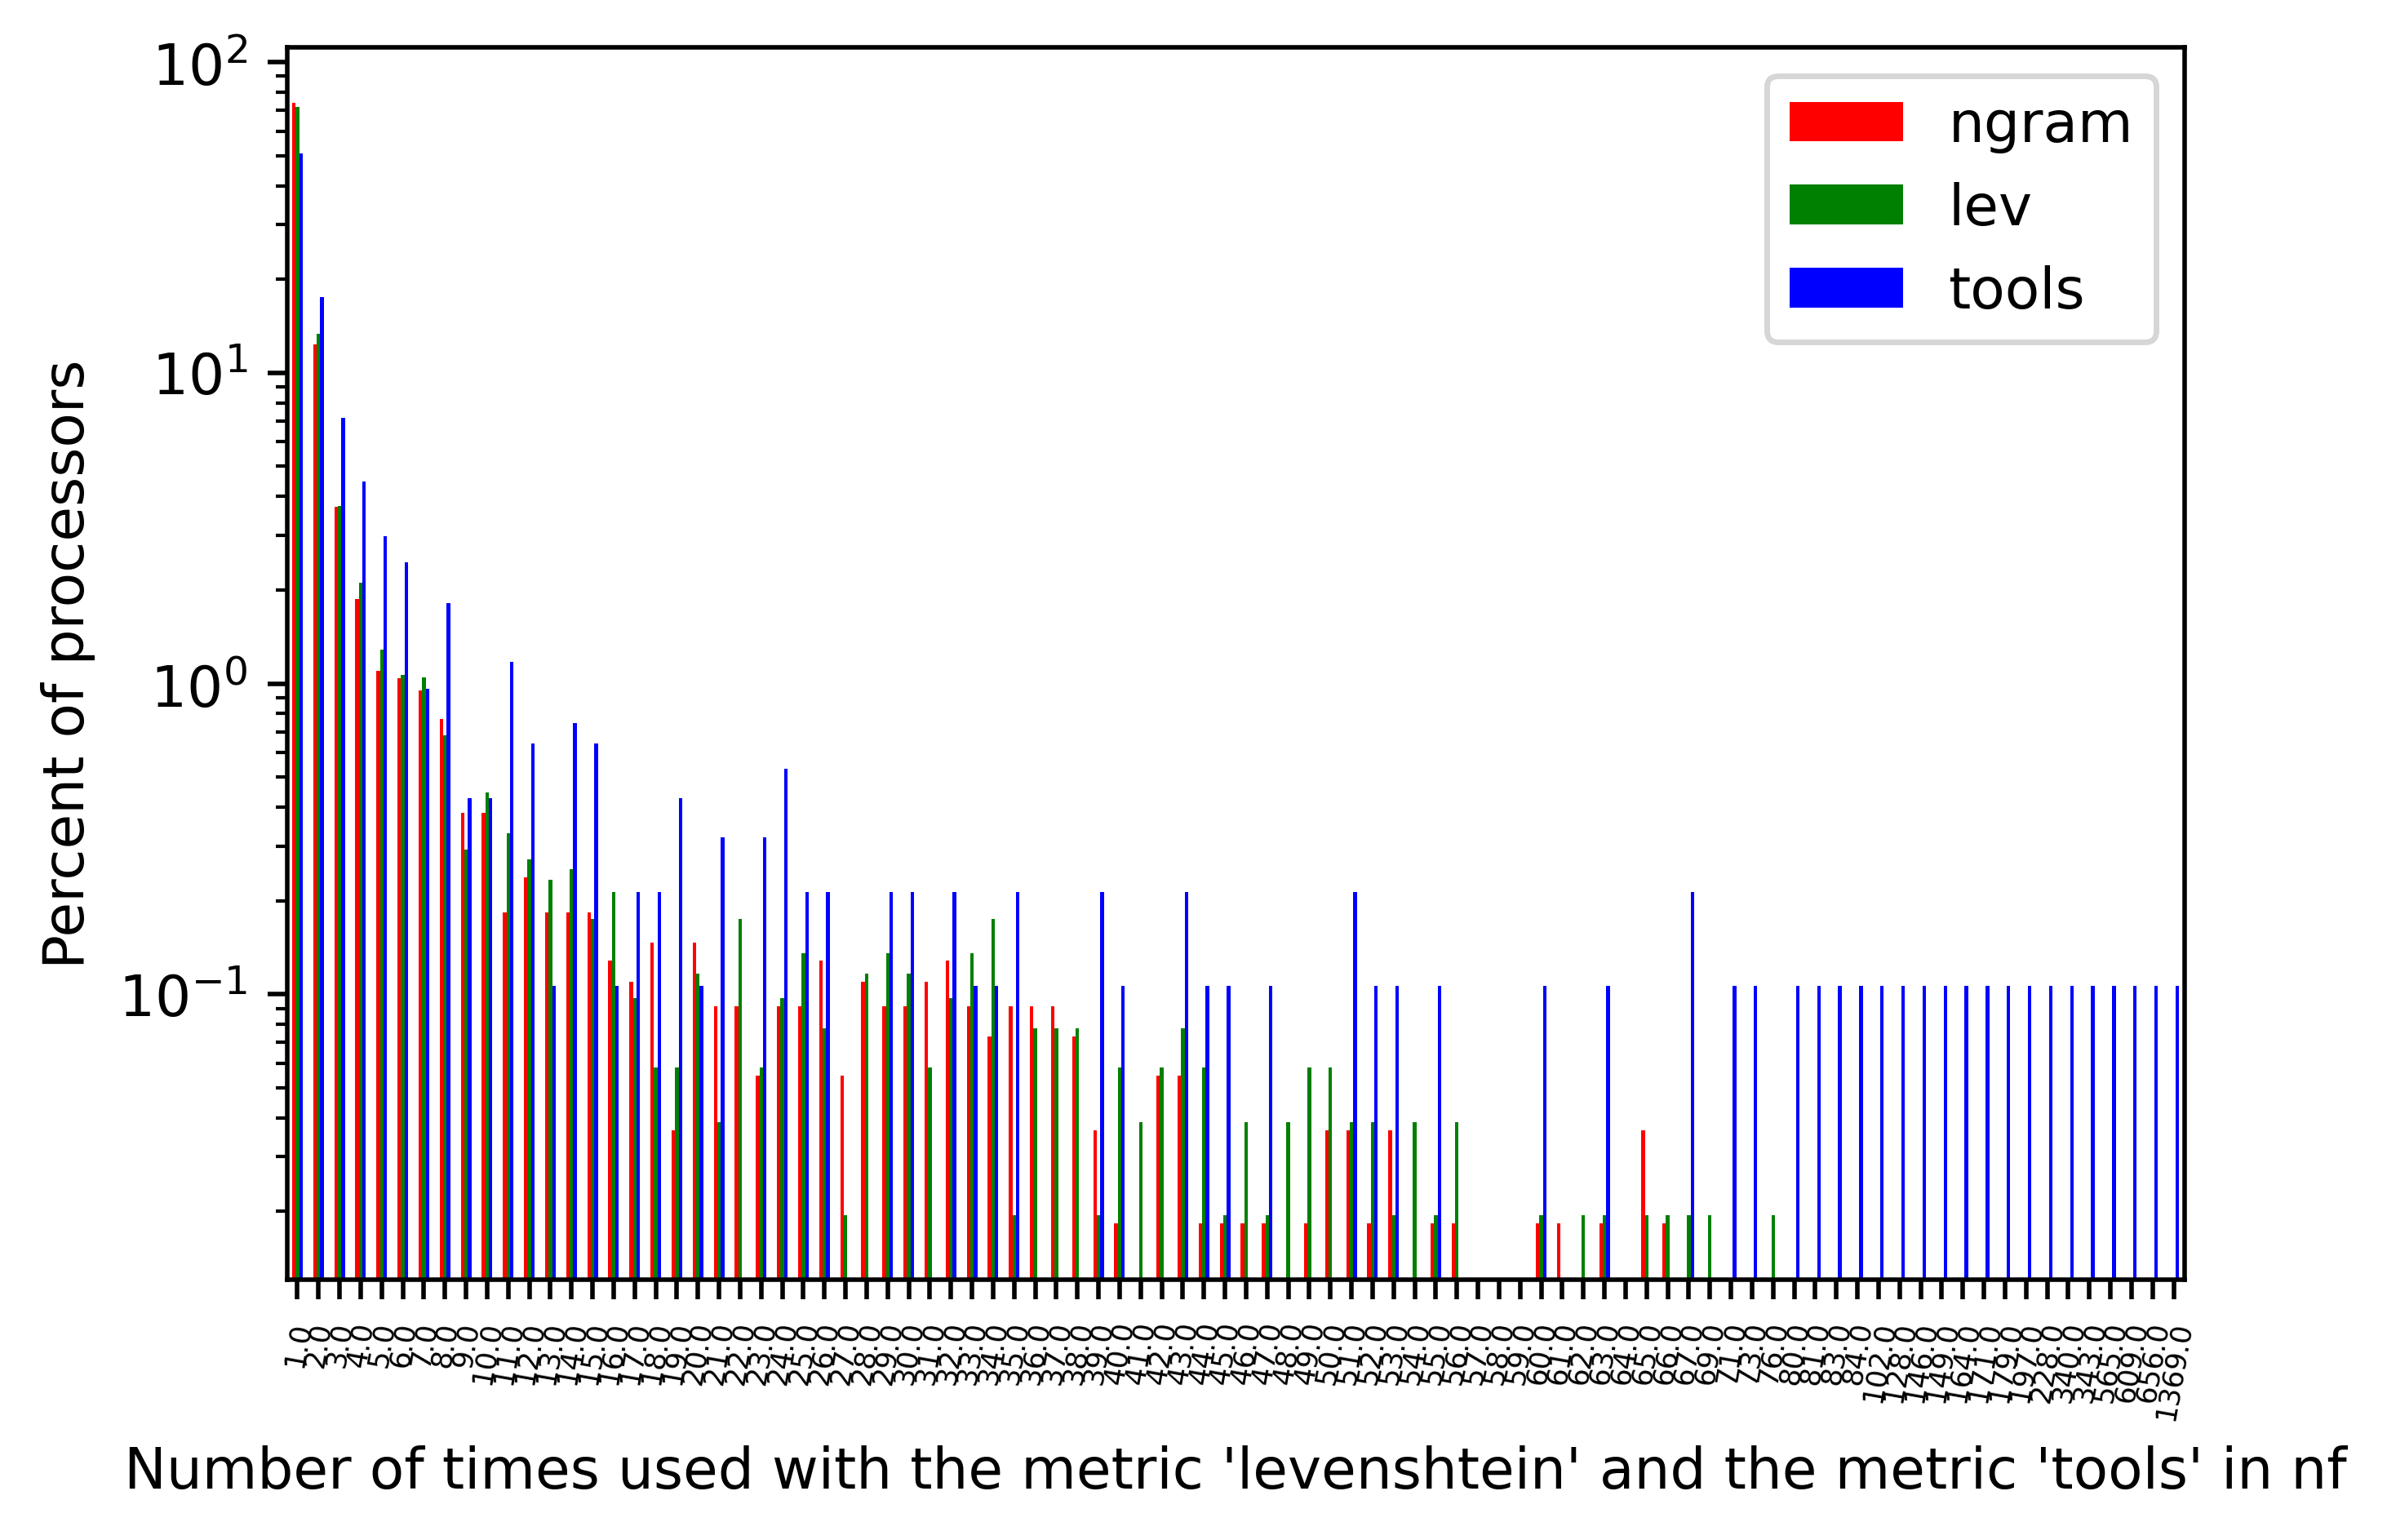

In [59]:
df_tot_nf=make_df_tot(df_nf_ngram,df_nf_lev,df_nf,"nb_reuse")
fig_snk = disp_fig_props(df_tot_nf,'nf',"processors")

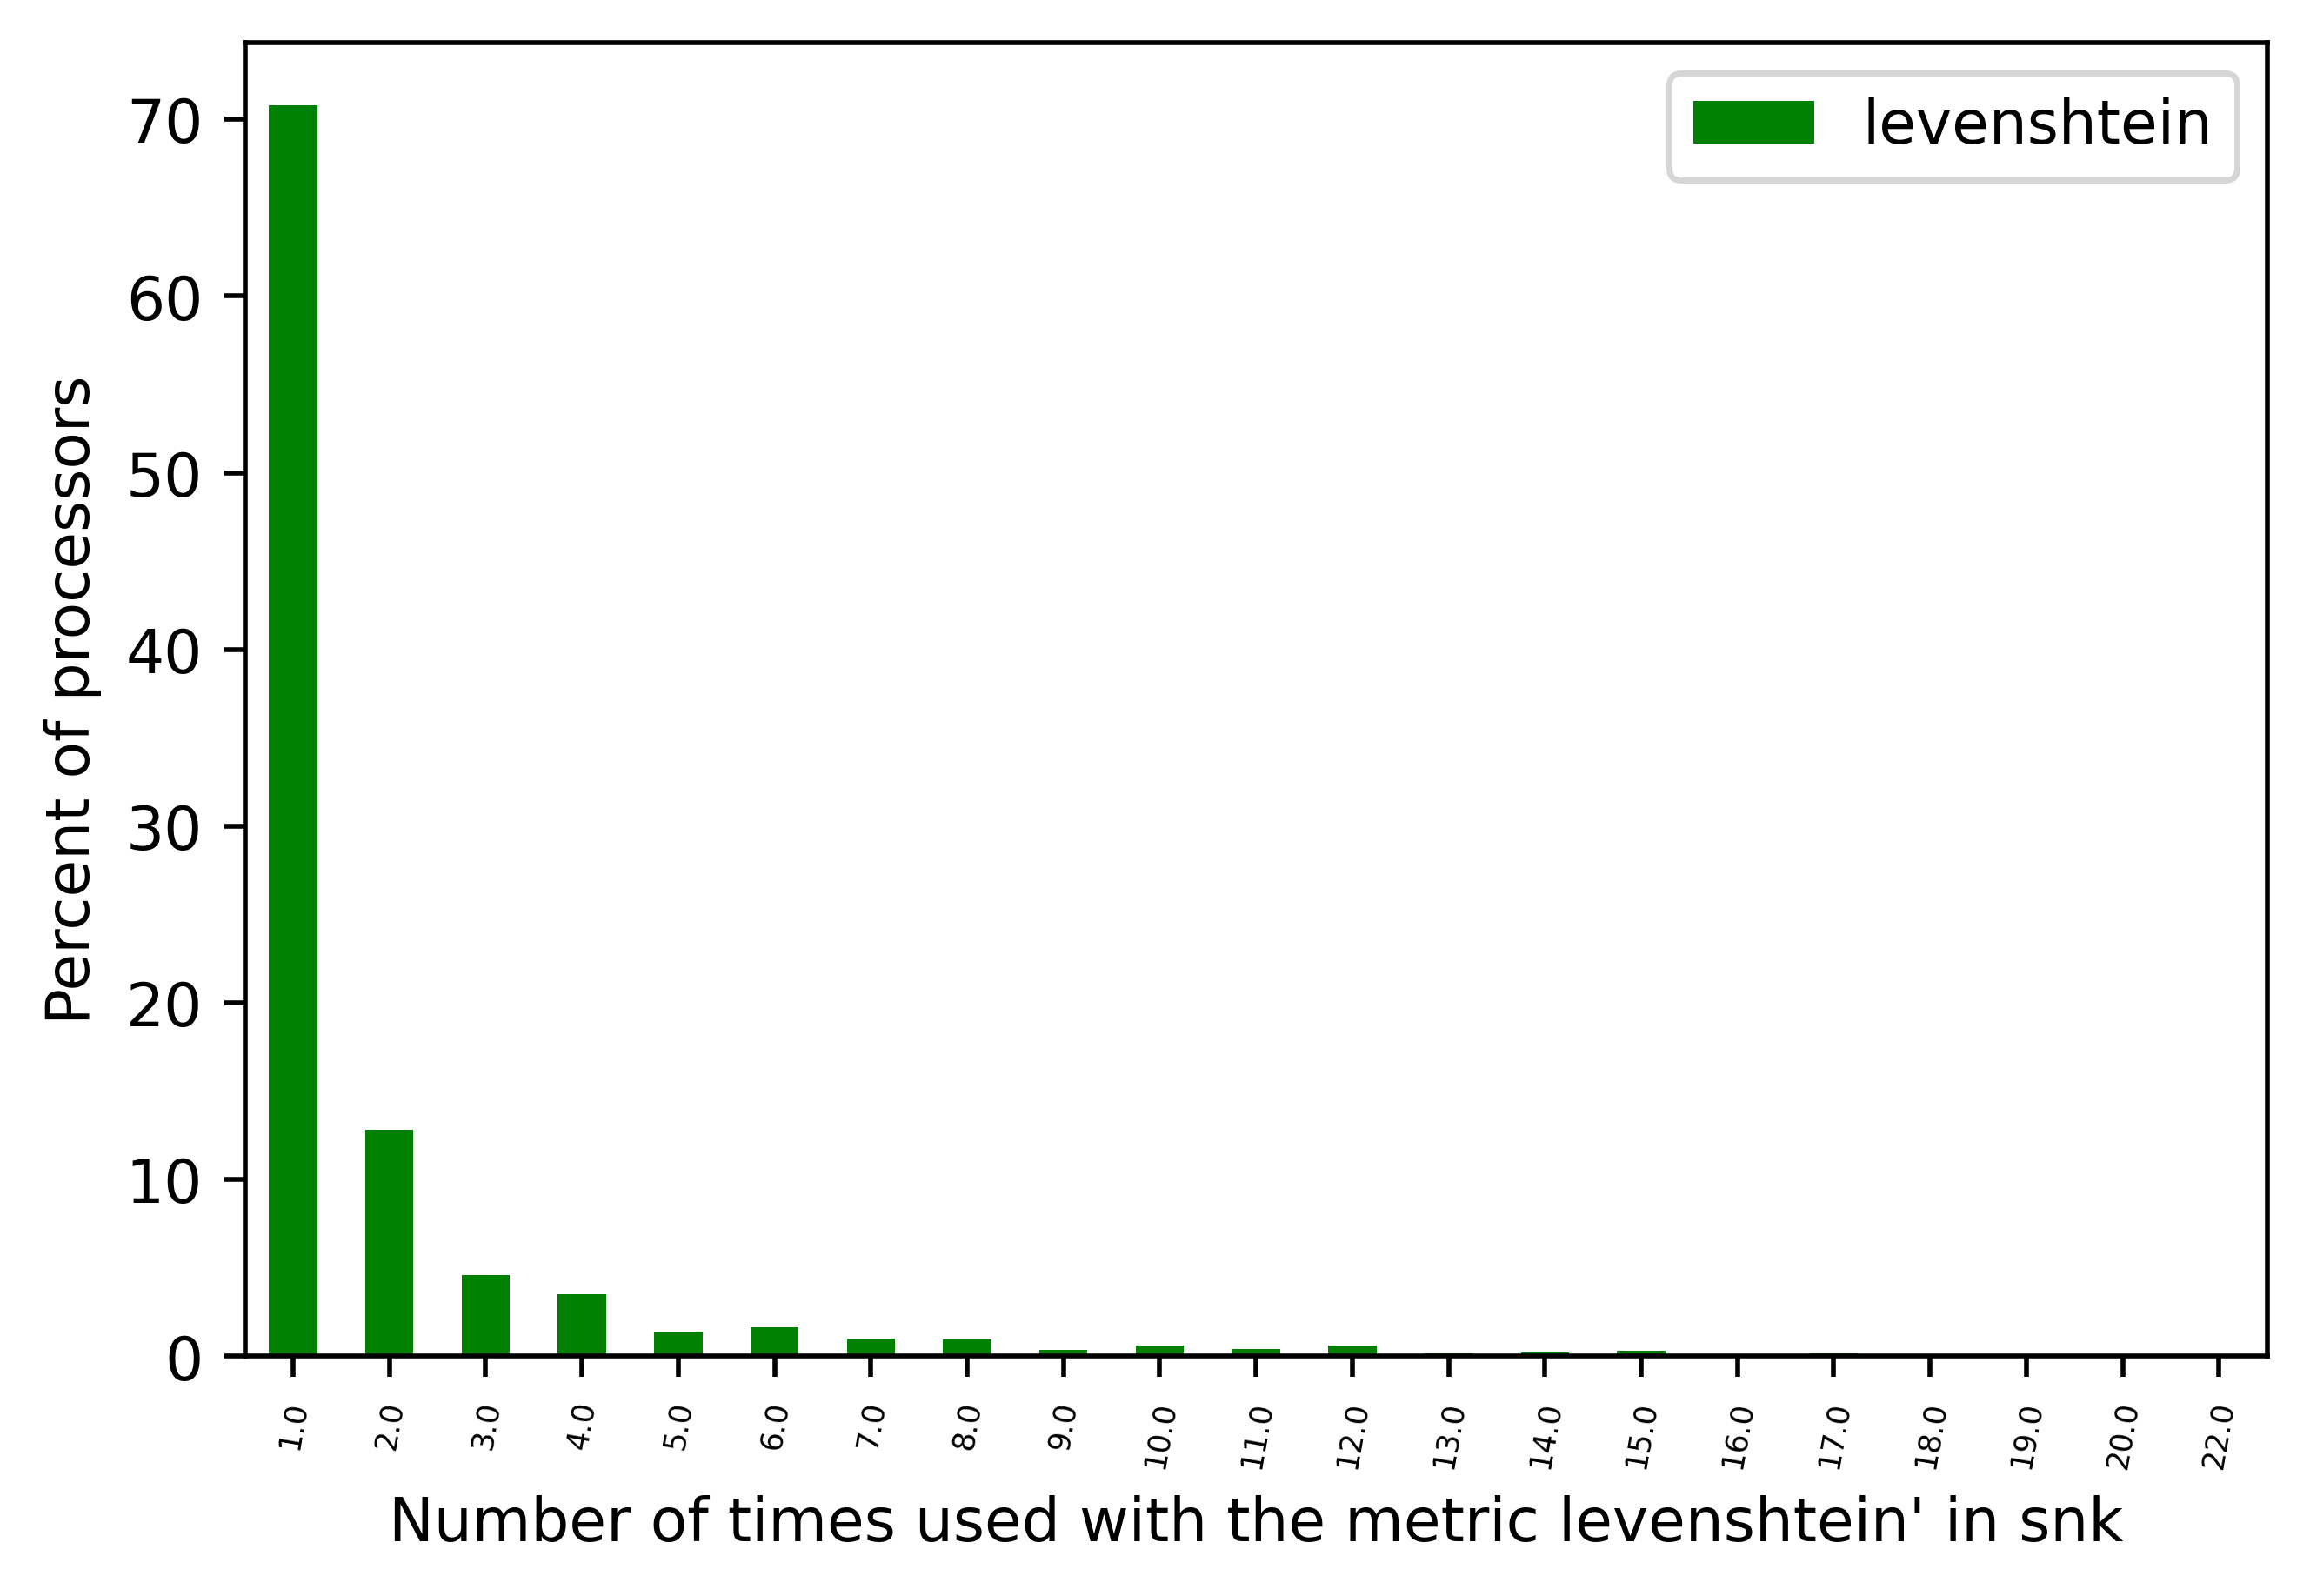

<AxesSubplot:xlabel="Number of times used with the metric levenshtein' in snk", ylabel='Percent of processors'>

In [90]:
disp_single_metric(df_snk_lev,"nb_reuse","snk","levenshtein")

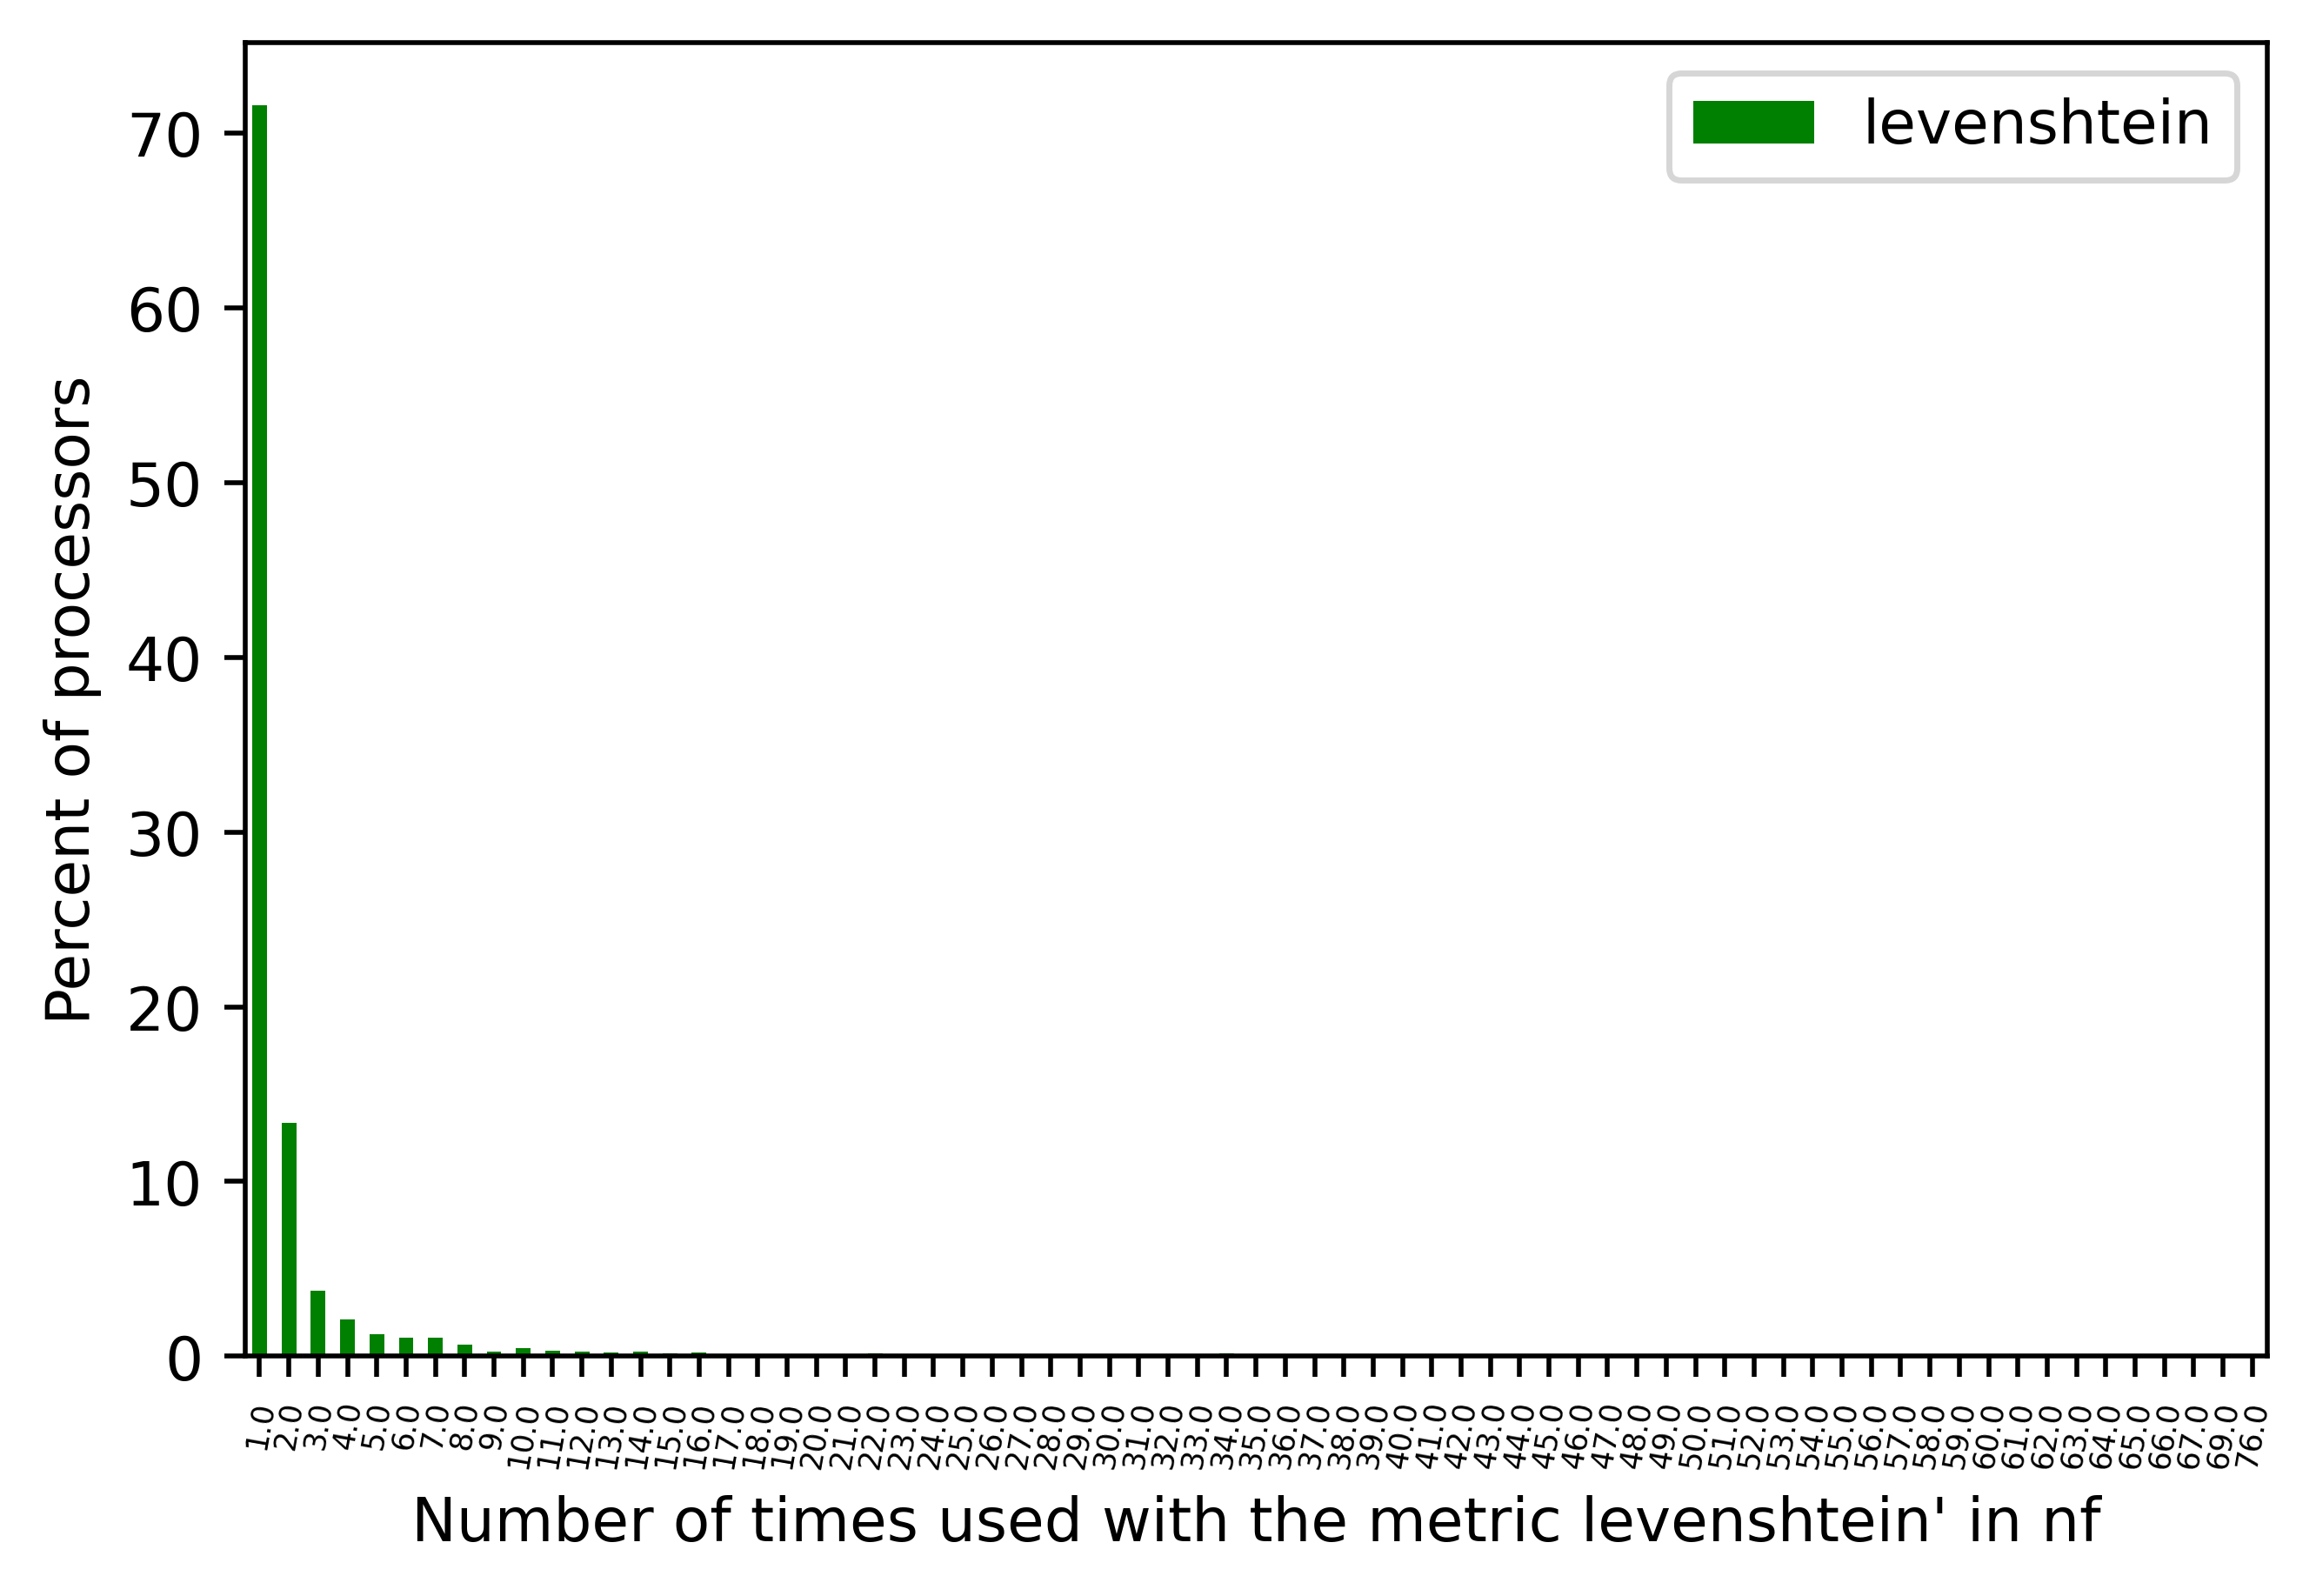

<AxesSubplot:xlabel="Number of times used with the metric levenshtein' in nf", ylabel='Percent of processors'>

In [89]:
disp_single_metric(df_nf_lev,"nb_reuse","nf","levenshtein")

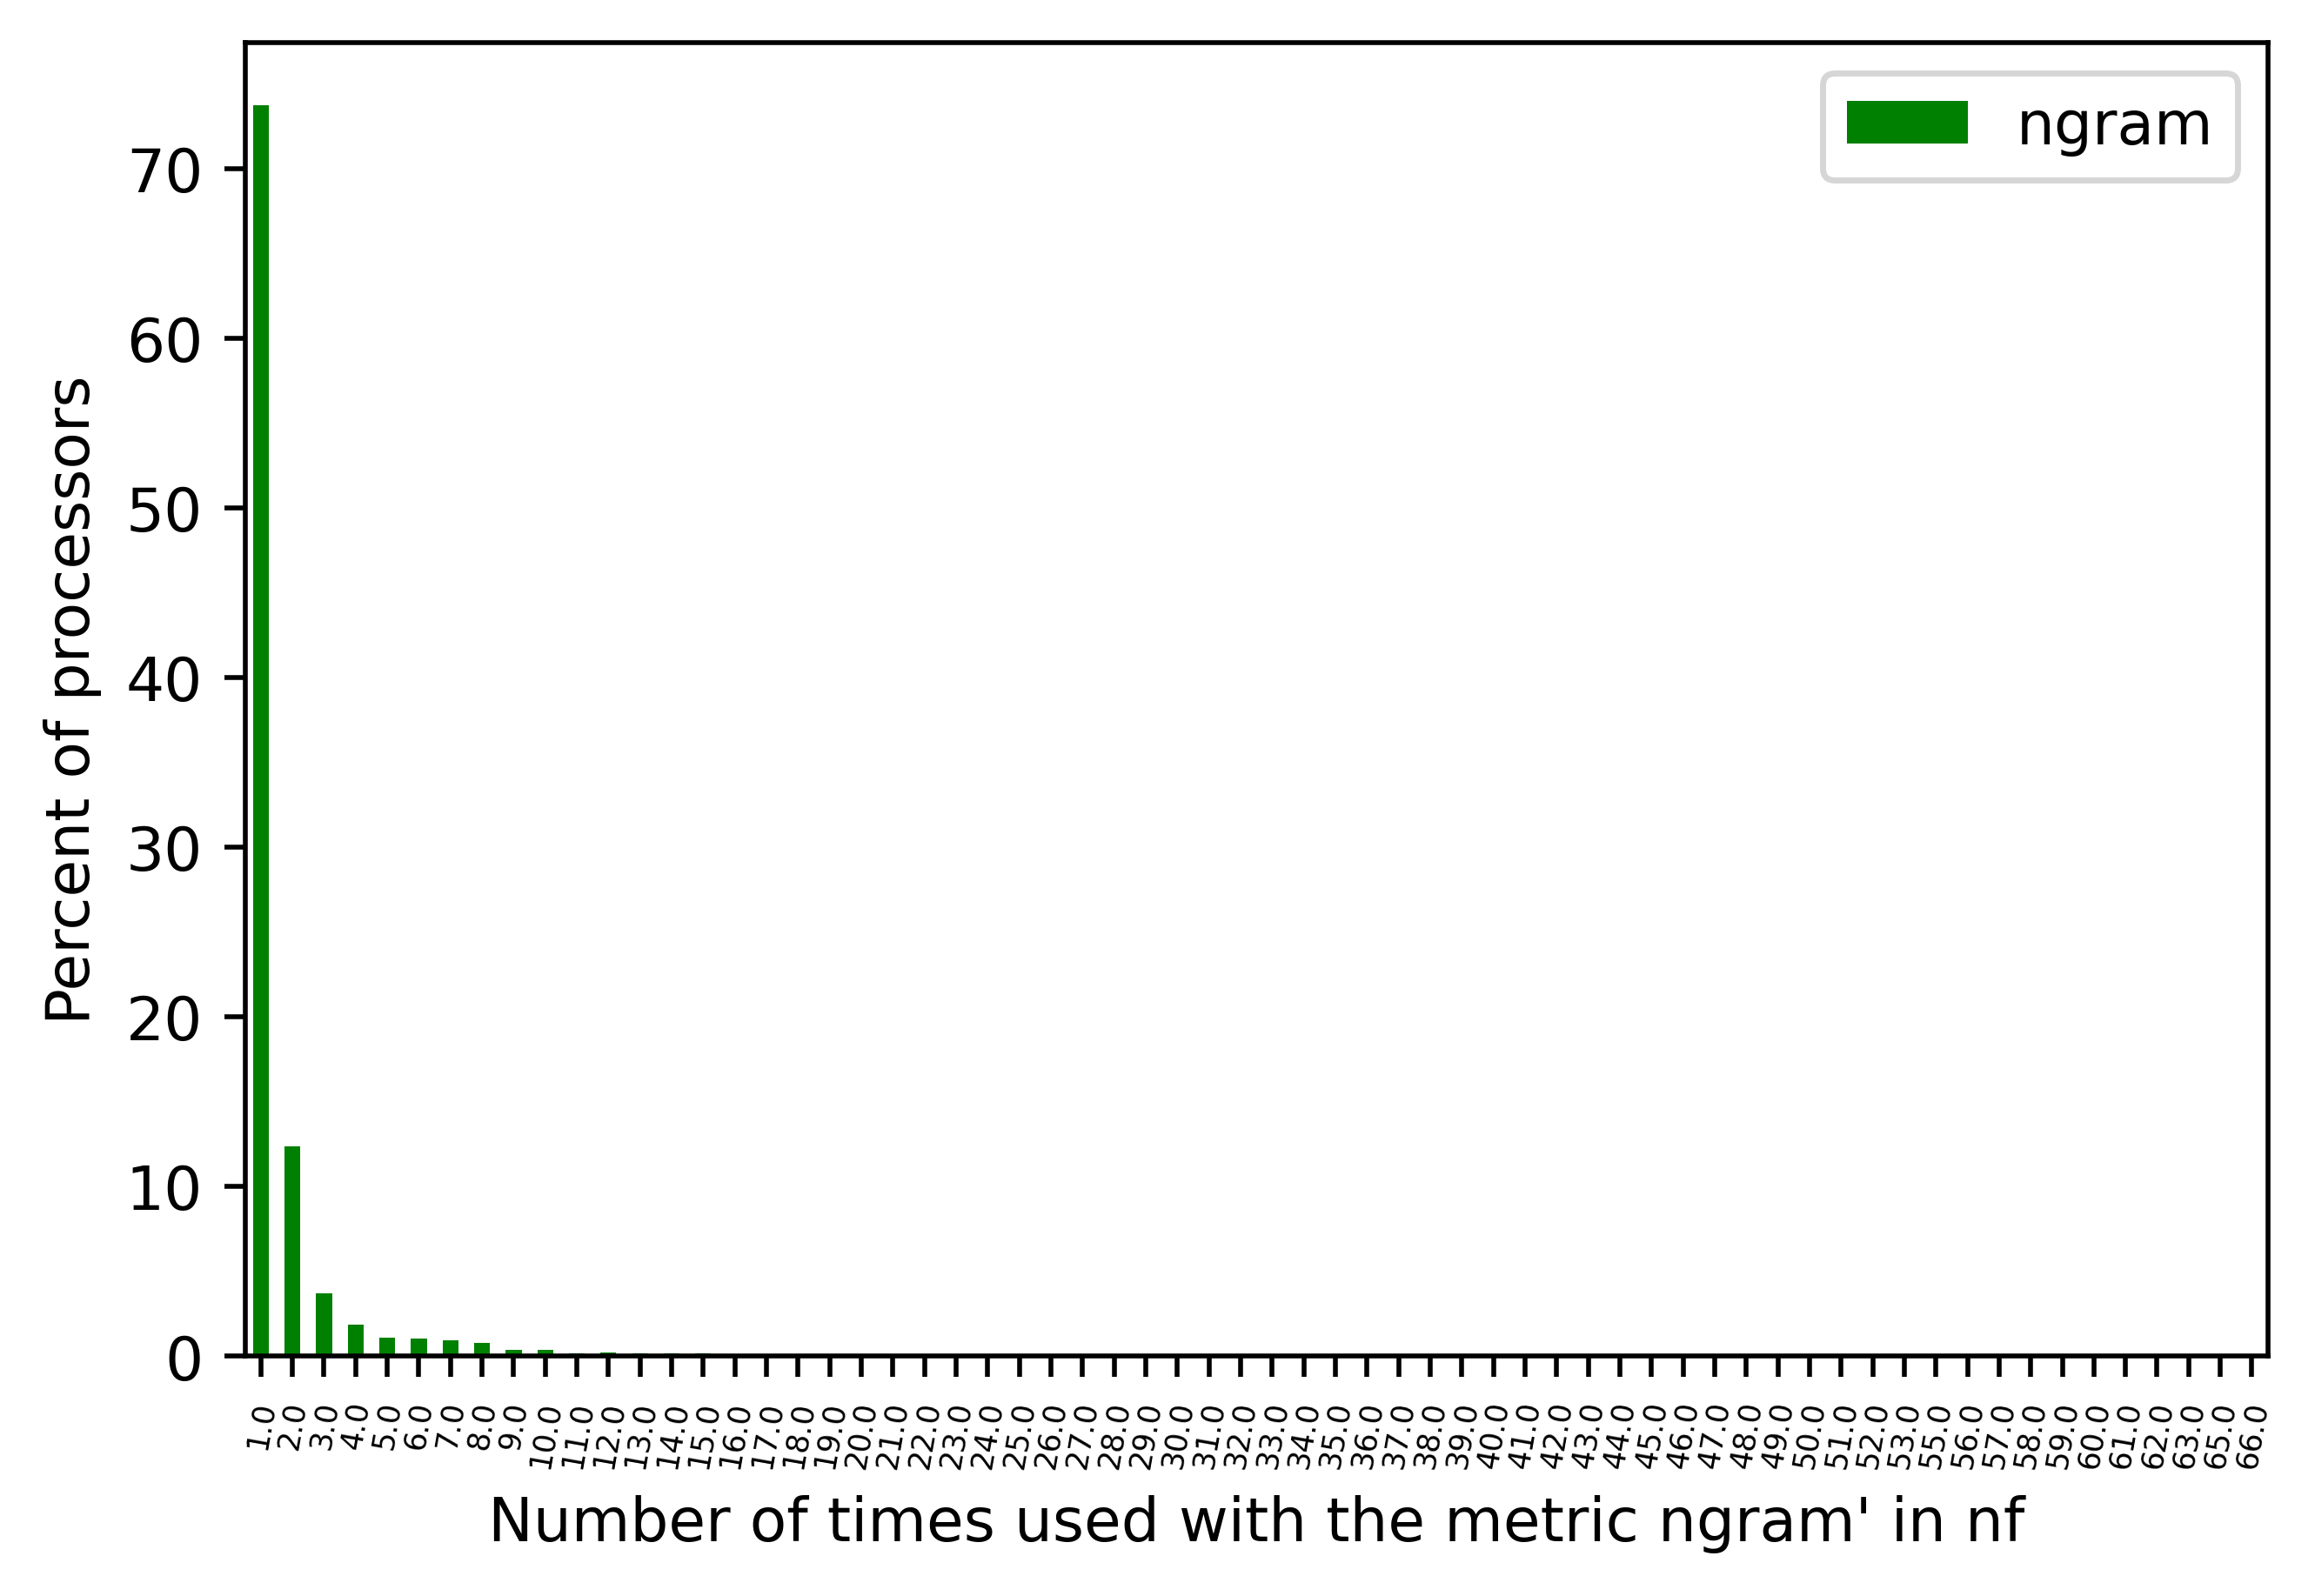

<AxesSubplot:xlabel="Number of times used with the metric ngram' in nf", ylabel='Percent of processors'>

In [67]:
disp_single_metric(df_nf_ngram,"nb_reuse","nf","ngram")

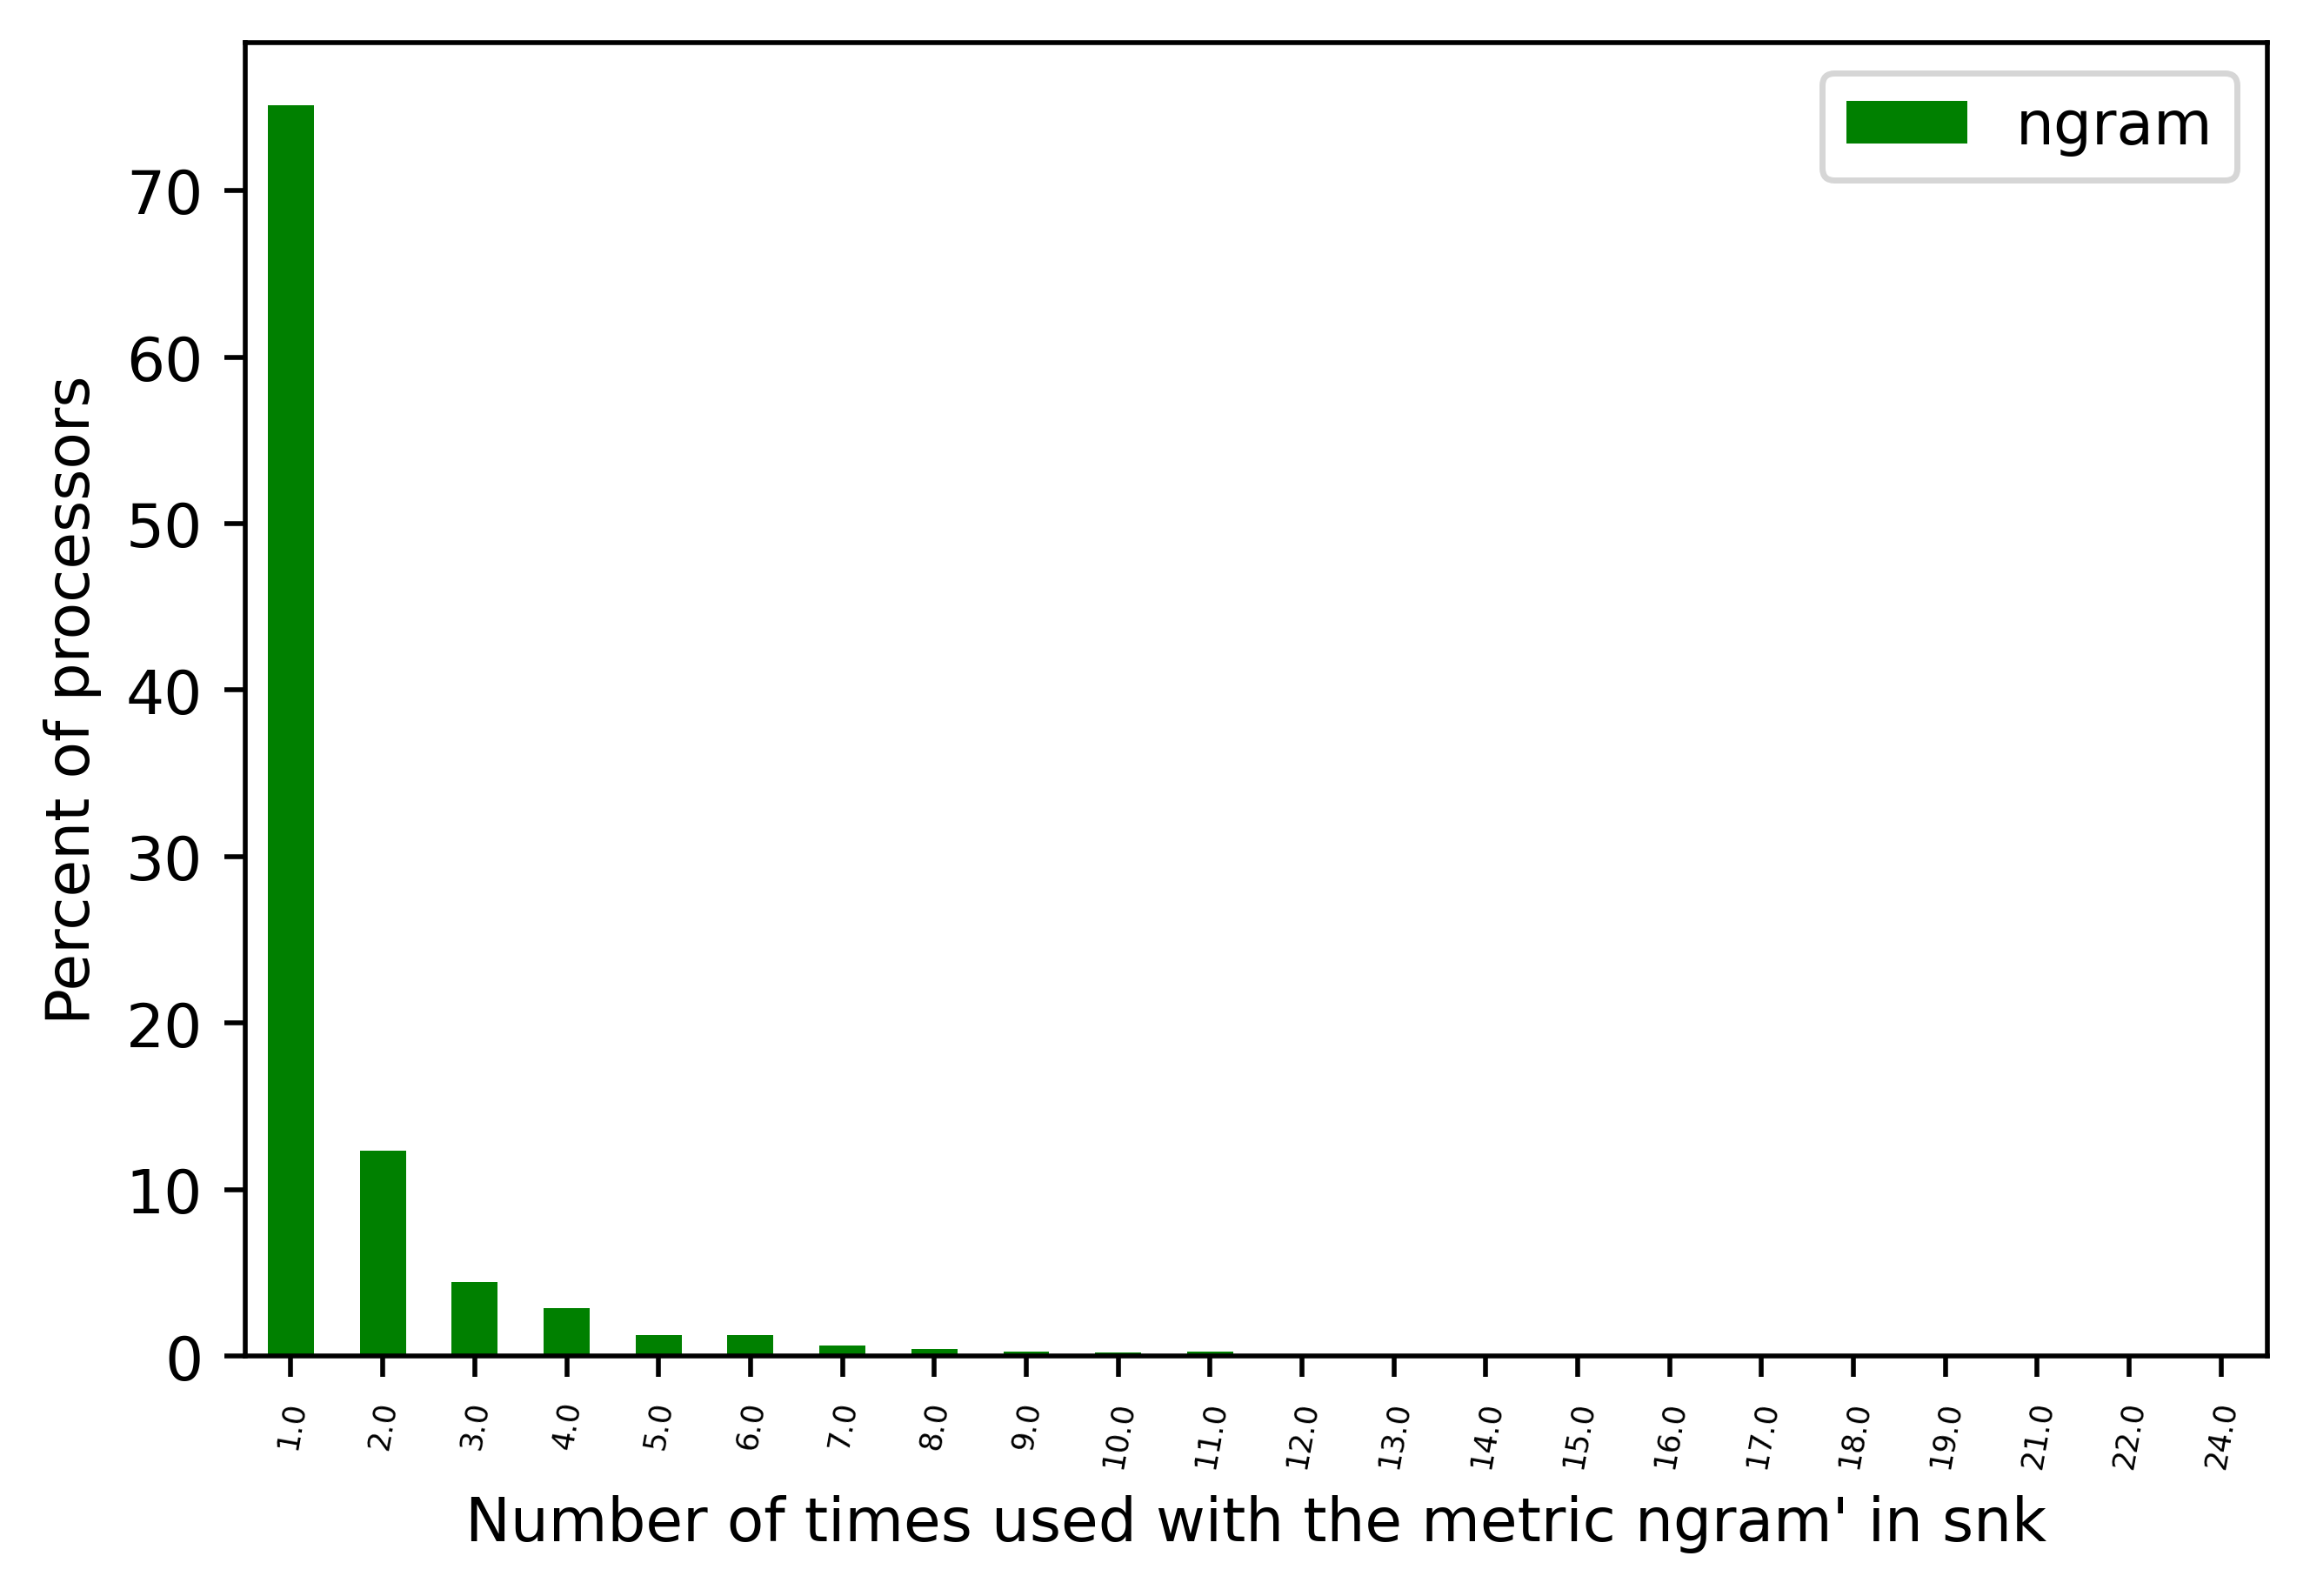

<AxesSubplot:xlabel="Number of times used with the metric ngram' in snk", ylabel='Percent of processors'>

In [68]:
disp_single_metric(df_snk_ngram,"nb_reuse","snk","ngram")

## Réutilisation des process au sein des workflows

Regardons maintenant répartition de la réutilisation des process au sein des workflows : combien de process sont réutilisés dans x workflow ?
(nb : les workflows sont considérés comme uniques)

In [129]:
df_tot_wf = make_df_tot(df_snk_ngram_wf,df_snk_lev_wf,df_snk,"nb_wf")
df_tot_nf_wf = make_df_tot(df_nf_ngram_wf,df_nf_lev_wf,df_nf,"nb_wf")

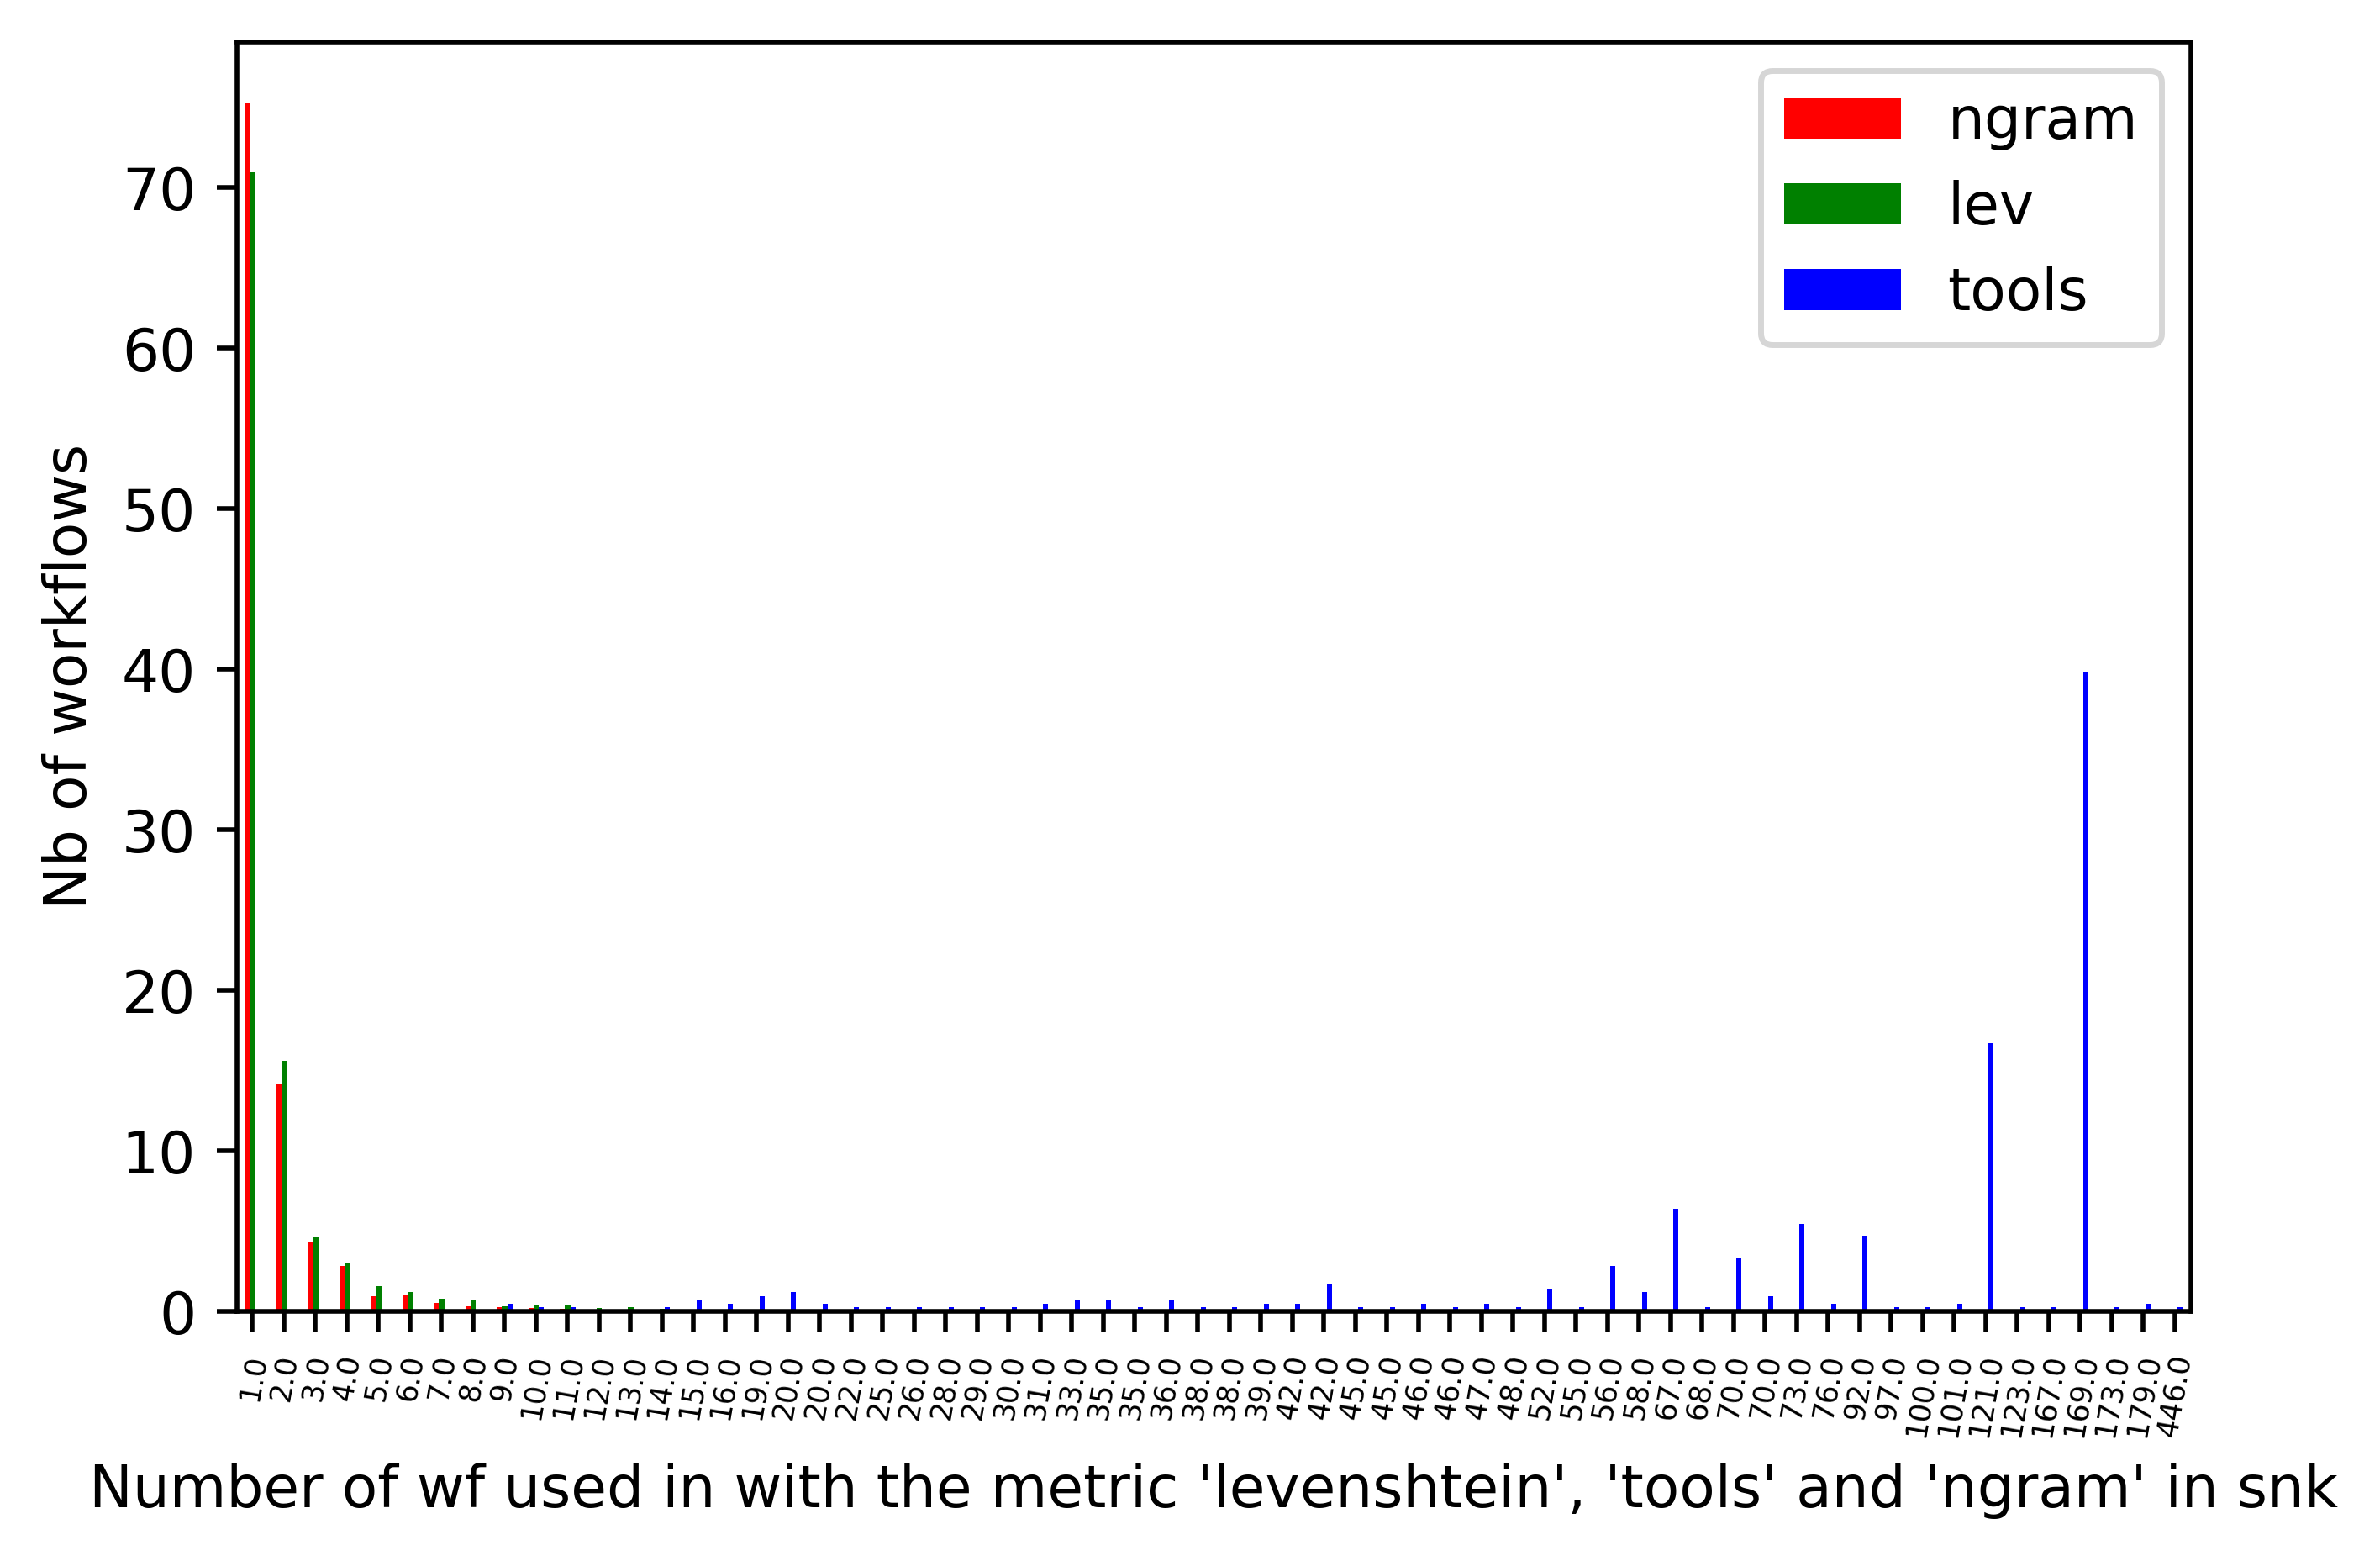

In [130]:
fig_snk_wf = disp_fig_props_wf(df_tot_wf,'snk')

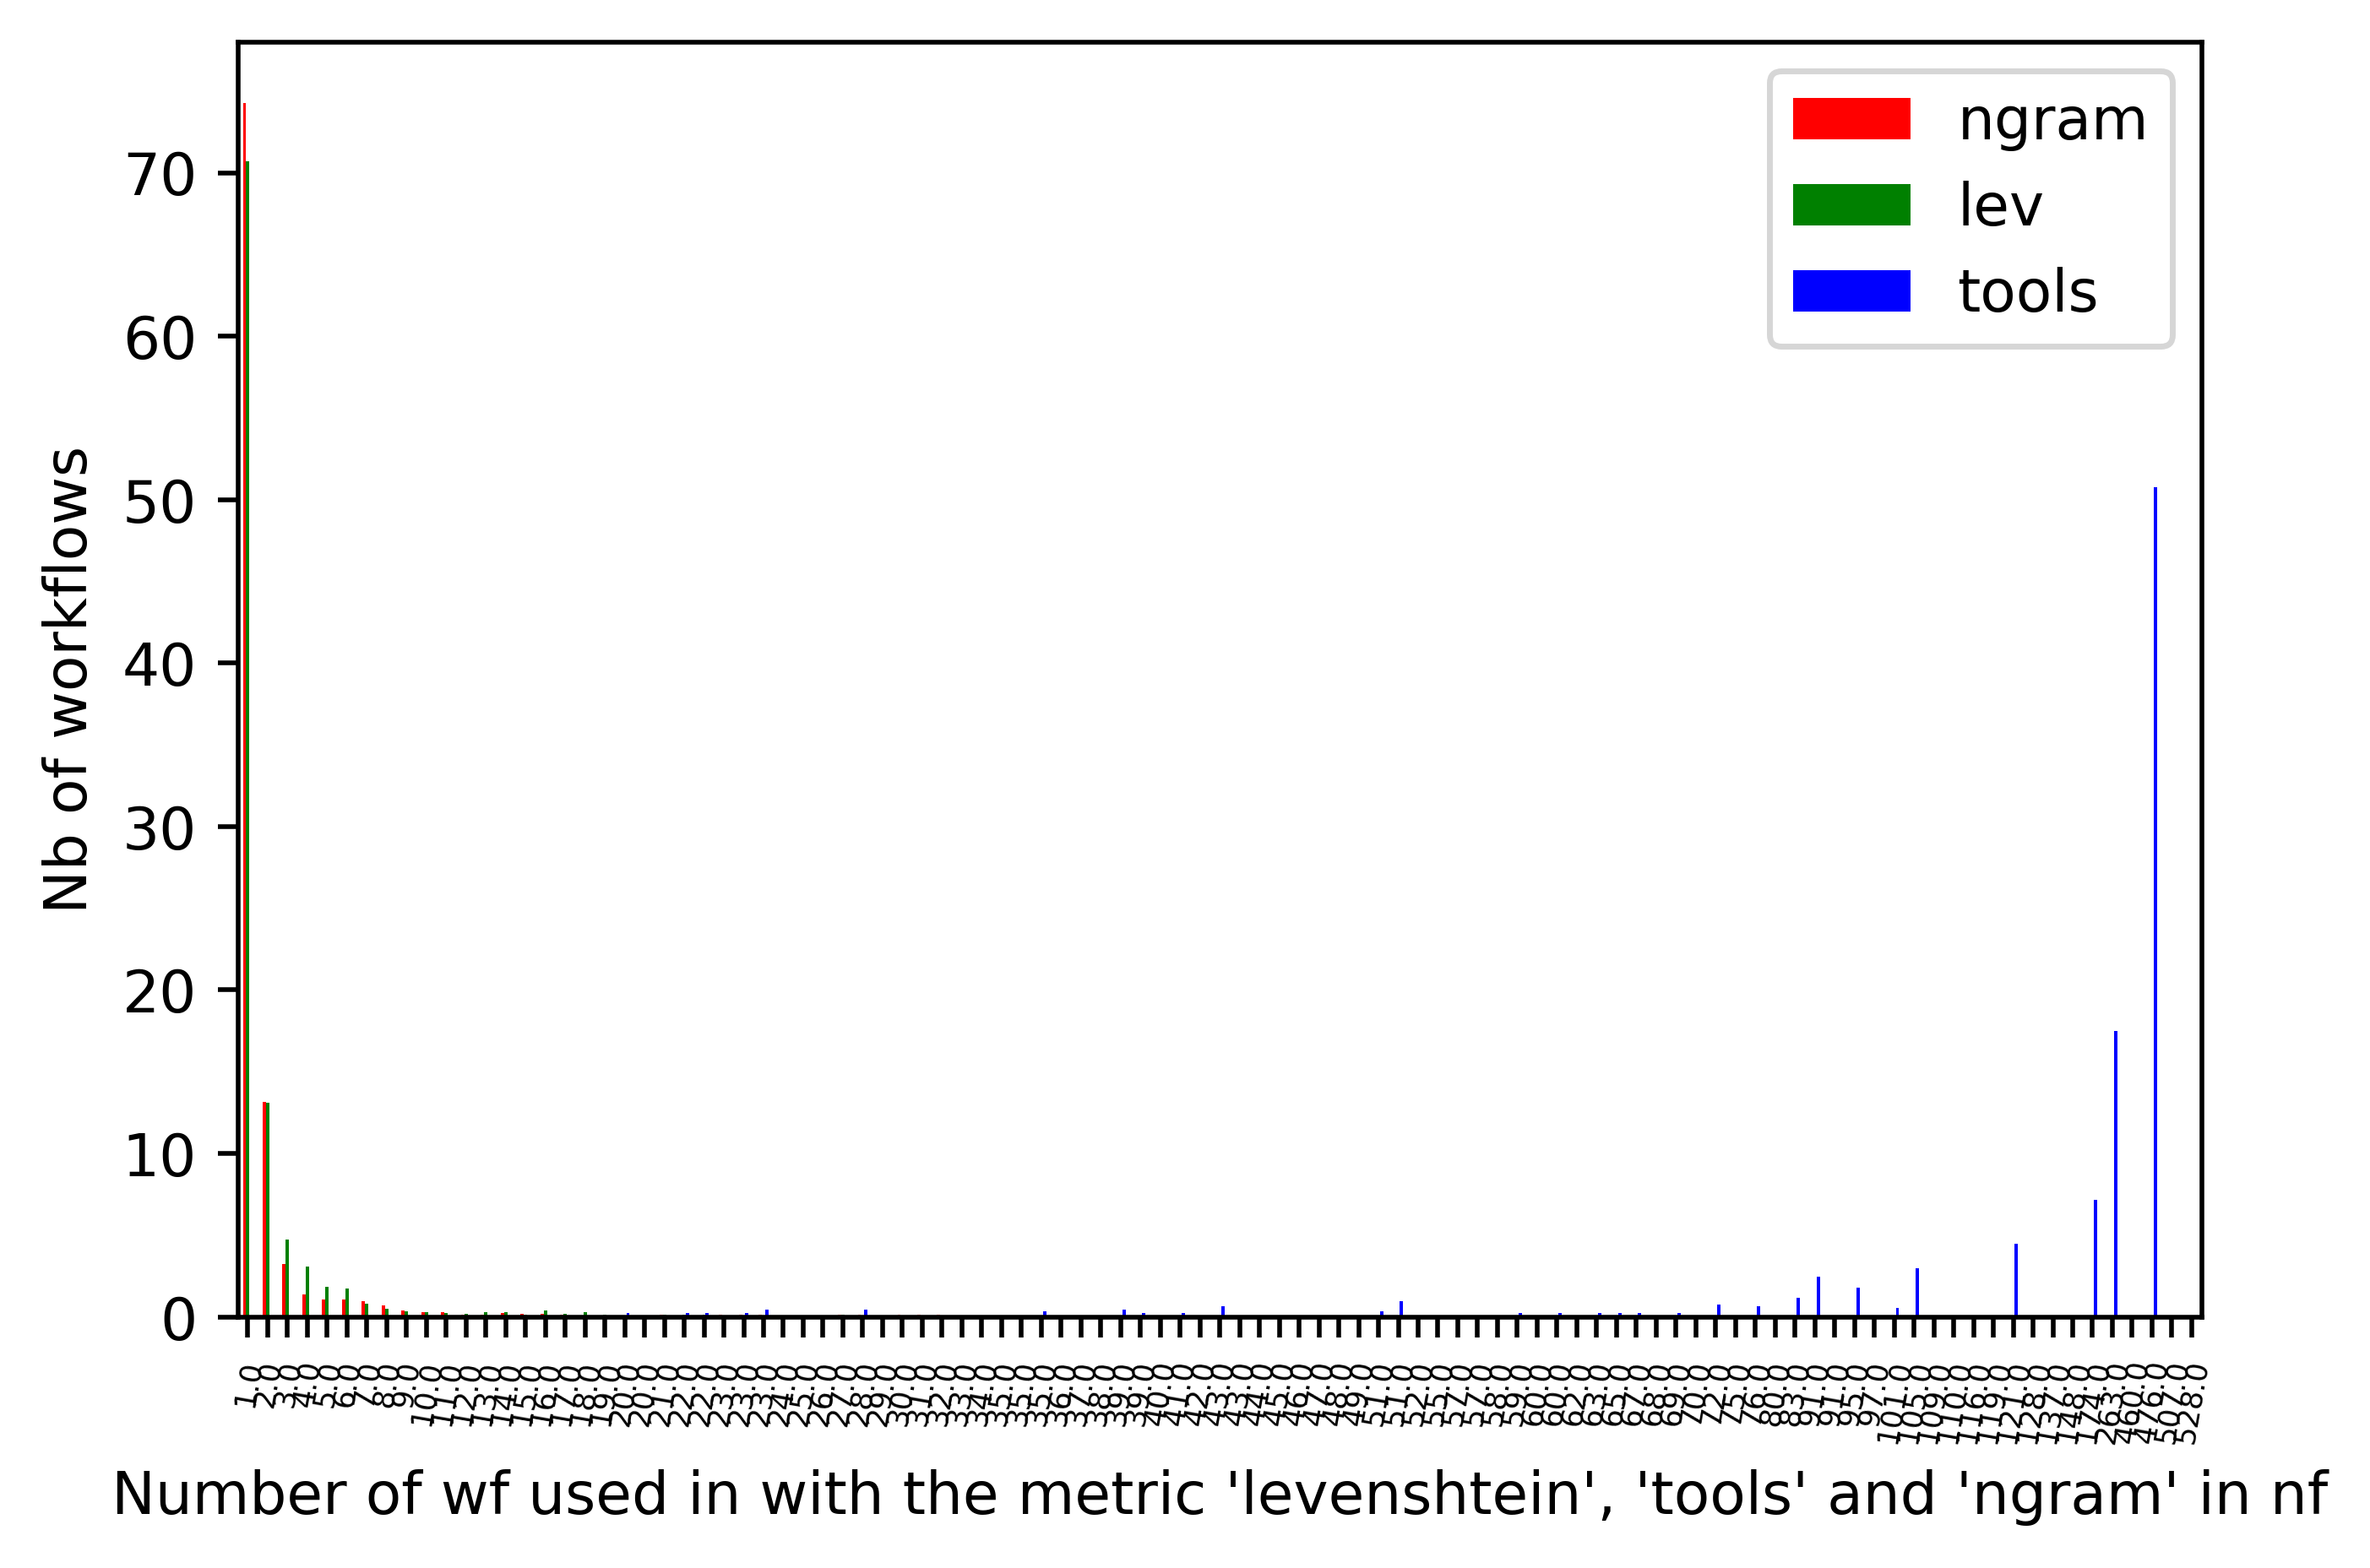

In [132]:
fig_nf_wf = disp_fig_props_wf(df_tot_nf_wf,'nf')

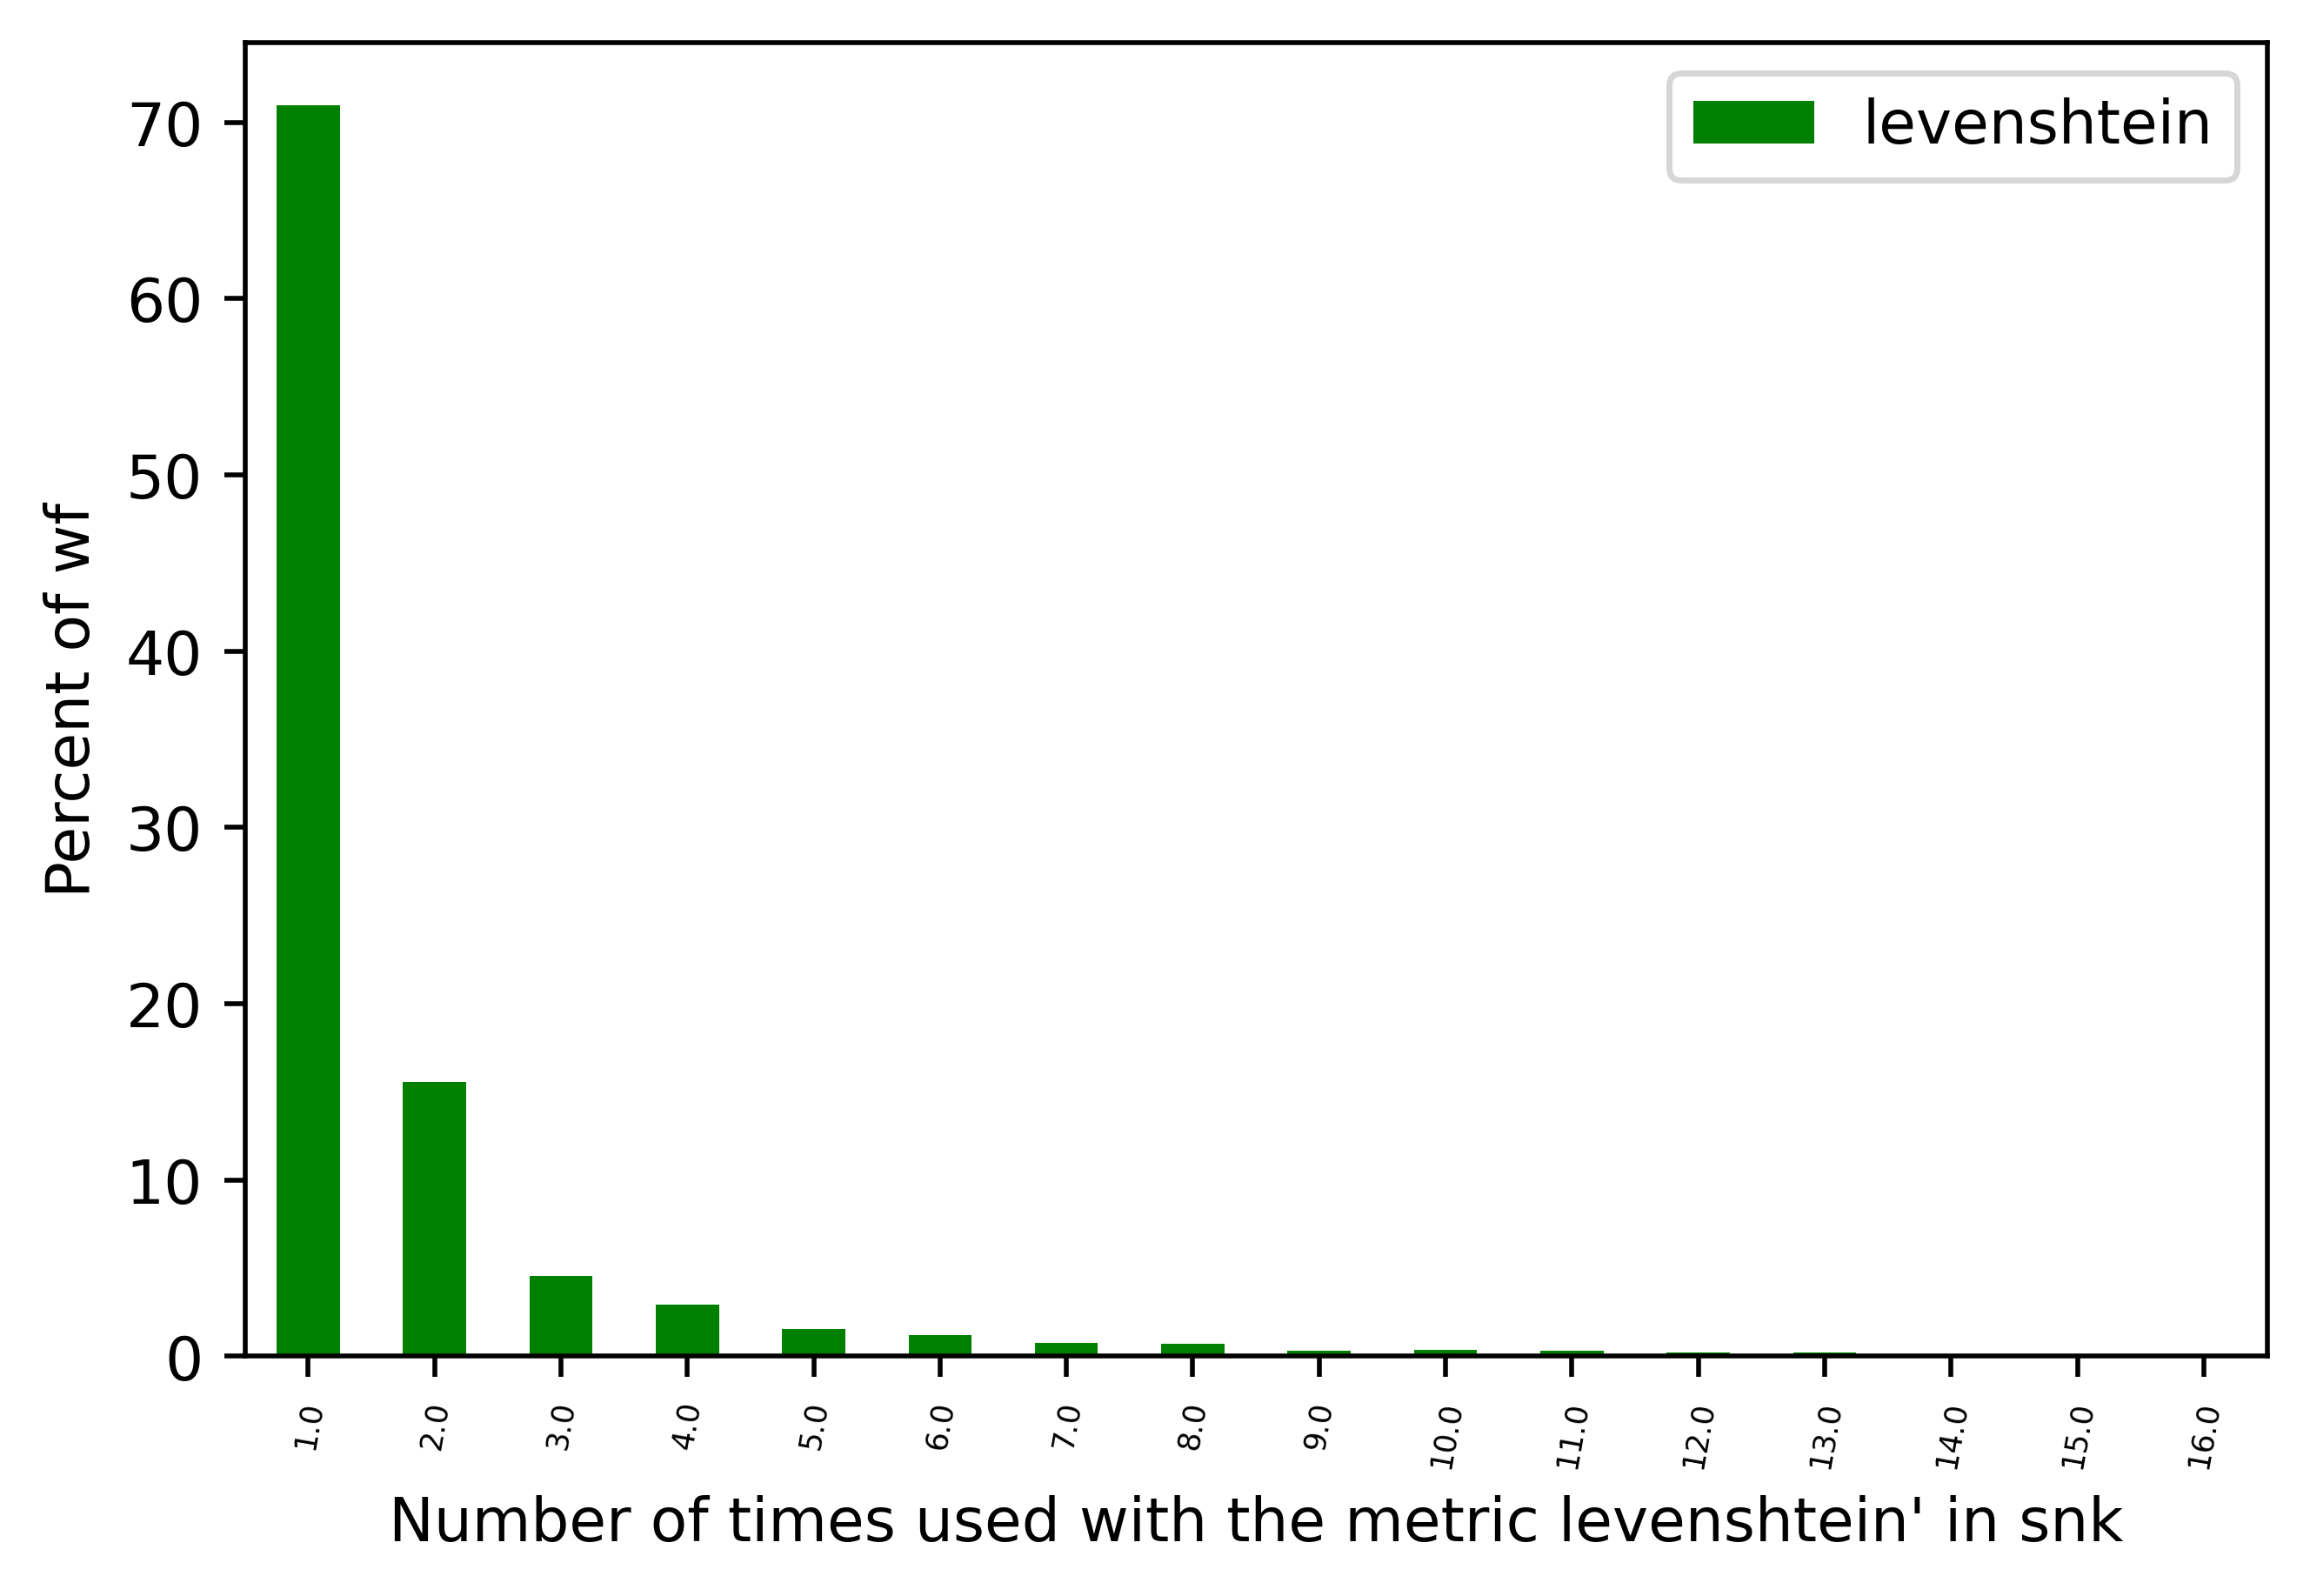

<AxesSubplot:xlabel="Number of times used with the metric levenshtein' in snk", ylabel='Percent of wf'>

In [96]:
disp_single_metric(df_snk_lev_wf,"nb_wf","snk","levenshtein")

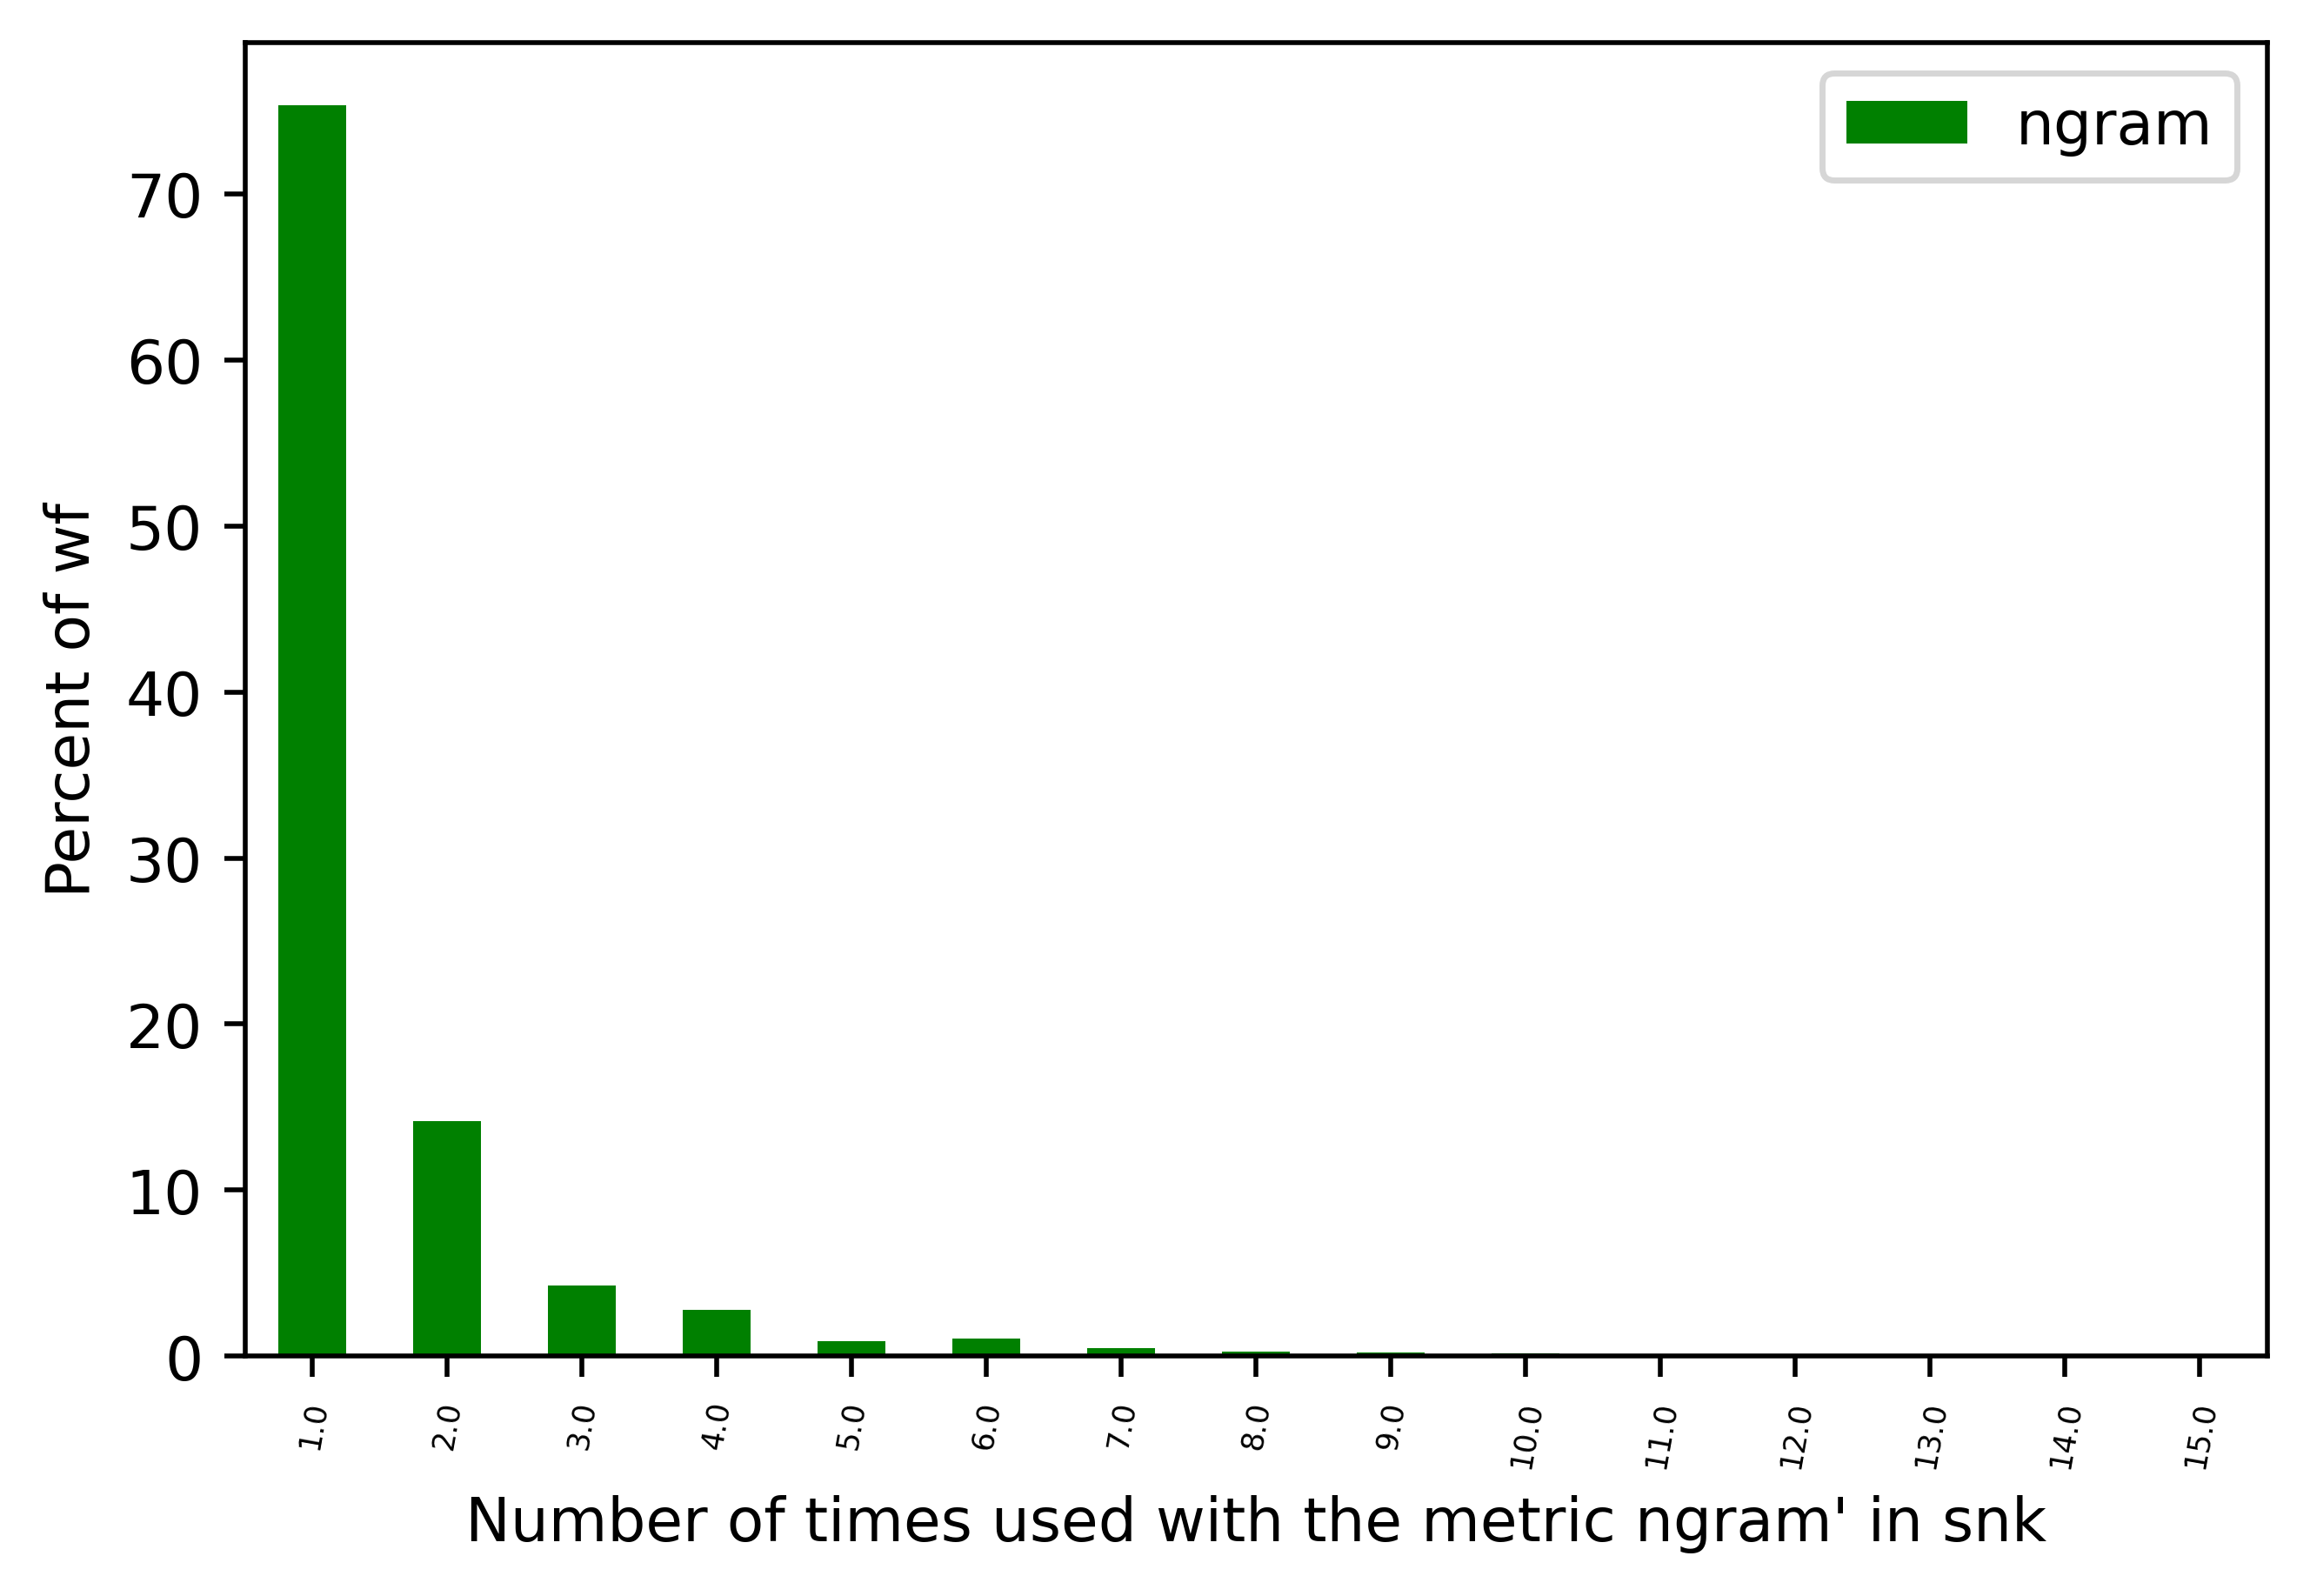

<AxesSubplot:xlabel="Number of times used with the metric ngram' in snk", ylabel='Percent of wf'>

In [97]:
disp_single_metric(df_snk_ngram_wf,"nb_wf","snk","ngram")

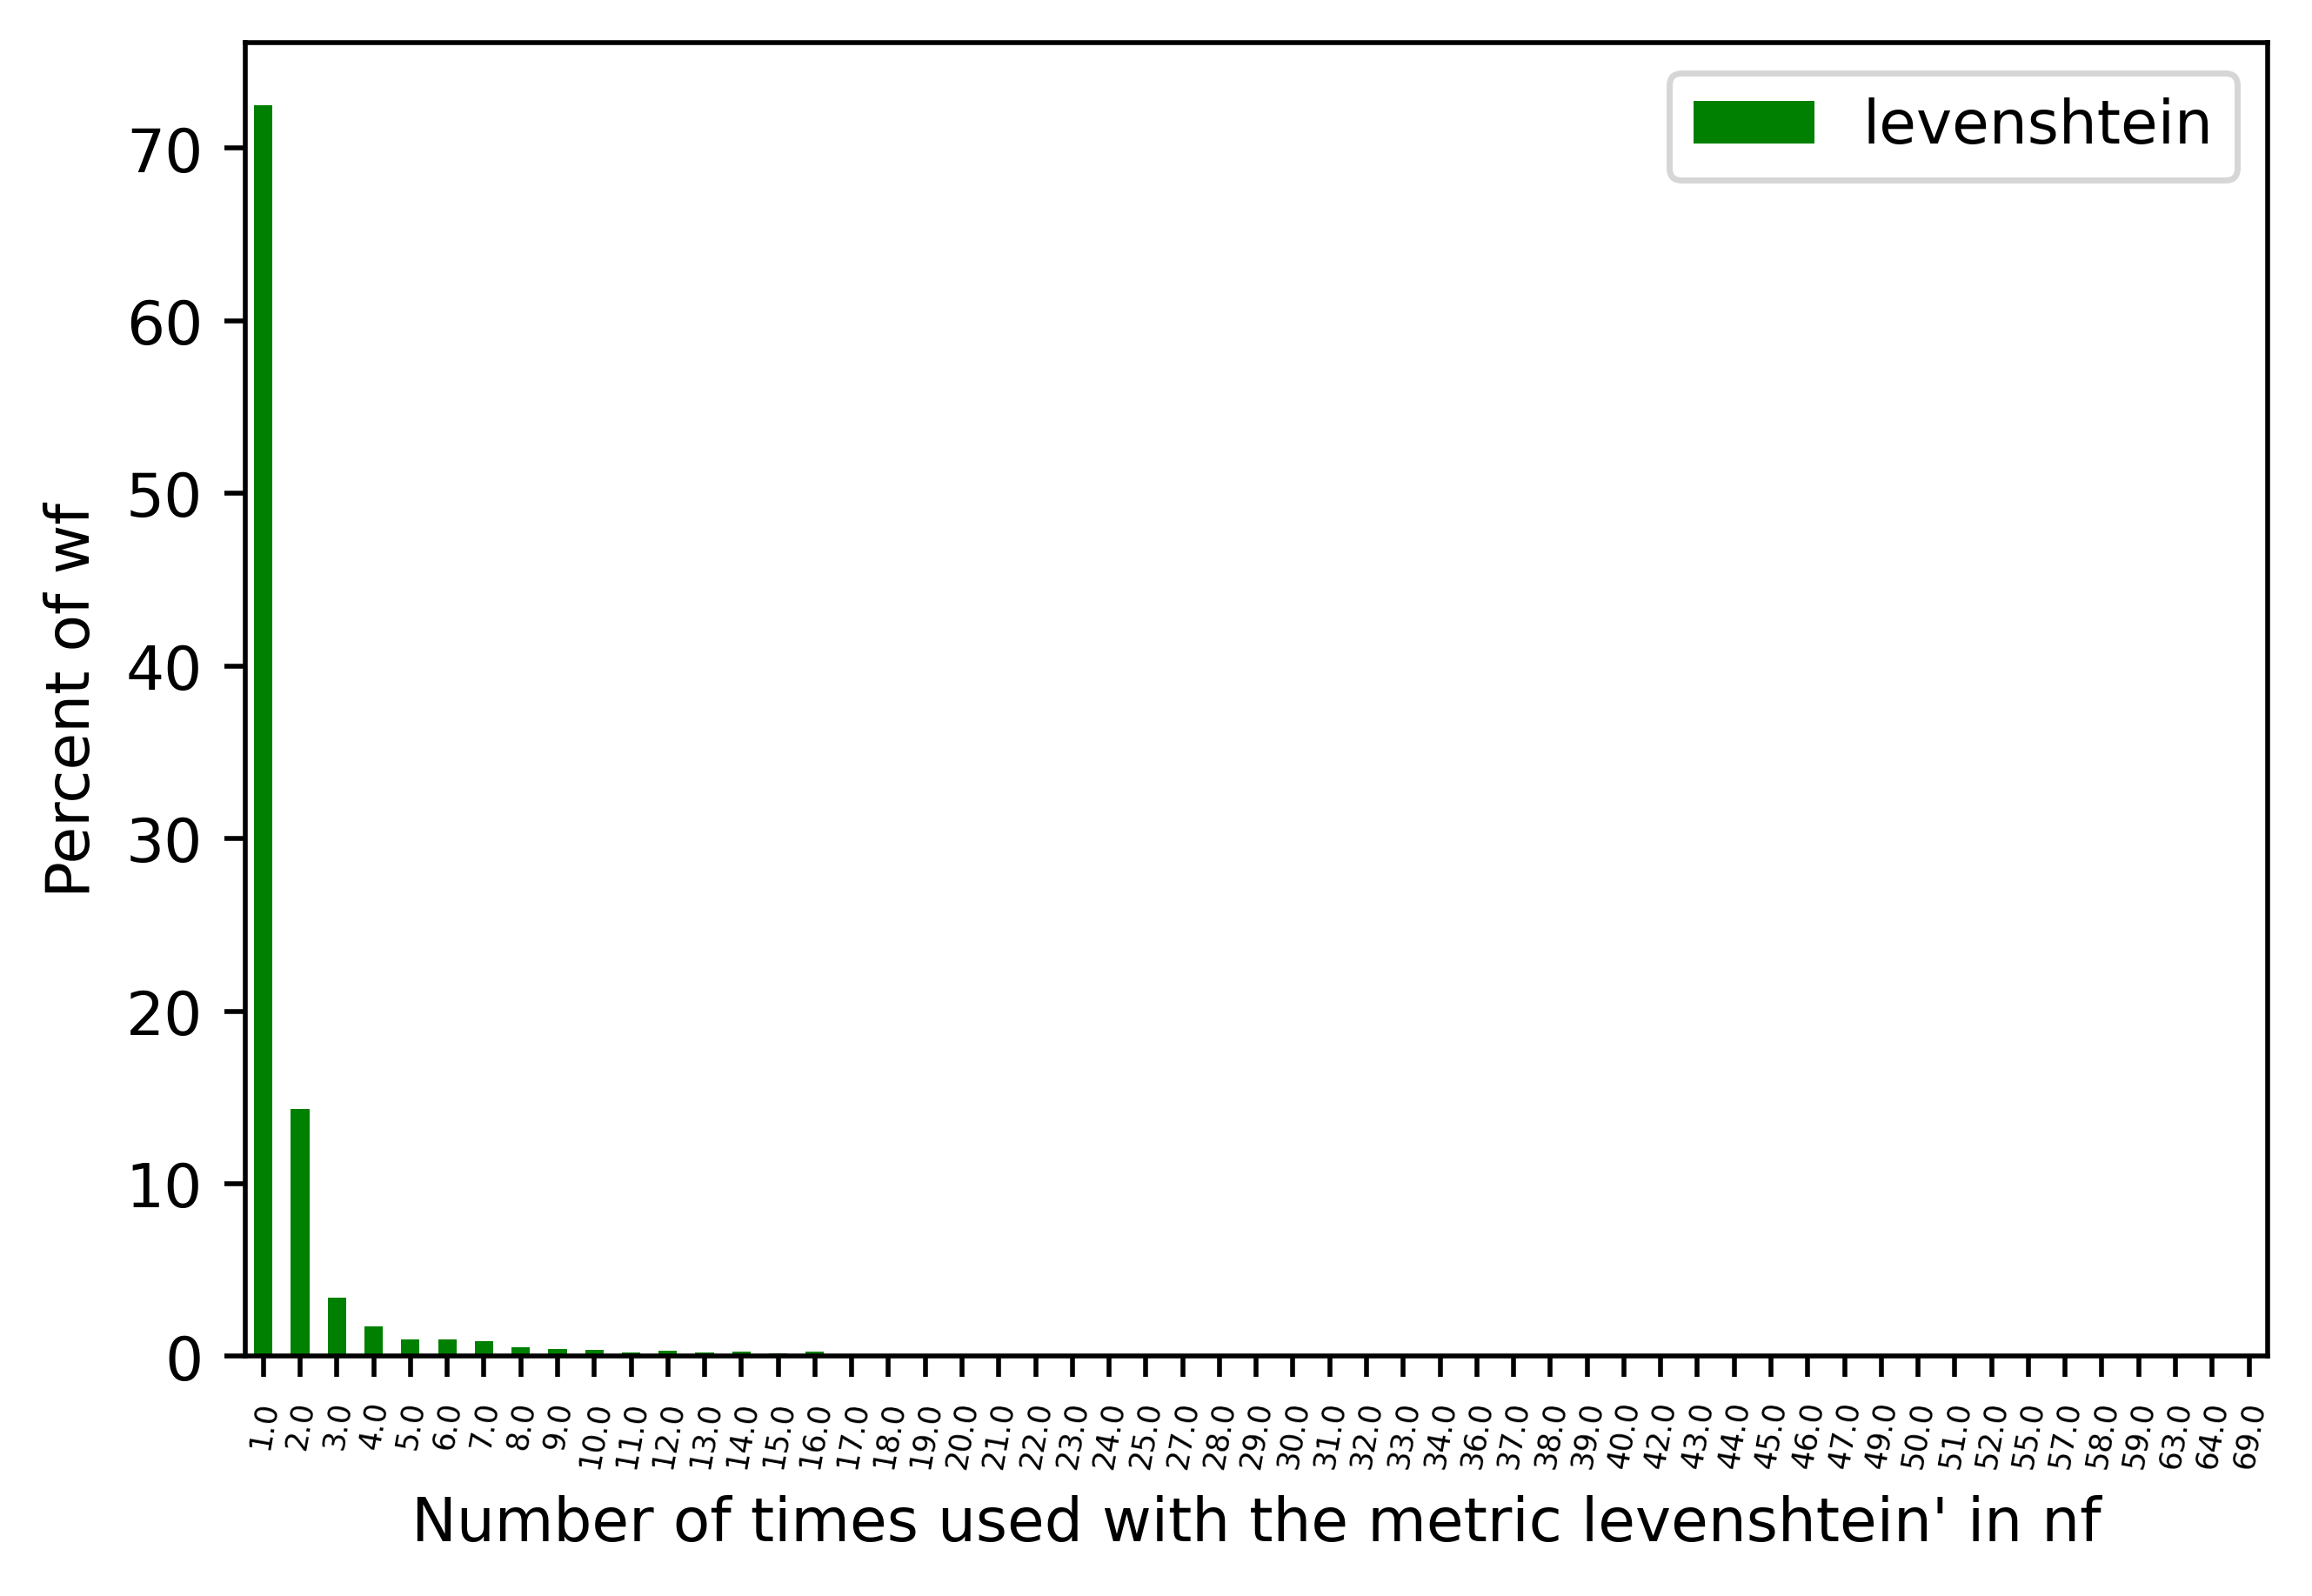

<AxesSubplot:xlabel="Number of times used with the metric levenshtein' in nf", ylabel='Percent of wf'>

In [98]:
disp_single_metric(df_nf_lev_wf,"nb_wf","nf","levenshtein")

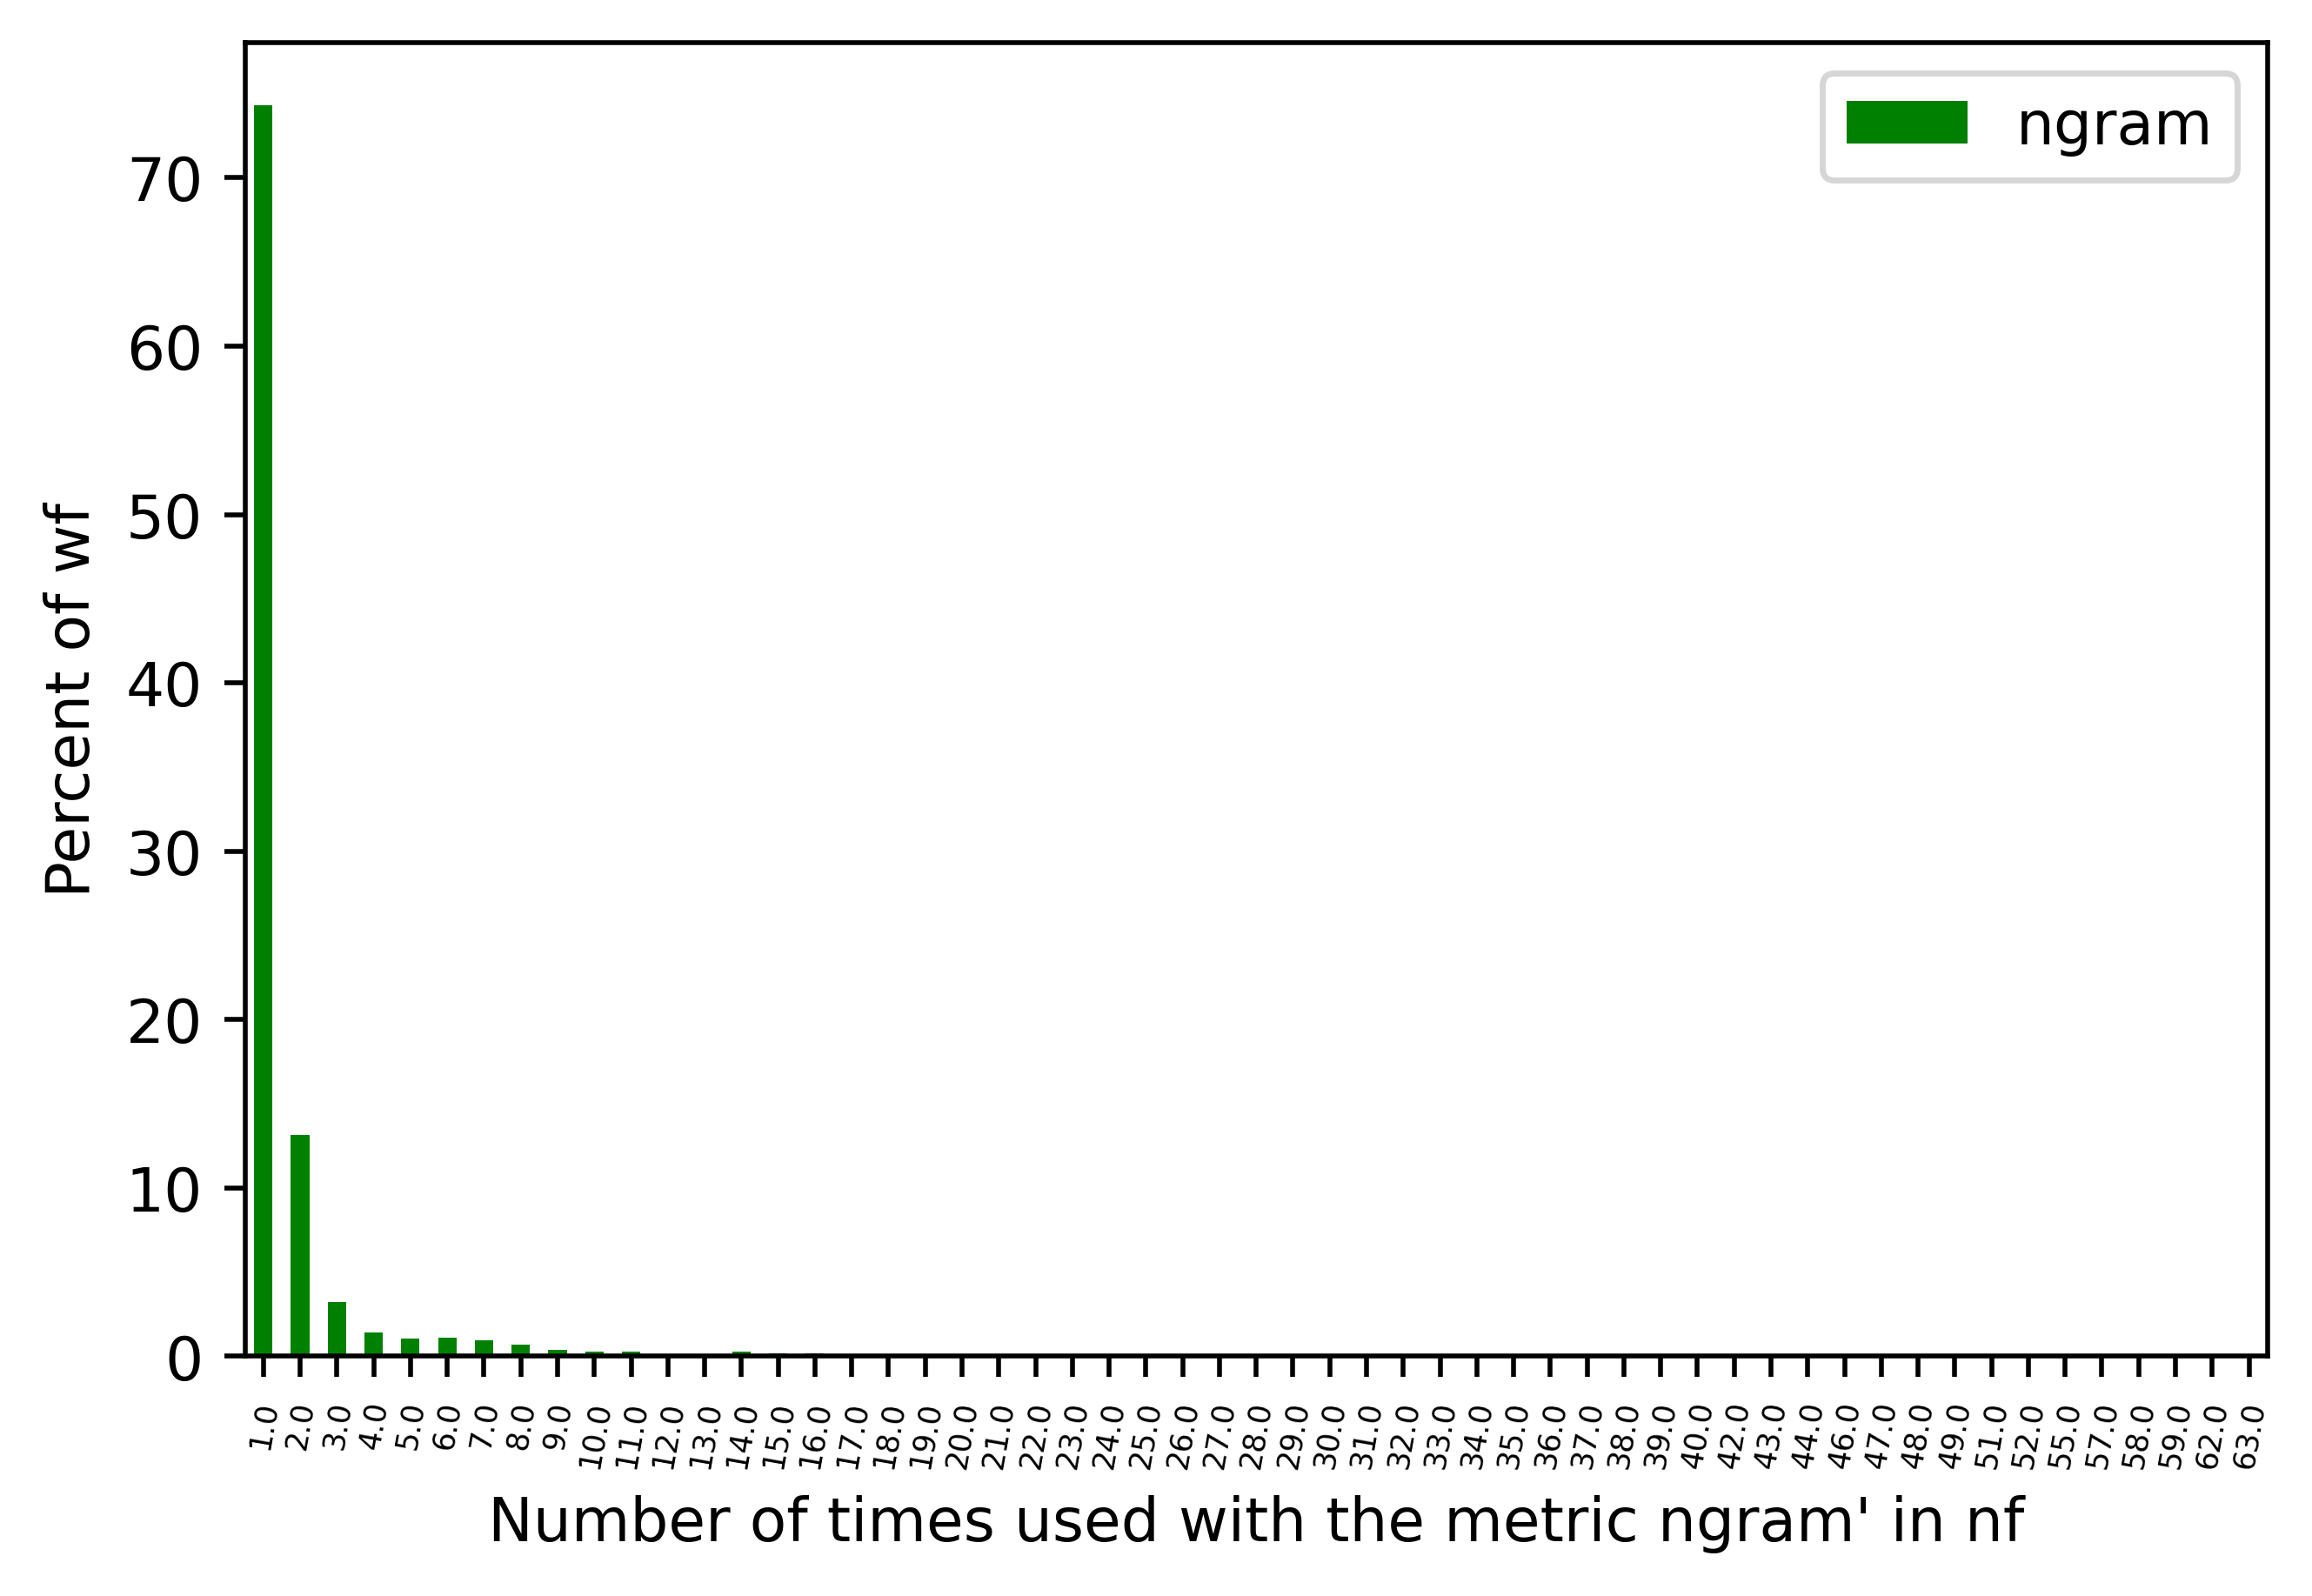

<AxesSubplot:xlabel="Number of times used with the metric ngram' in nf", ylabel='Percent of wf'>

In [99]:
disp_single_metric(df_nf_ngram_wf,"nb_wf","nf","ngram")

### Répartition de la réutilisation des process

Combien de fois chaque process est il réutilisé ?

Répartition de la réutilisation des process pour les métriques "tools" and "levenshtein" pour snakemake

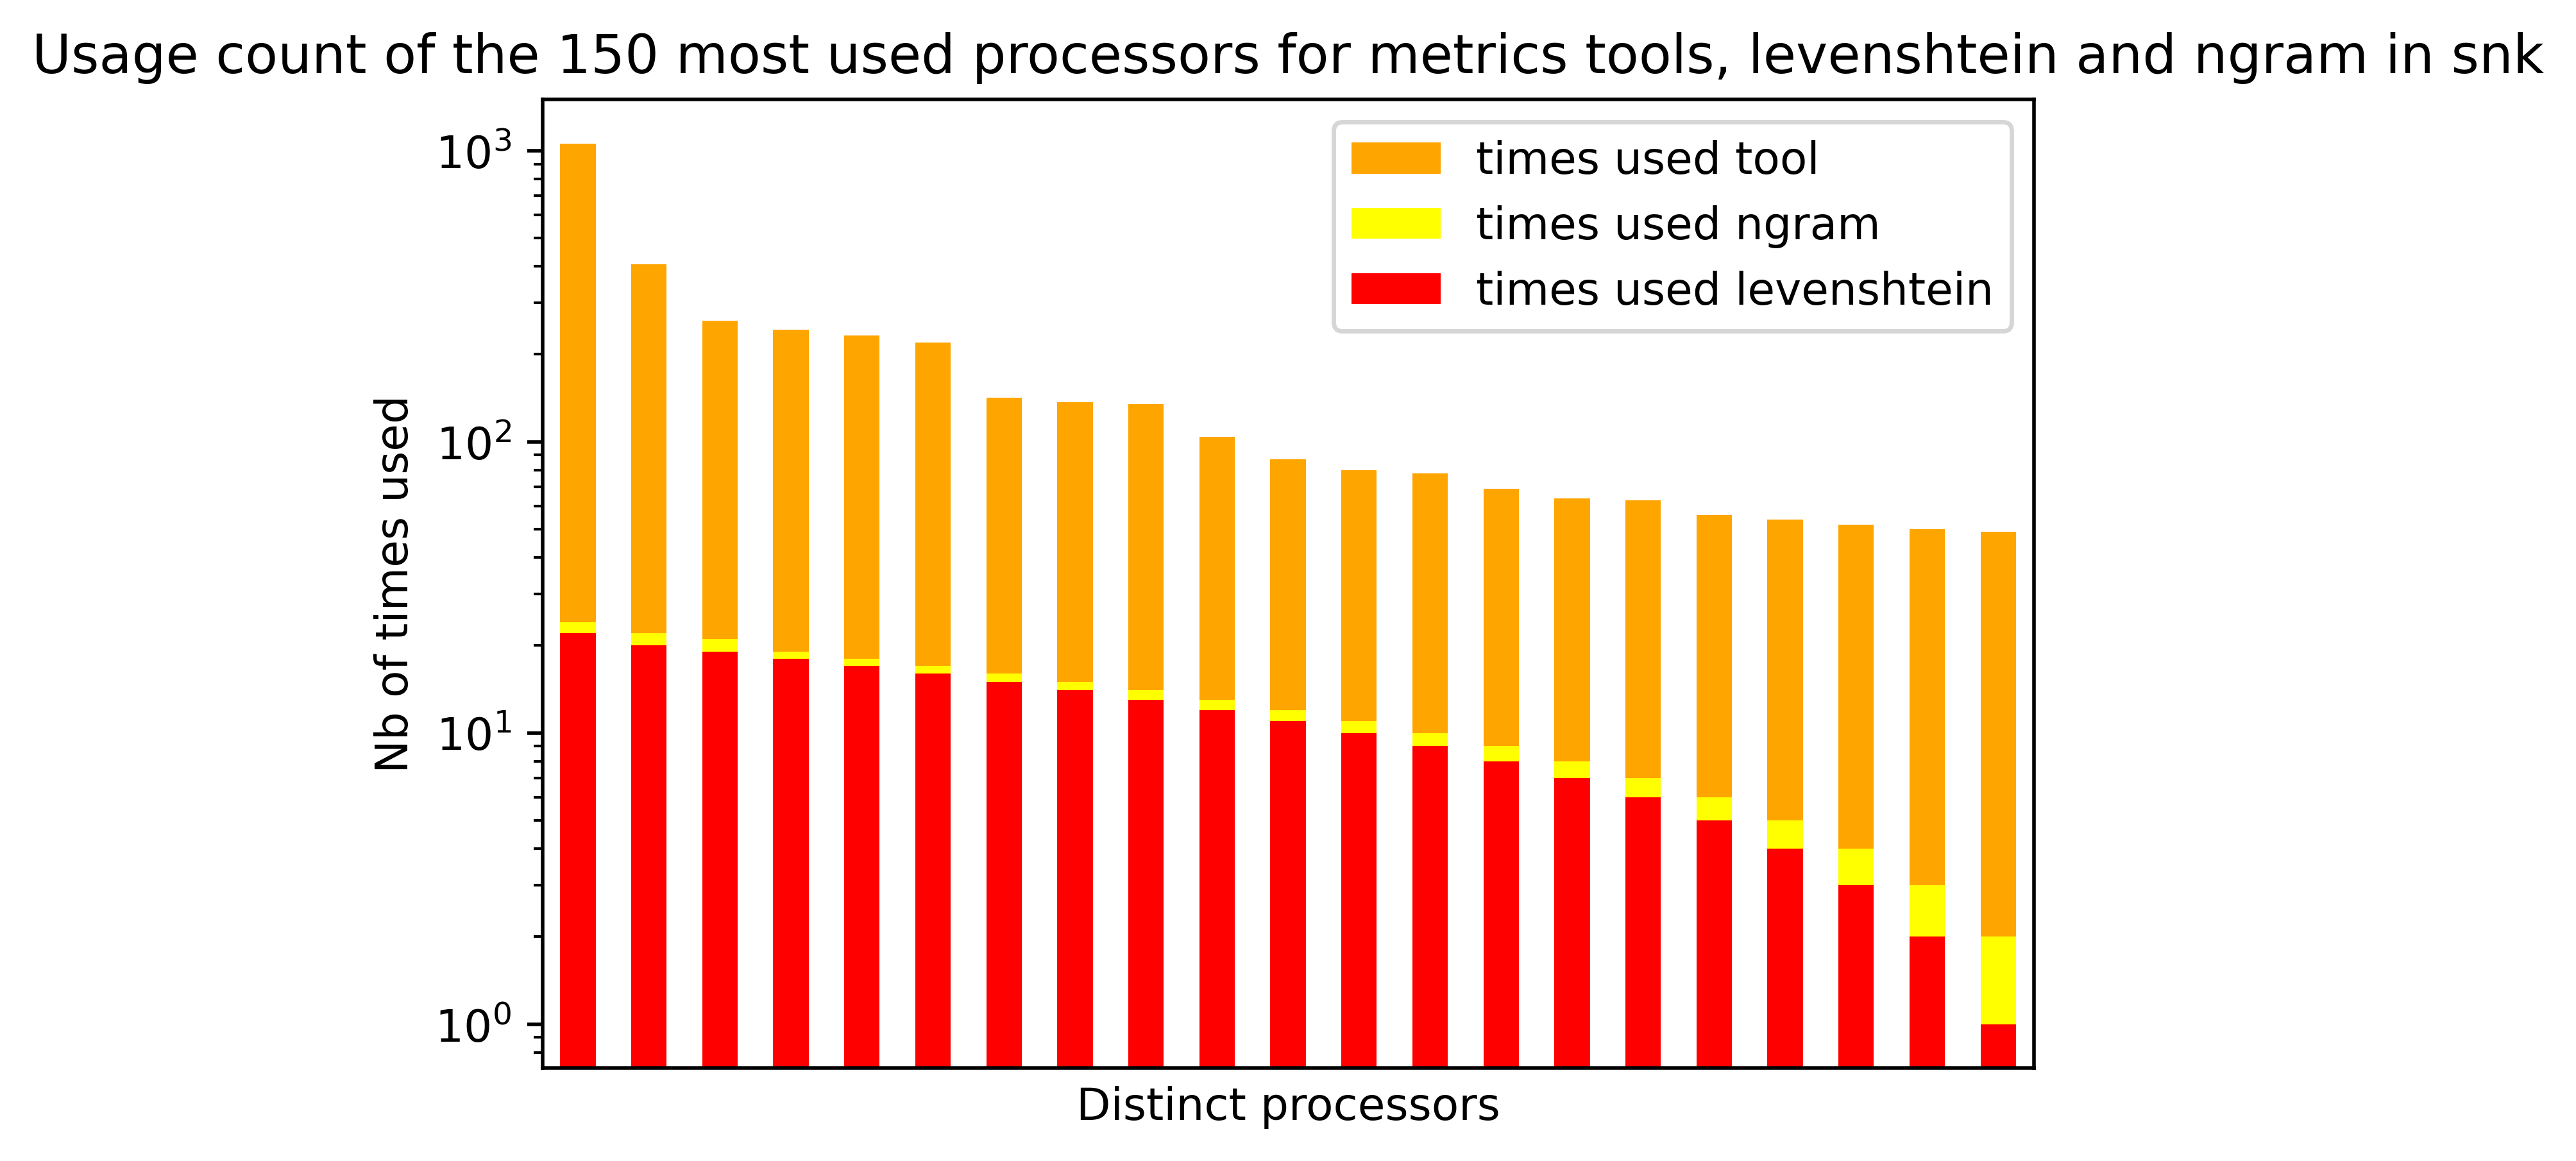

In [107]:
fig_snk = display_fig_stats_process(df_snk,df_snk_lev,df_snk_ngram,150,"snk")

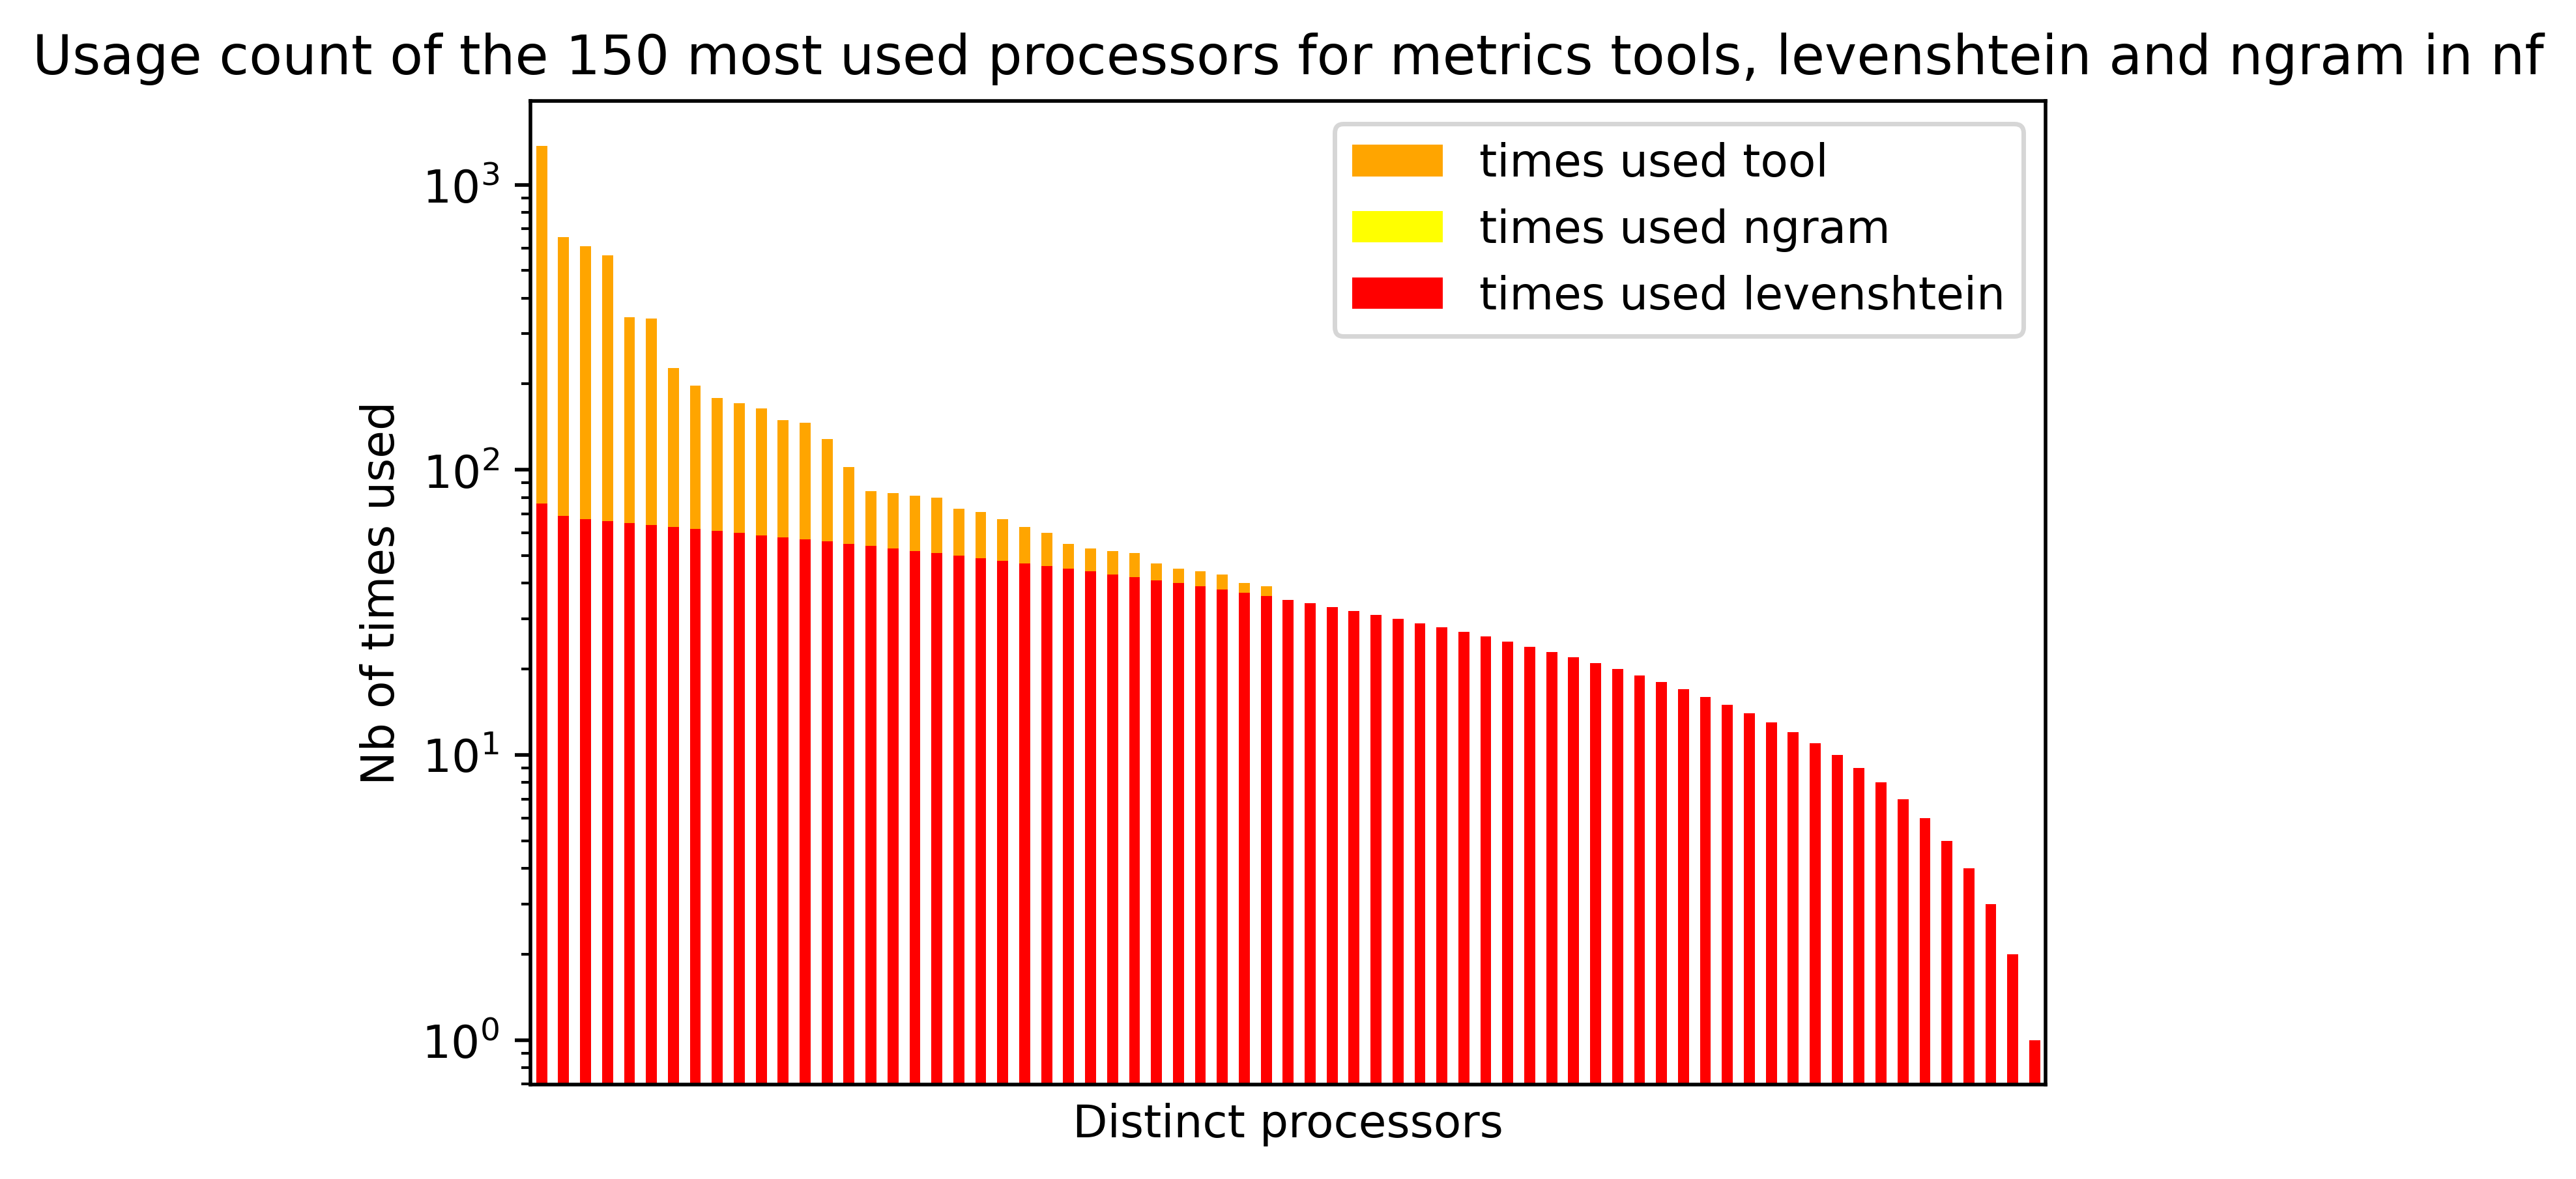

In [108]:
fig_nf = display_fig_stats_process(df_nf,df_nf_lev,df_nf_ngram,150,"nf")

In order to see better what's going on with the levenshtein, let us look at this metric only :

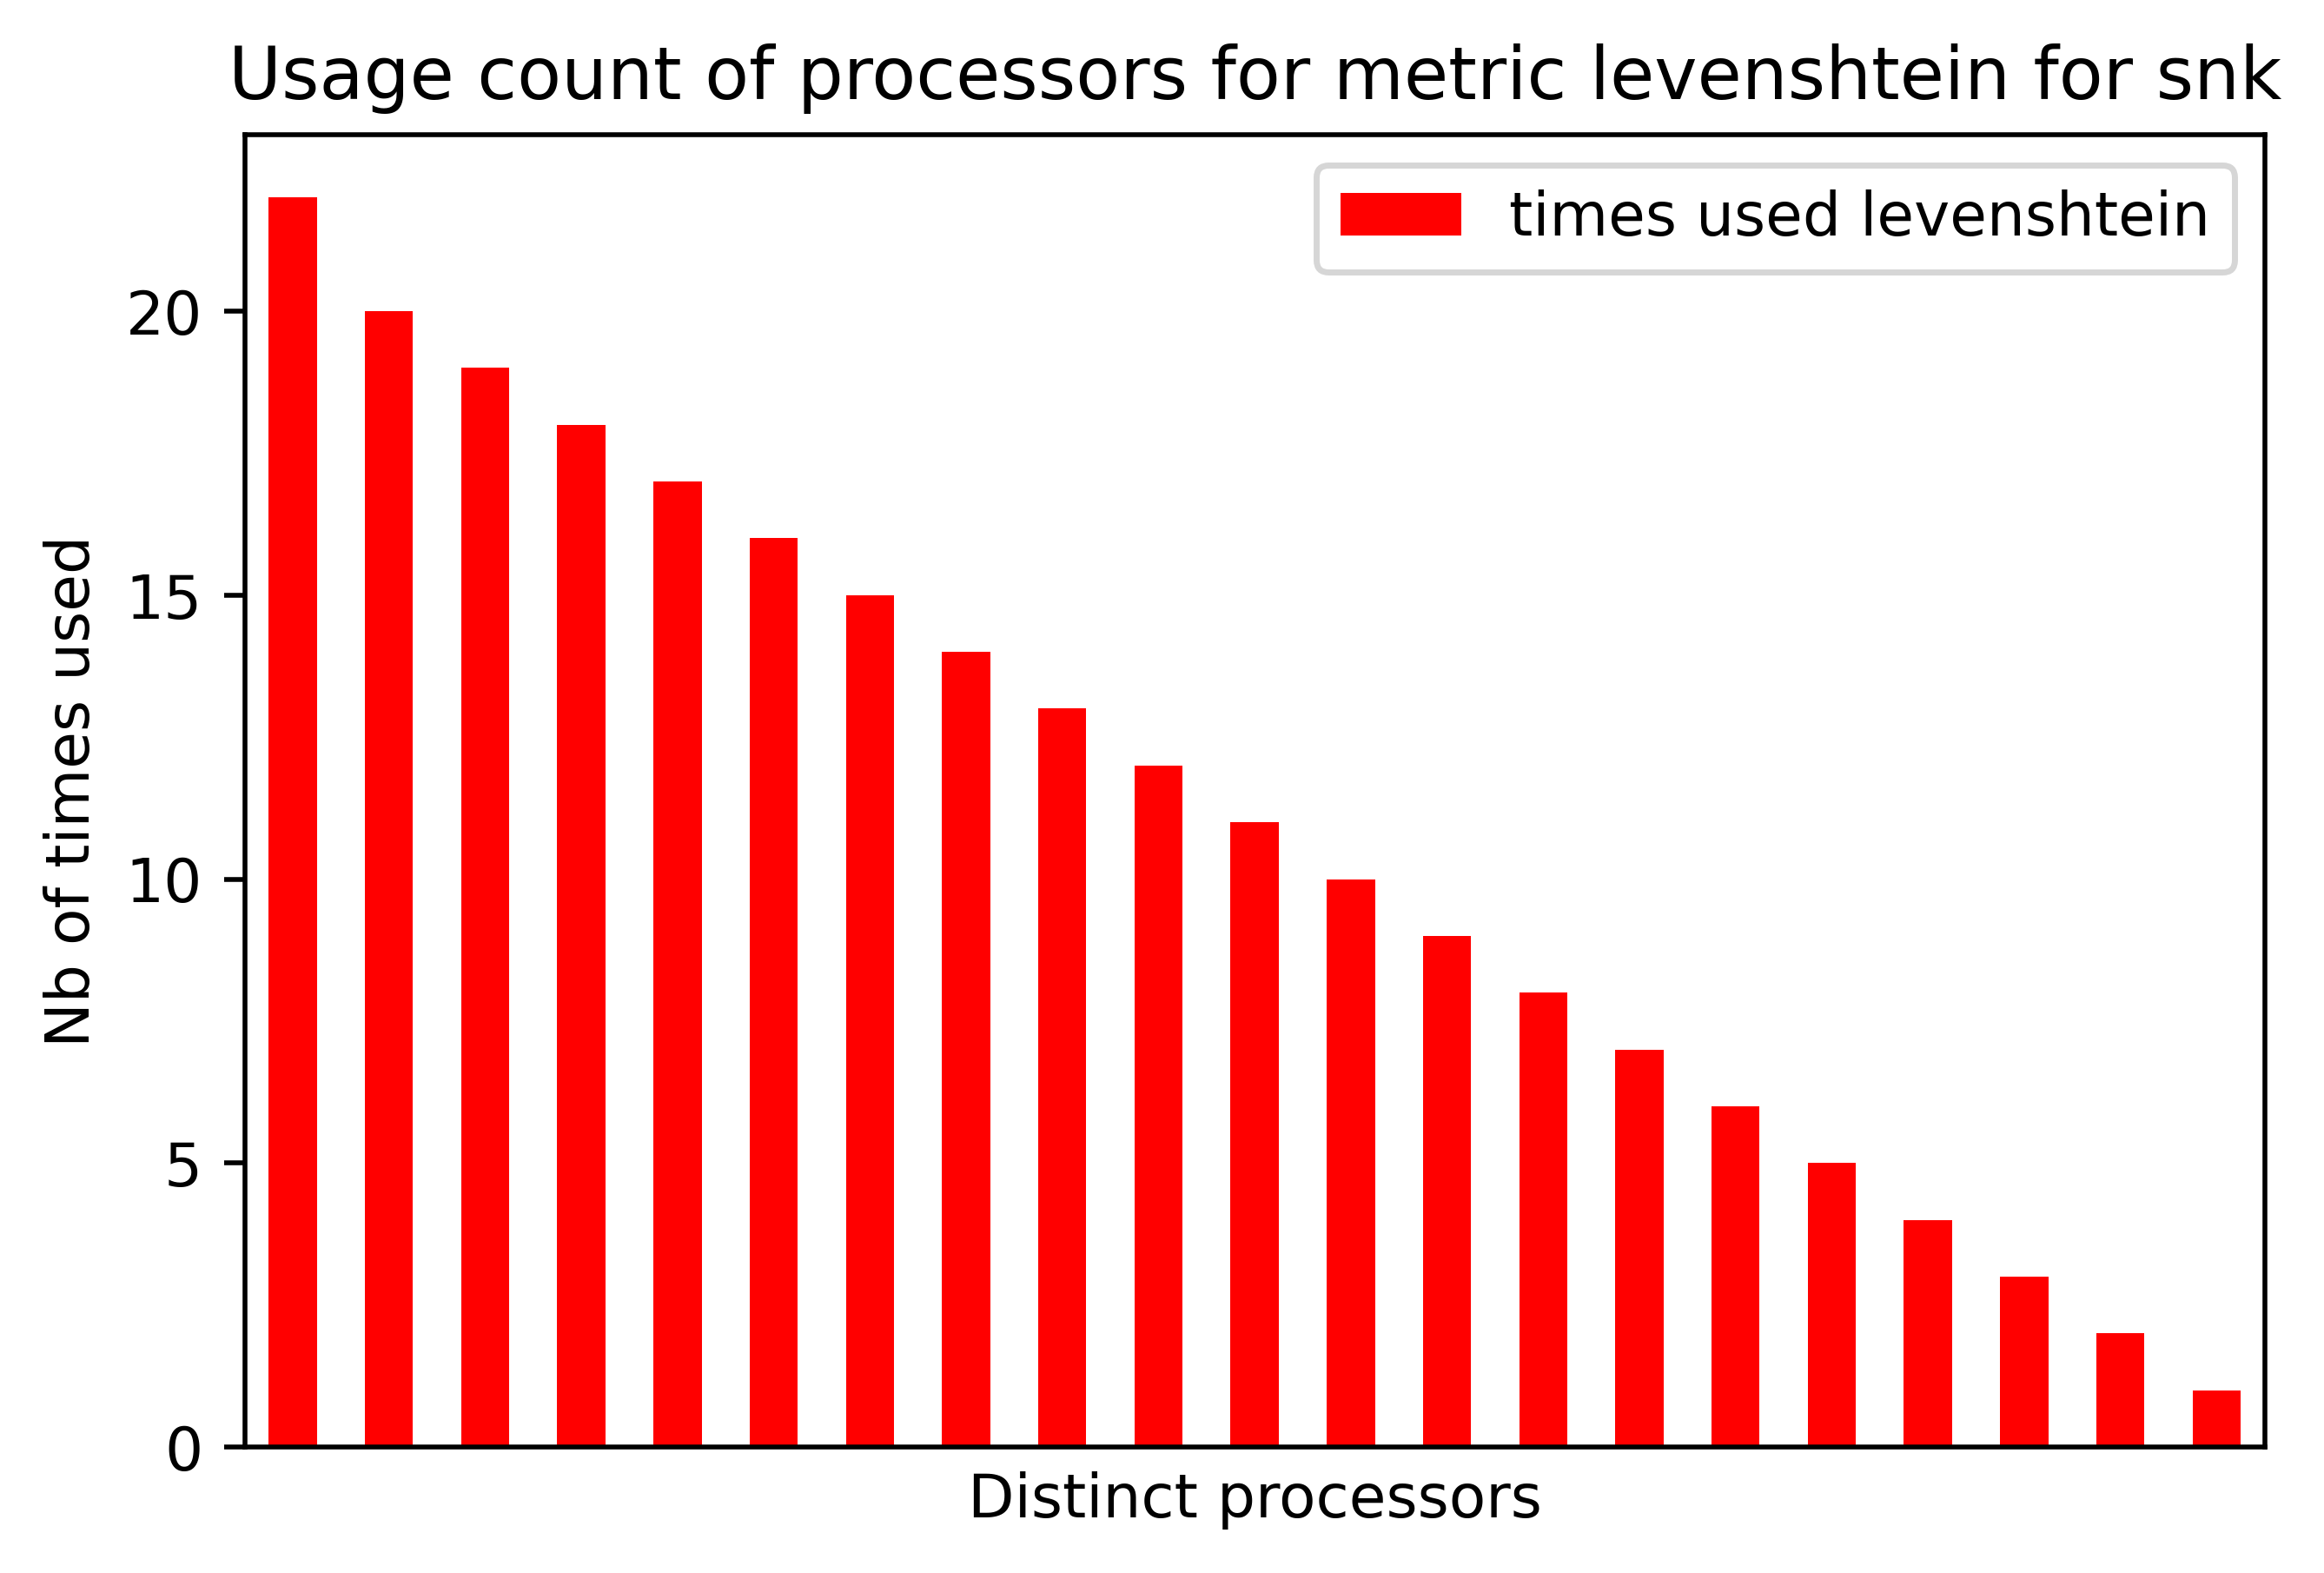

In [115]:
display_fig_stats_metric(df_snk_lev,"snk",'levenshtein')

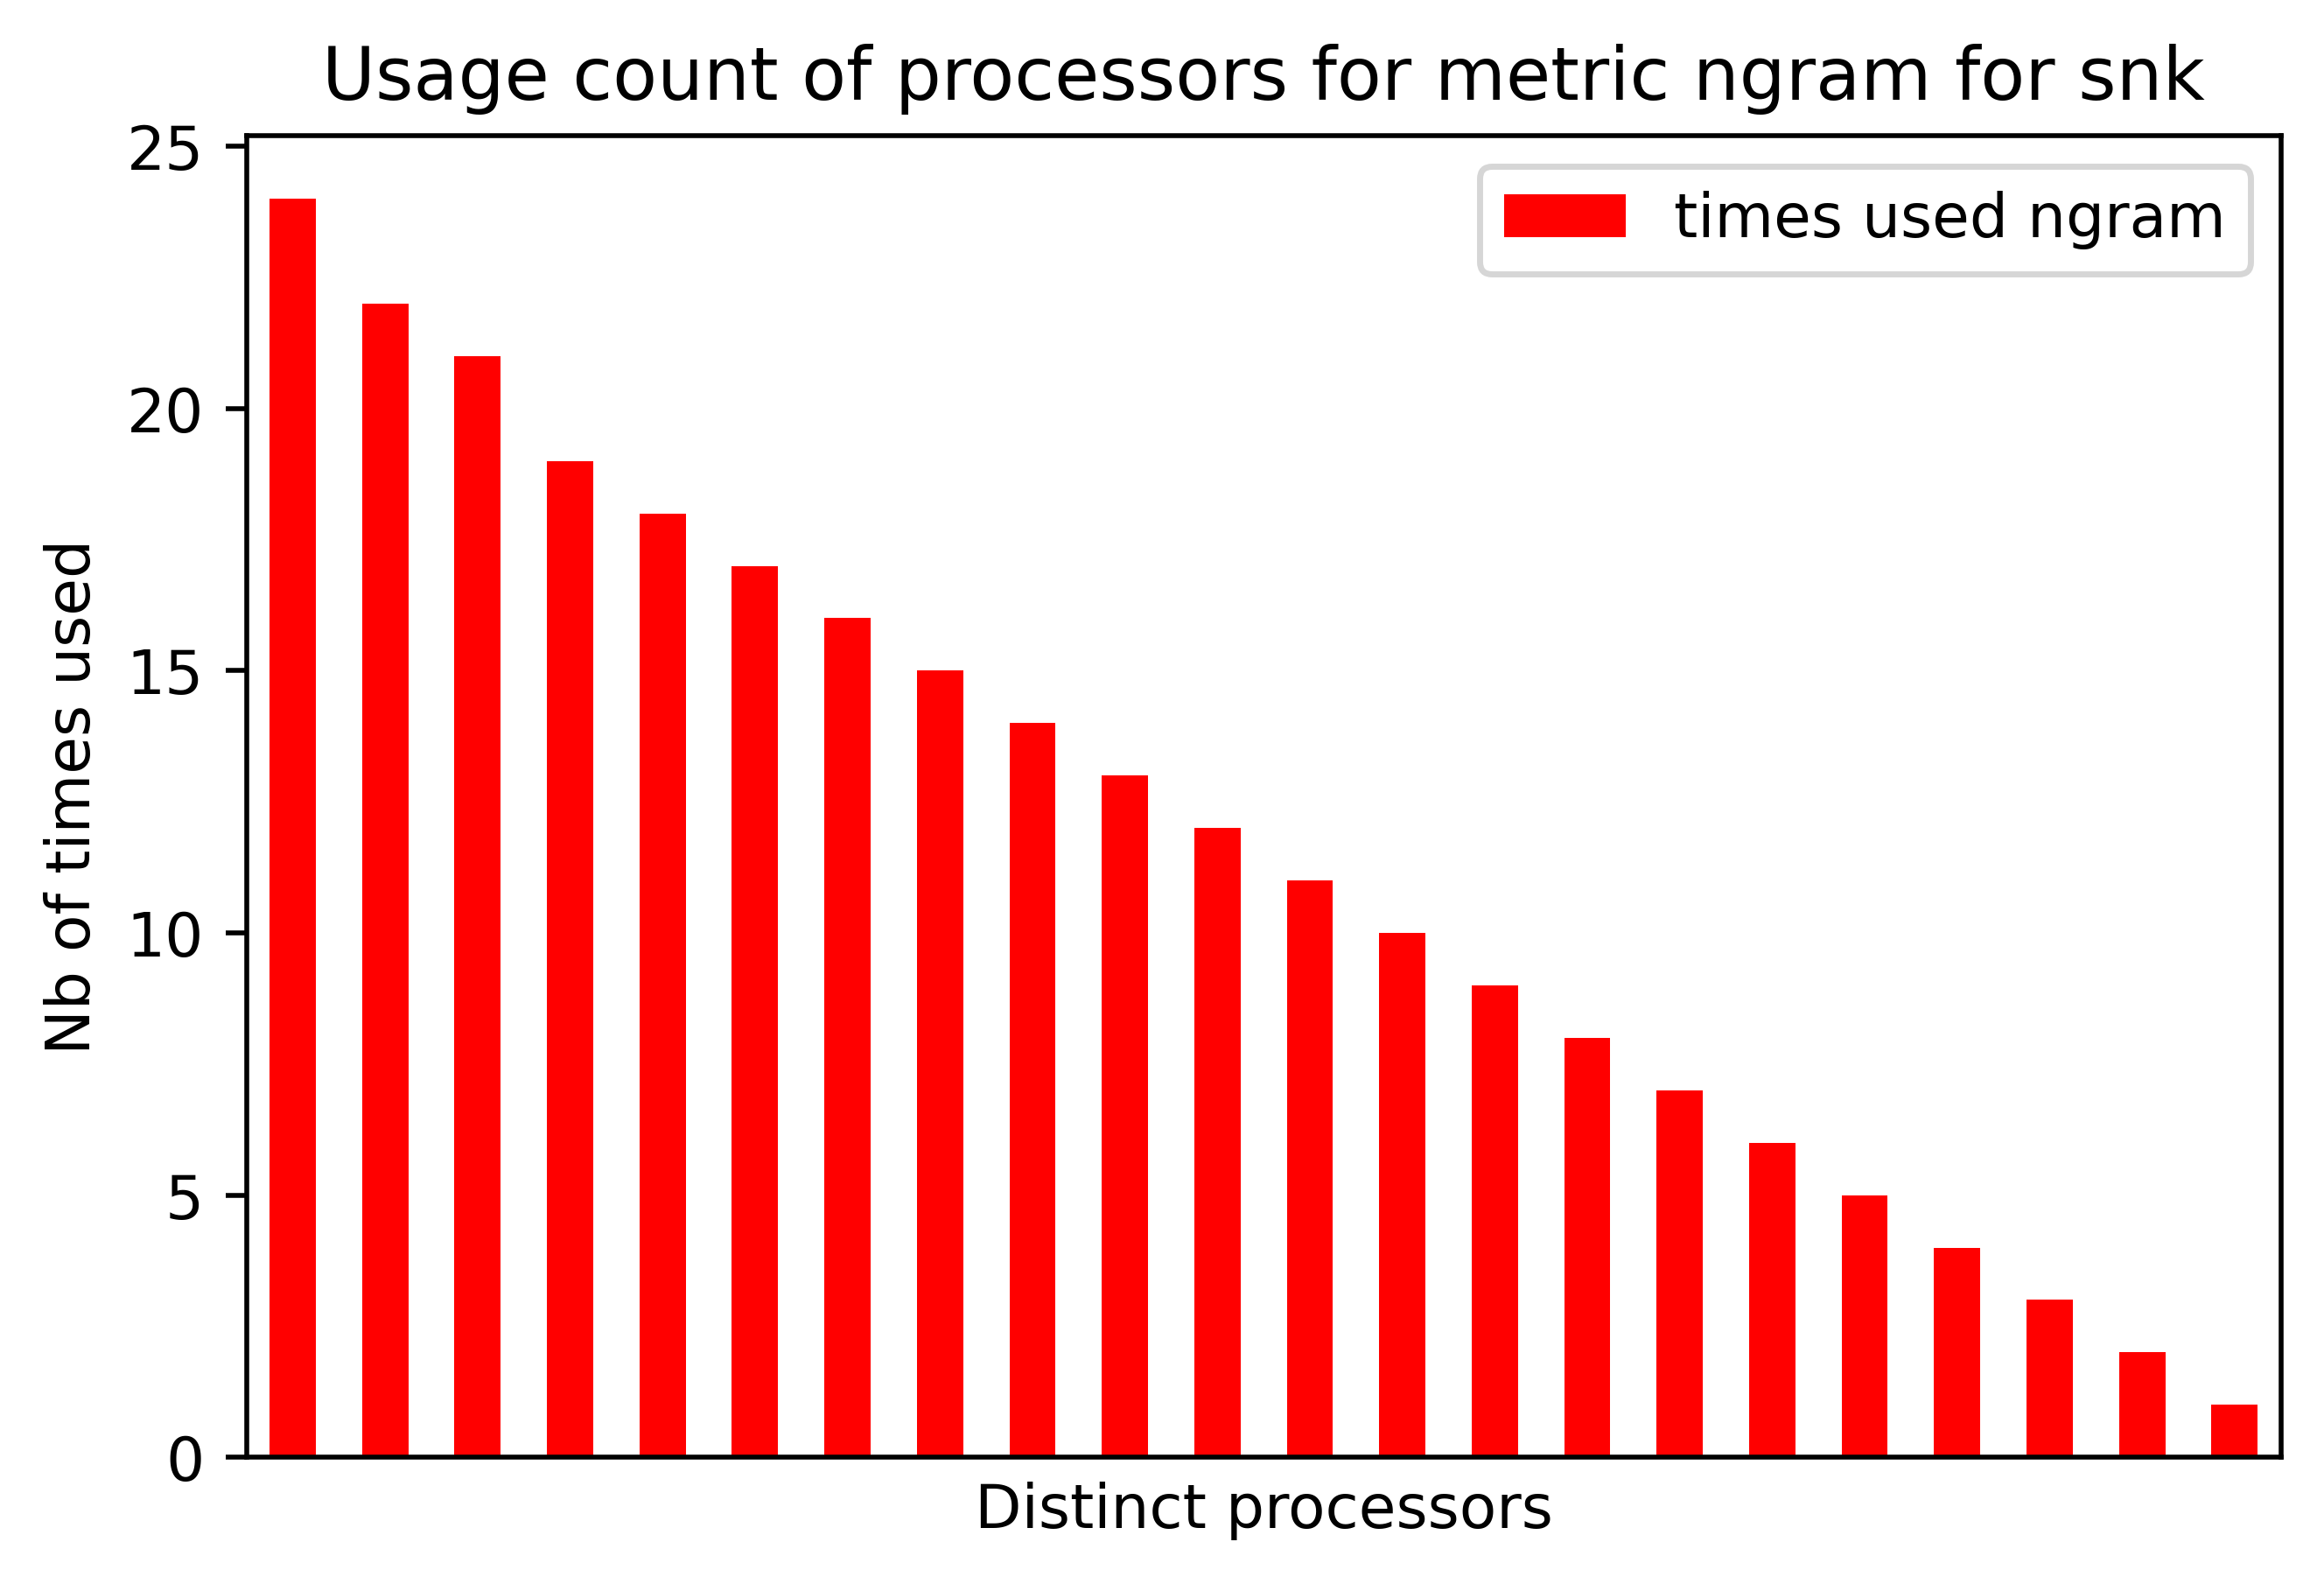

In [116]:
display_fig_stats_metric(df_snk_ngram,"snk",'ngram')

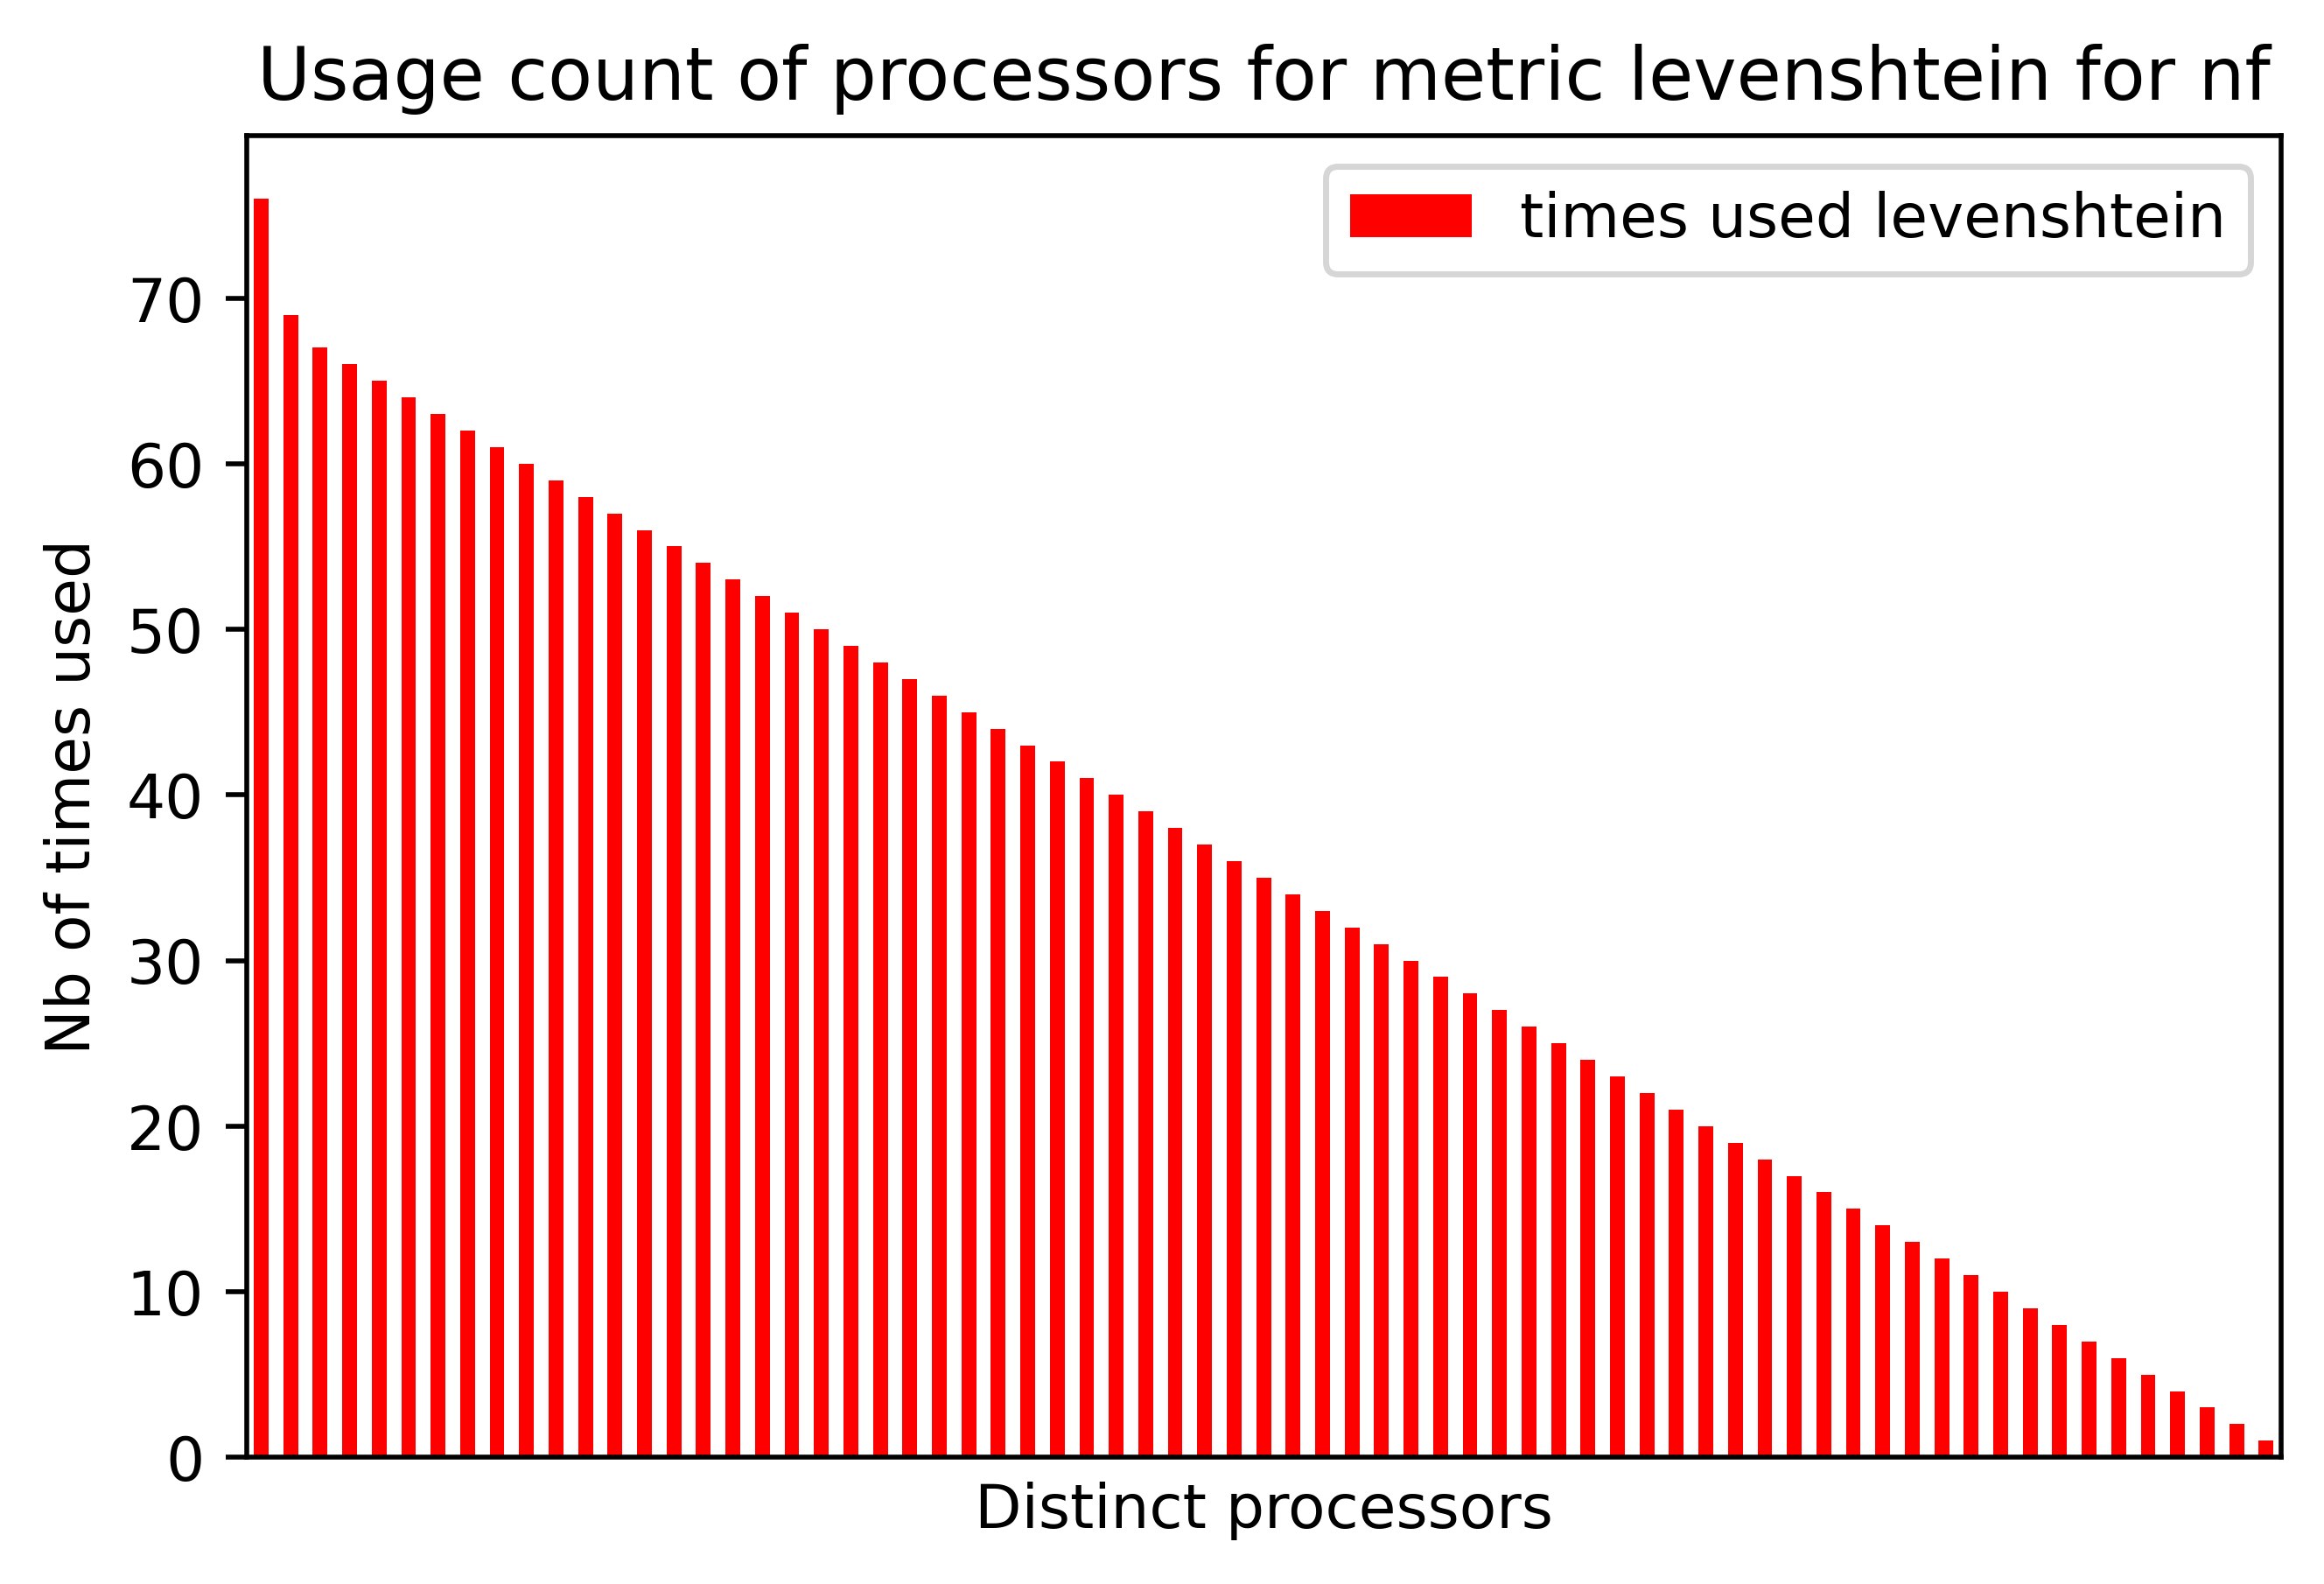

In [117]:
display_fig_stats_metric(df_nf_lev,"nf",'levenshtein')

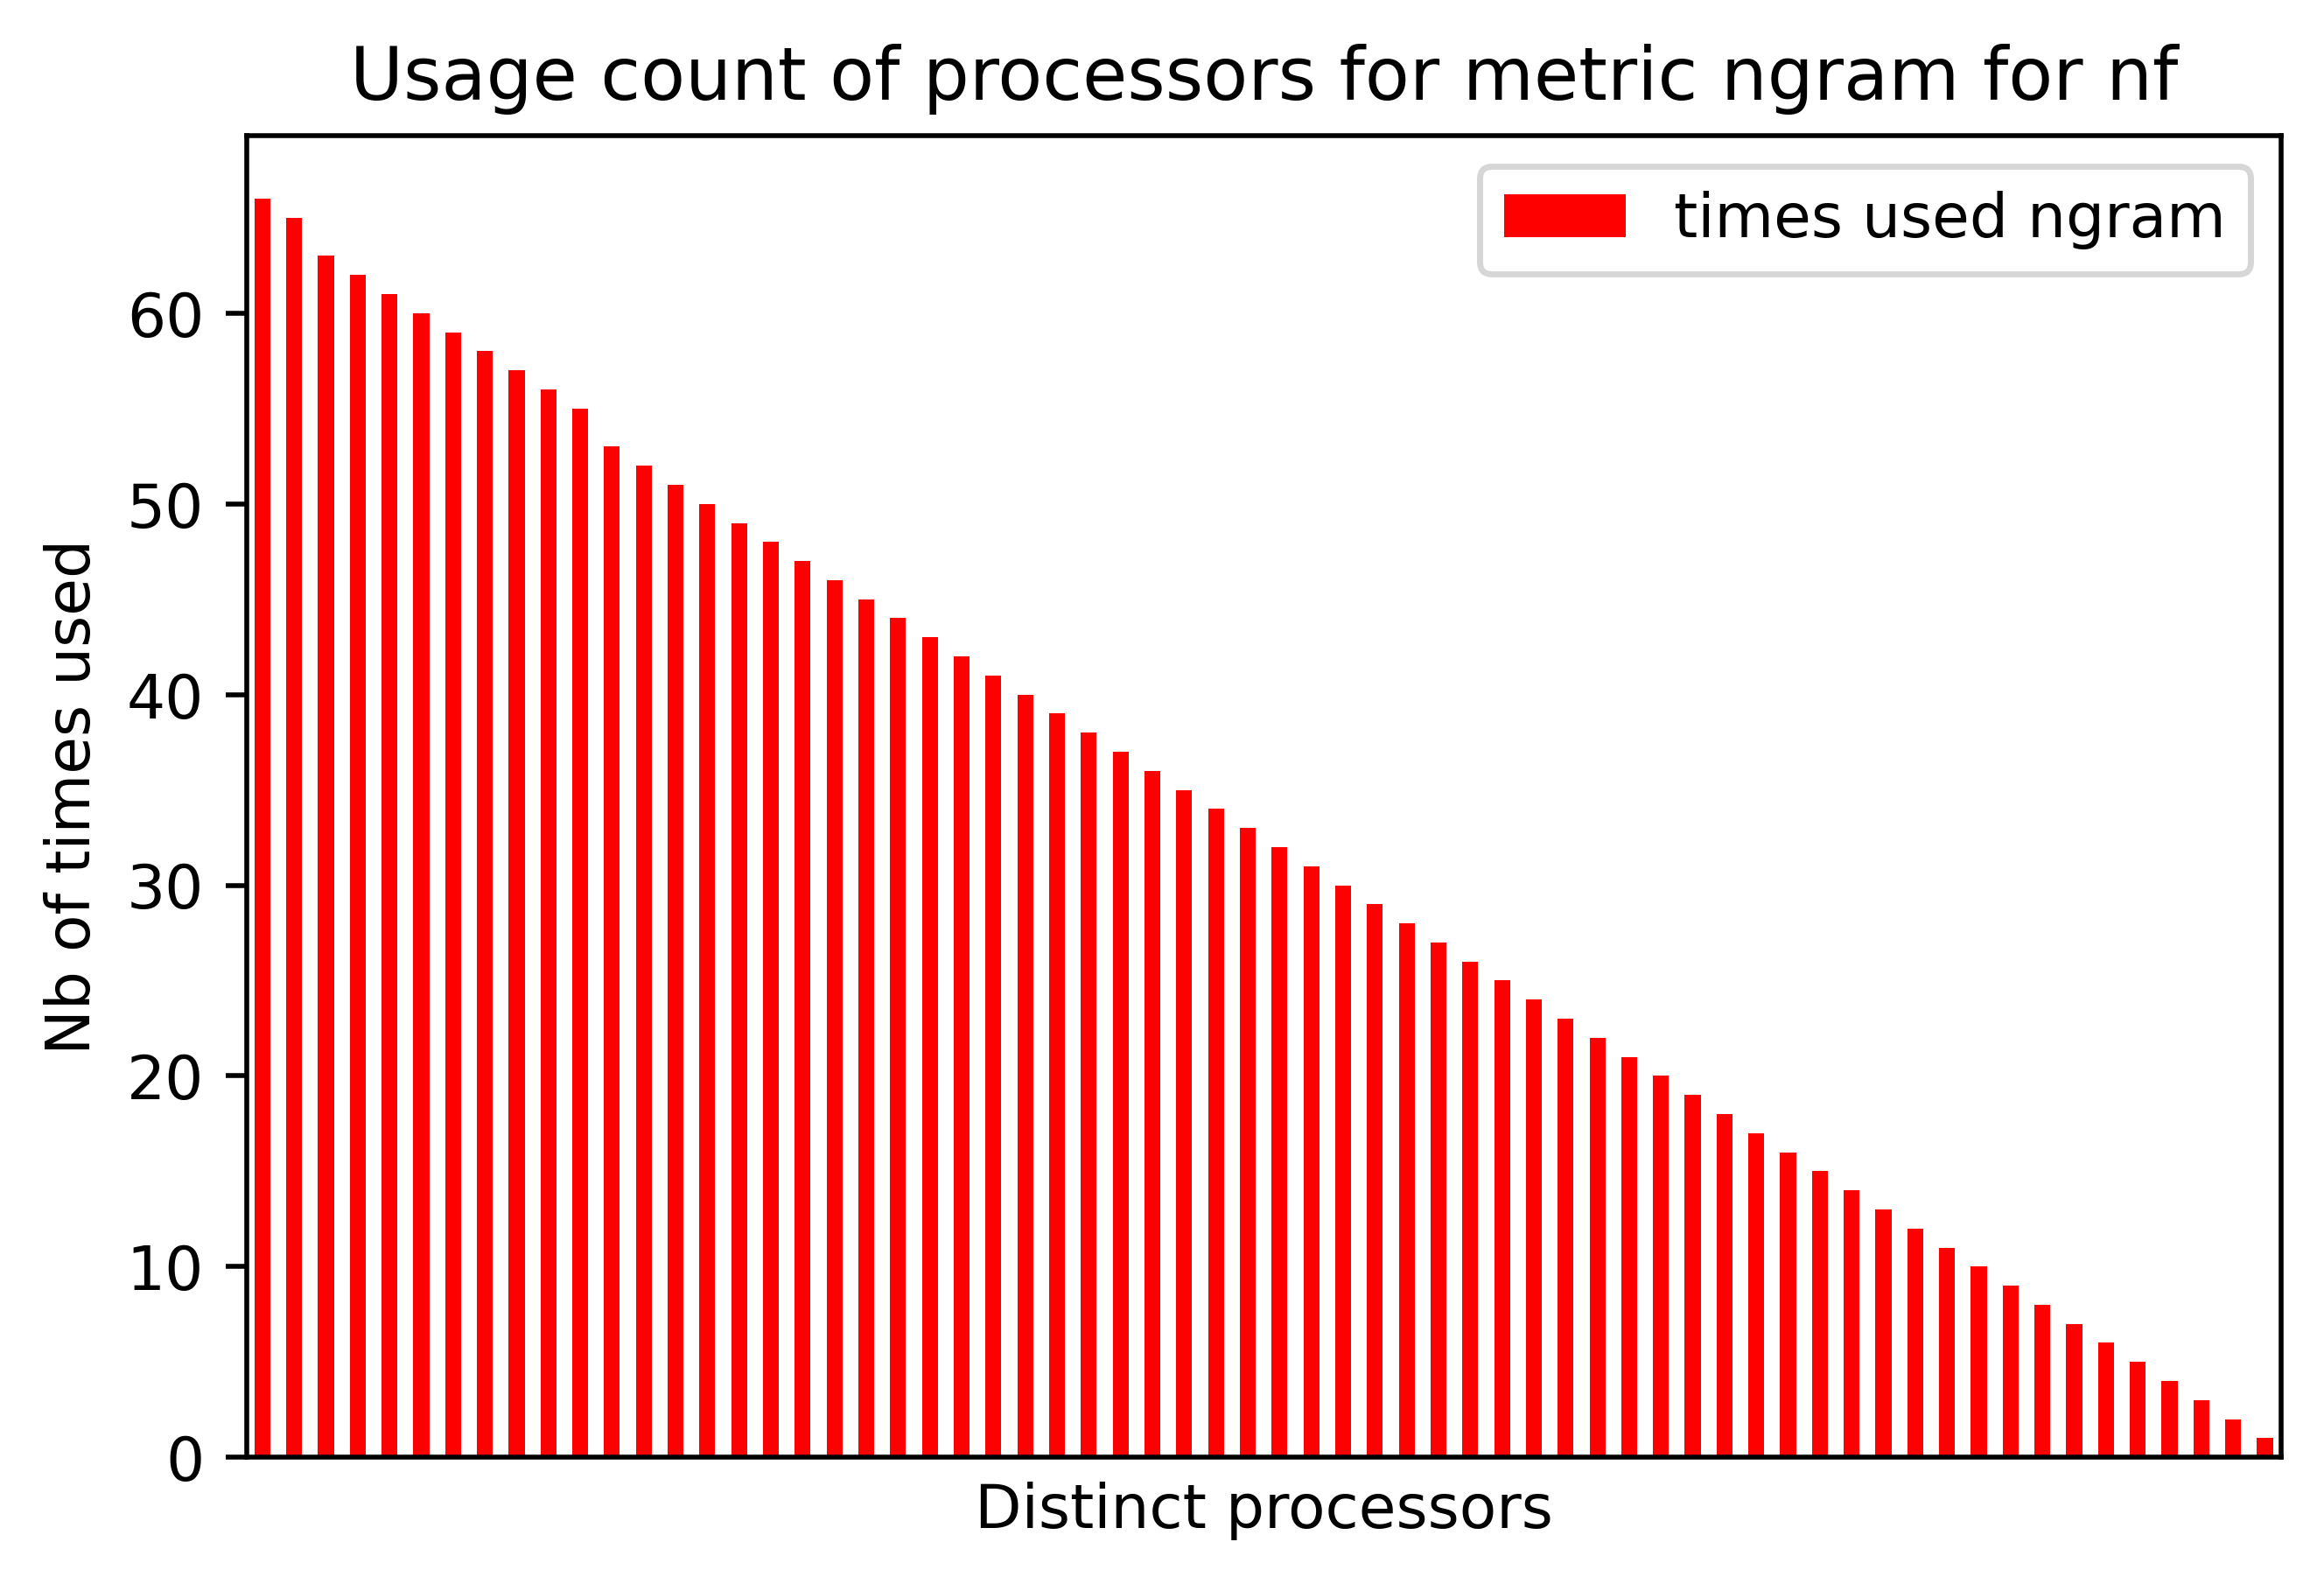

In [118]:
display_fig_stats_metric(df_nf_ngram,"nf",'ngram')

## Zoom sur la réutilisation de nf-core

On cherche à savoir comment les process nf-core sont réutilisés :
* au sein de nf-core
* dans tous les workflows nf non nf-core


In [140]:
def make_df_tot_nfc(df_ngram,df_lev,metric):
    df_lev["prop_proc_lev"]=df_lev["prop_proc"]
    df_ngram["prop_proc_ngram"]=df_ngram["prop_proc"]
    df_tot = pd.merge(df_ngram[[metric,"prop_proc_ngram"]], df_lev[[metric,"prop_proc_lev"]],on=metric,how="outer") 
    
    df_tot = df_tot.fillna(0)
    df_tot=df_tot.sort_values(by=[metric], ascending=True)
    return df_tot

In [147]:
def disp_fig_props_nfc(df_tot,sys,proc):
    fig = df_tot.plot(x="nb_reuse",y=["prop_proc_ngram","prop_proc_lev"], kind="bar", color = ['red','green'], label = ['ngram','lev'])
    fig.set_xticklabels(fig.get_xticklabels(), rotation=80, size=5)
    fig.set_xlabel("Number of times used with the metric 'levenshtein' and the metric 'ngram' by "+sys)
    fig.set_ylabel('Percent of '+proc)
    fig.legend(loc='best')
    fig.set_yscale('log')
    plt.show()
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return fig

In [134]:
def disp_fig_props_wf_nfc(df_tot,sys):
    fig = df_tot.plot(x="nb_wf",y=["prop_proc_ngram","prop_proc_lev"], kind="bar", color = ['red','green'], label = ['ngram','lev'])
    fig.set_xticklabels(fig.get_xticklabels(), rotation=80, size=5)
    fig.set_xlabel("Number of wf used in with the metric 'levenshtein' and 'ngram' in "+sys)
    fig.set_ylabel('percent of process')
    fig.legend(loc='best')
    #fig.set_yscale('log')
    plt.show()
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return fig

In [156]:
def display_fig_stats_process_nfc(df_sim, df_sim_p, nb_proc, sys):
    df_sim_s = df_sim.sort_values(by=["nb_reuse"], ascending = False).head(nb_proc)
    df_sim_l = df_sim_p.sort_values(by=["nb_reuse"], ascending = False).head(nb_proc)
    ax = df_sim_s.plot(x='Unnamed: 0', y="nb_reuse", kind="bar", label = "times used ngram", color = "orange")
    df_sim_l.plot(x='Unnamed: 0', y="nb_reuse", ax=ax ,  kind="bar", color = "yellow", label = "times used levenshtein")
    ax.set_title('Usage count of the '+str(nb_proc)+' most used processors for metrics levenshtein and ngram in '+sys) 
    plt.xticks([])
    #ax.set_xticklabels(l, rotation=80, size=5)
    ax.set_xlabel("Distinct processors")
    ax.set_ylabel("Nb of times used")
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return ax

In [144]:
df_tot_nfc=make_df_tot_nfc(df_nf_nfc_ngram,df_nf_lev_nfc,"nb_reuse")
df_tot_non_nfc=make_df_tot_nfc(df_nf_non_nfc_ngram,df_nf_lev_non_nfc,"nb_reuse")


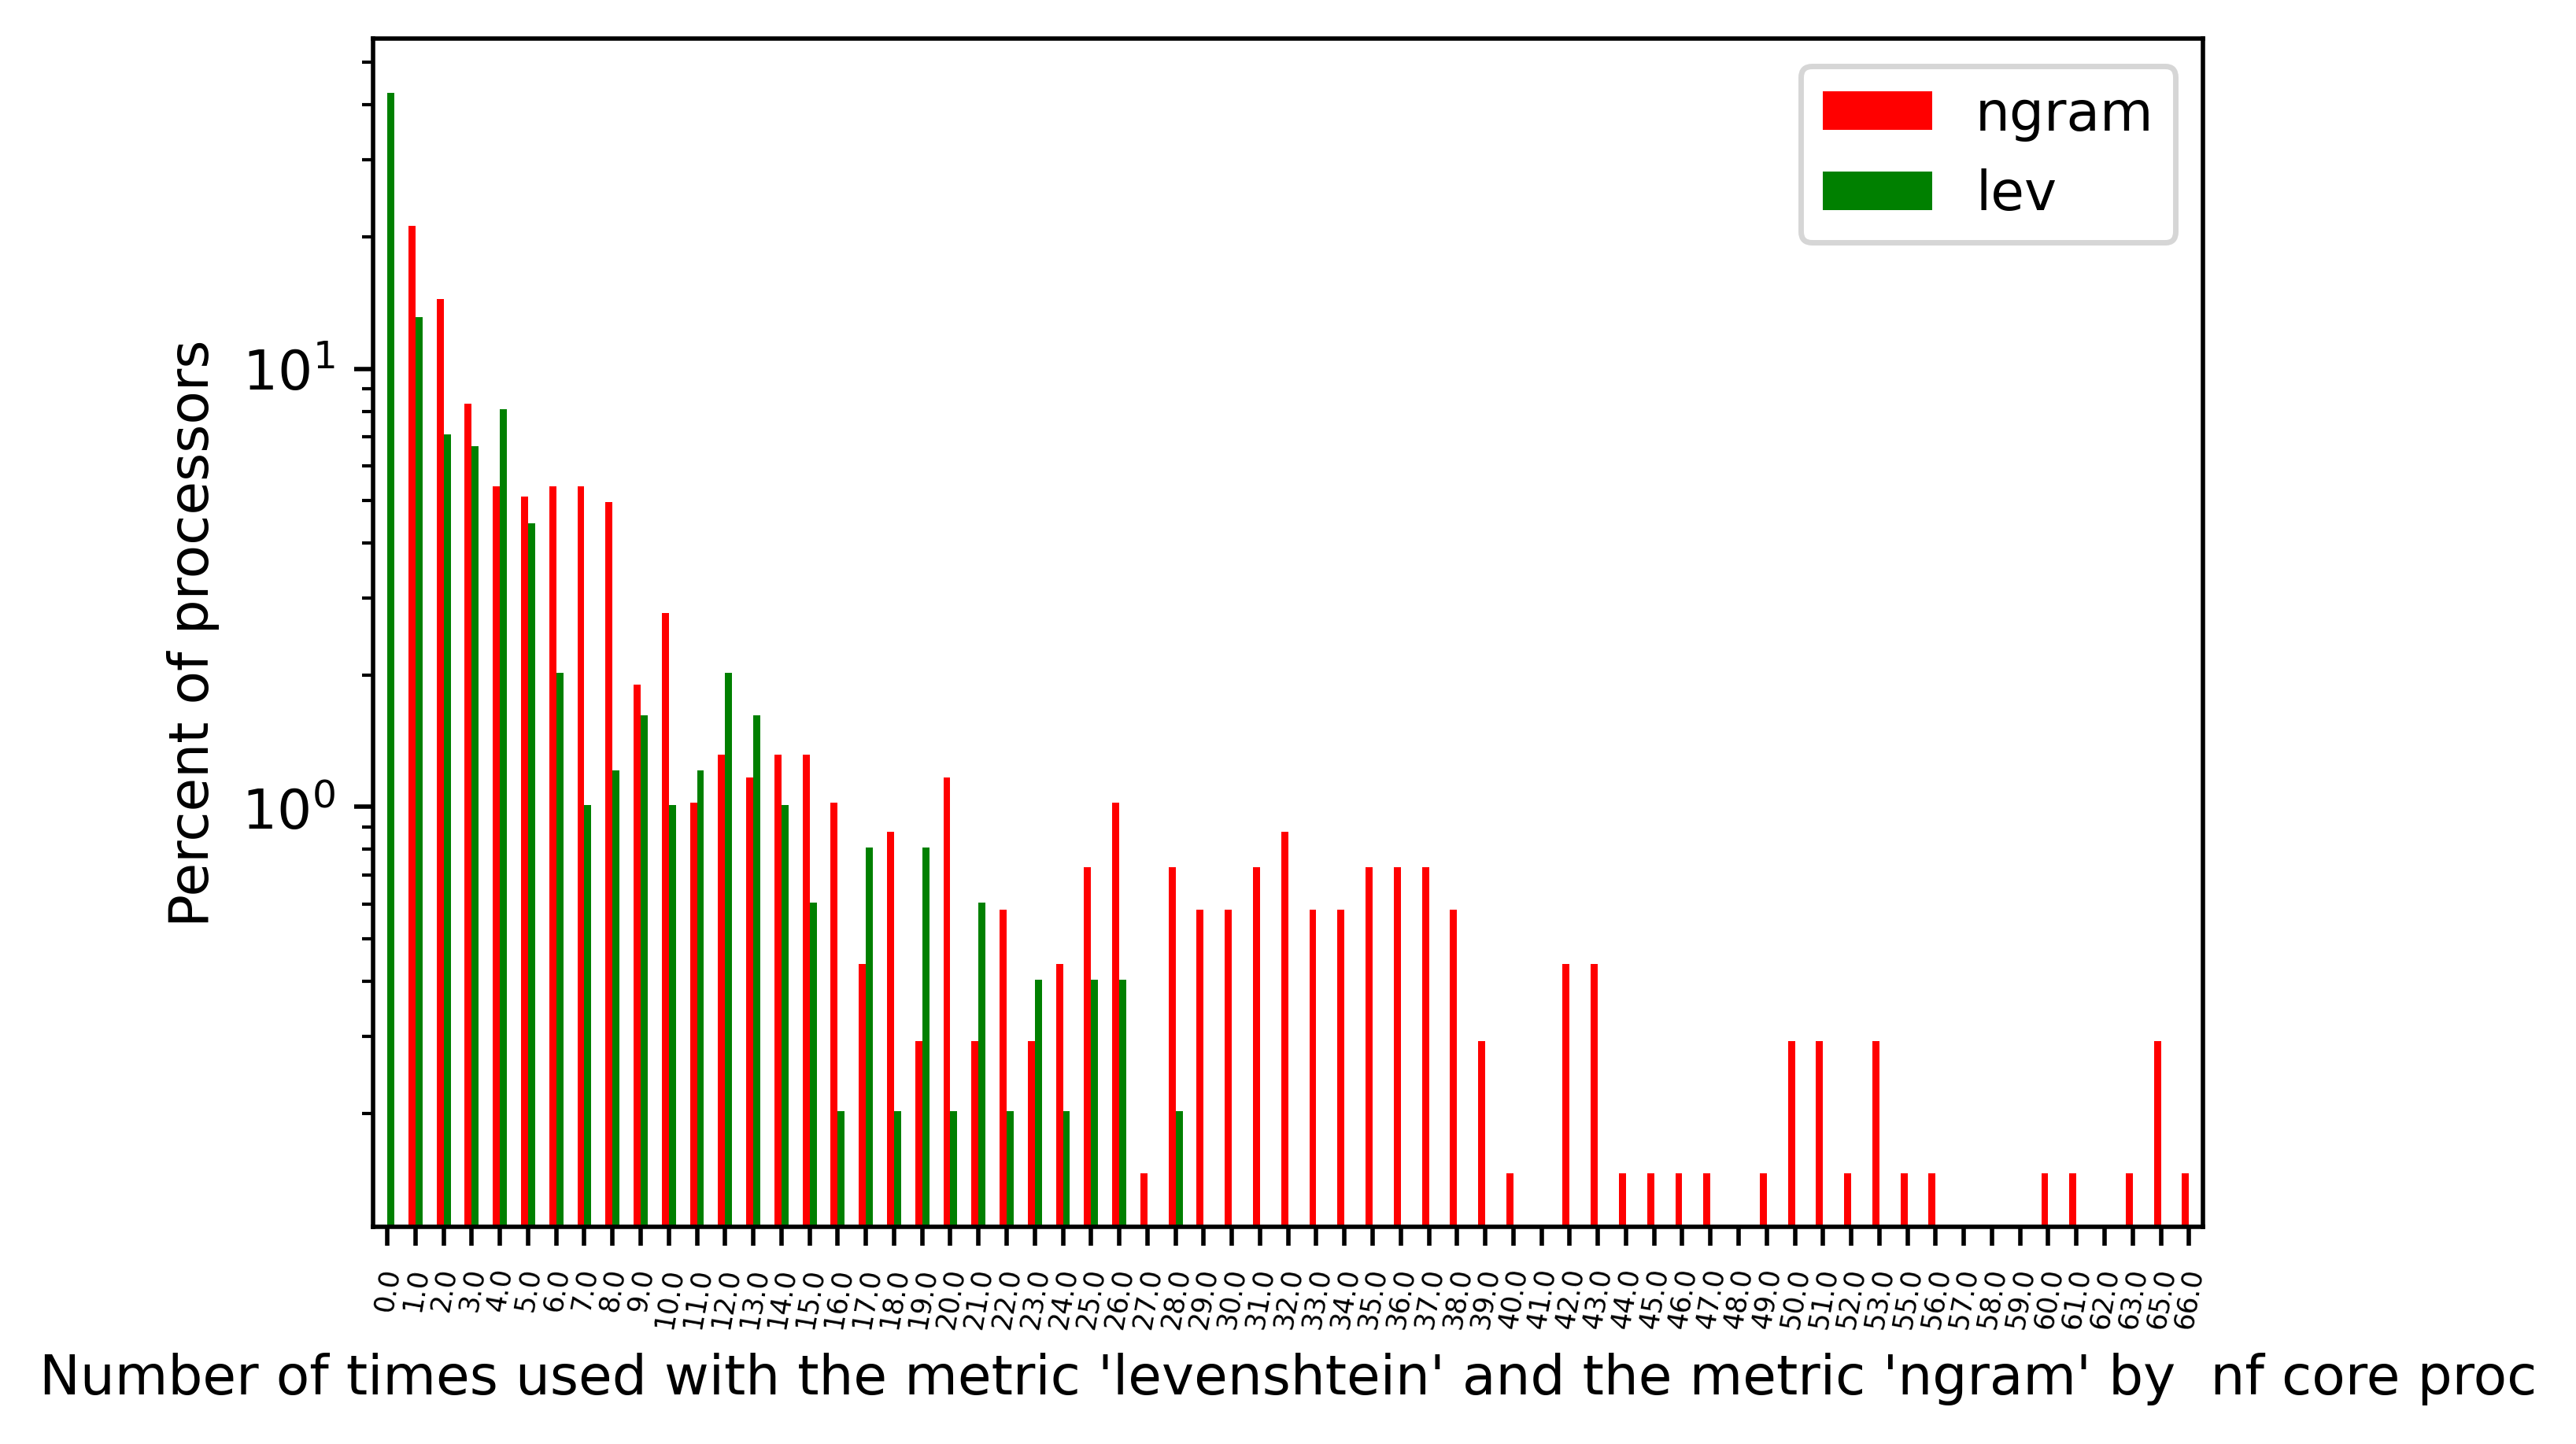

In [167]:
fig = disp_fig_props_nfc(df_tot_nfc," nf core proc","processors")

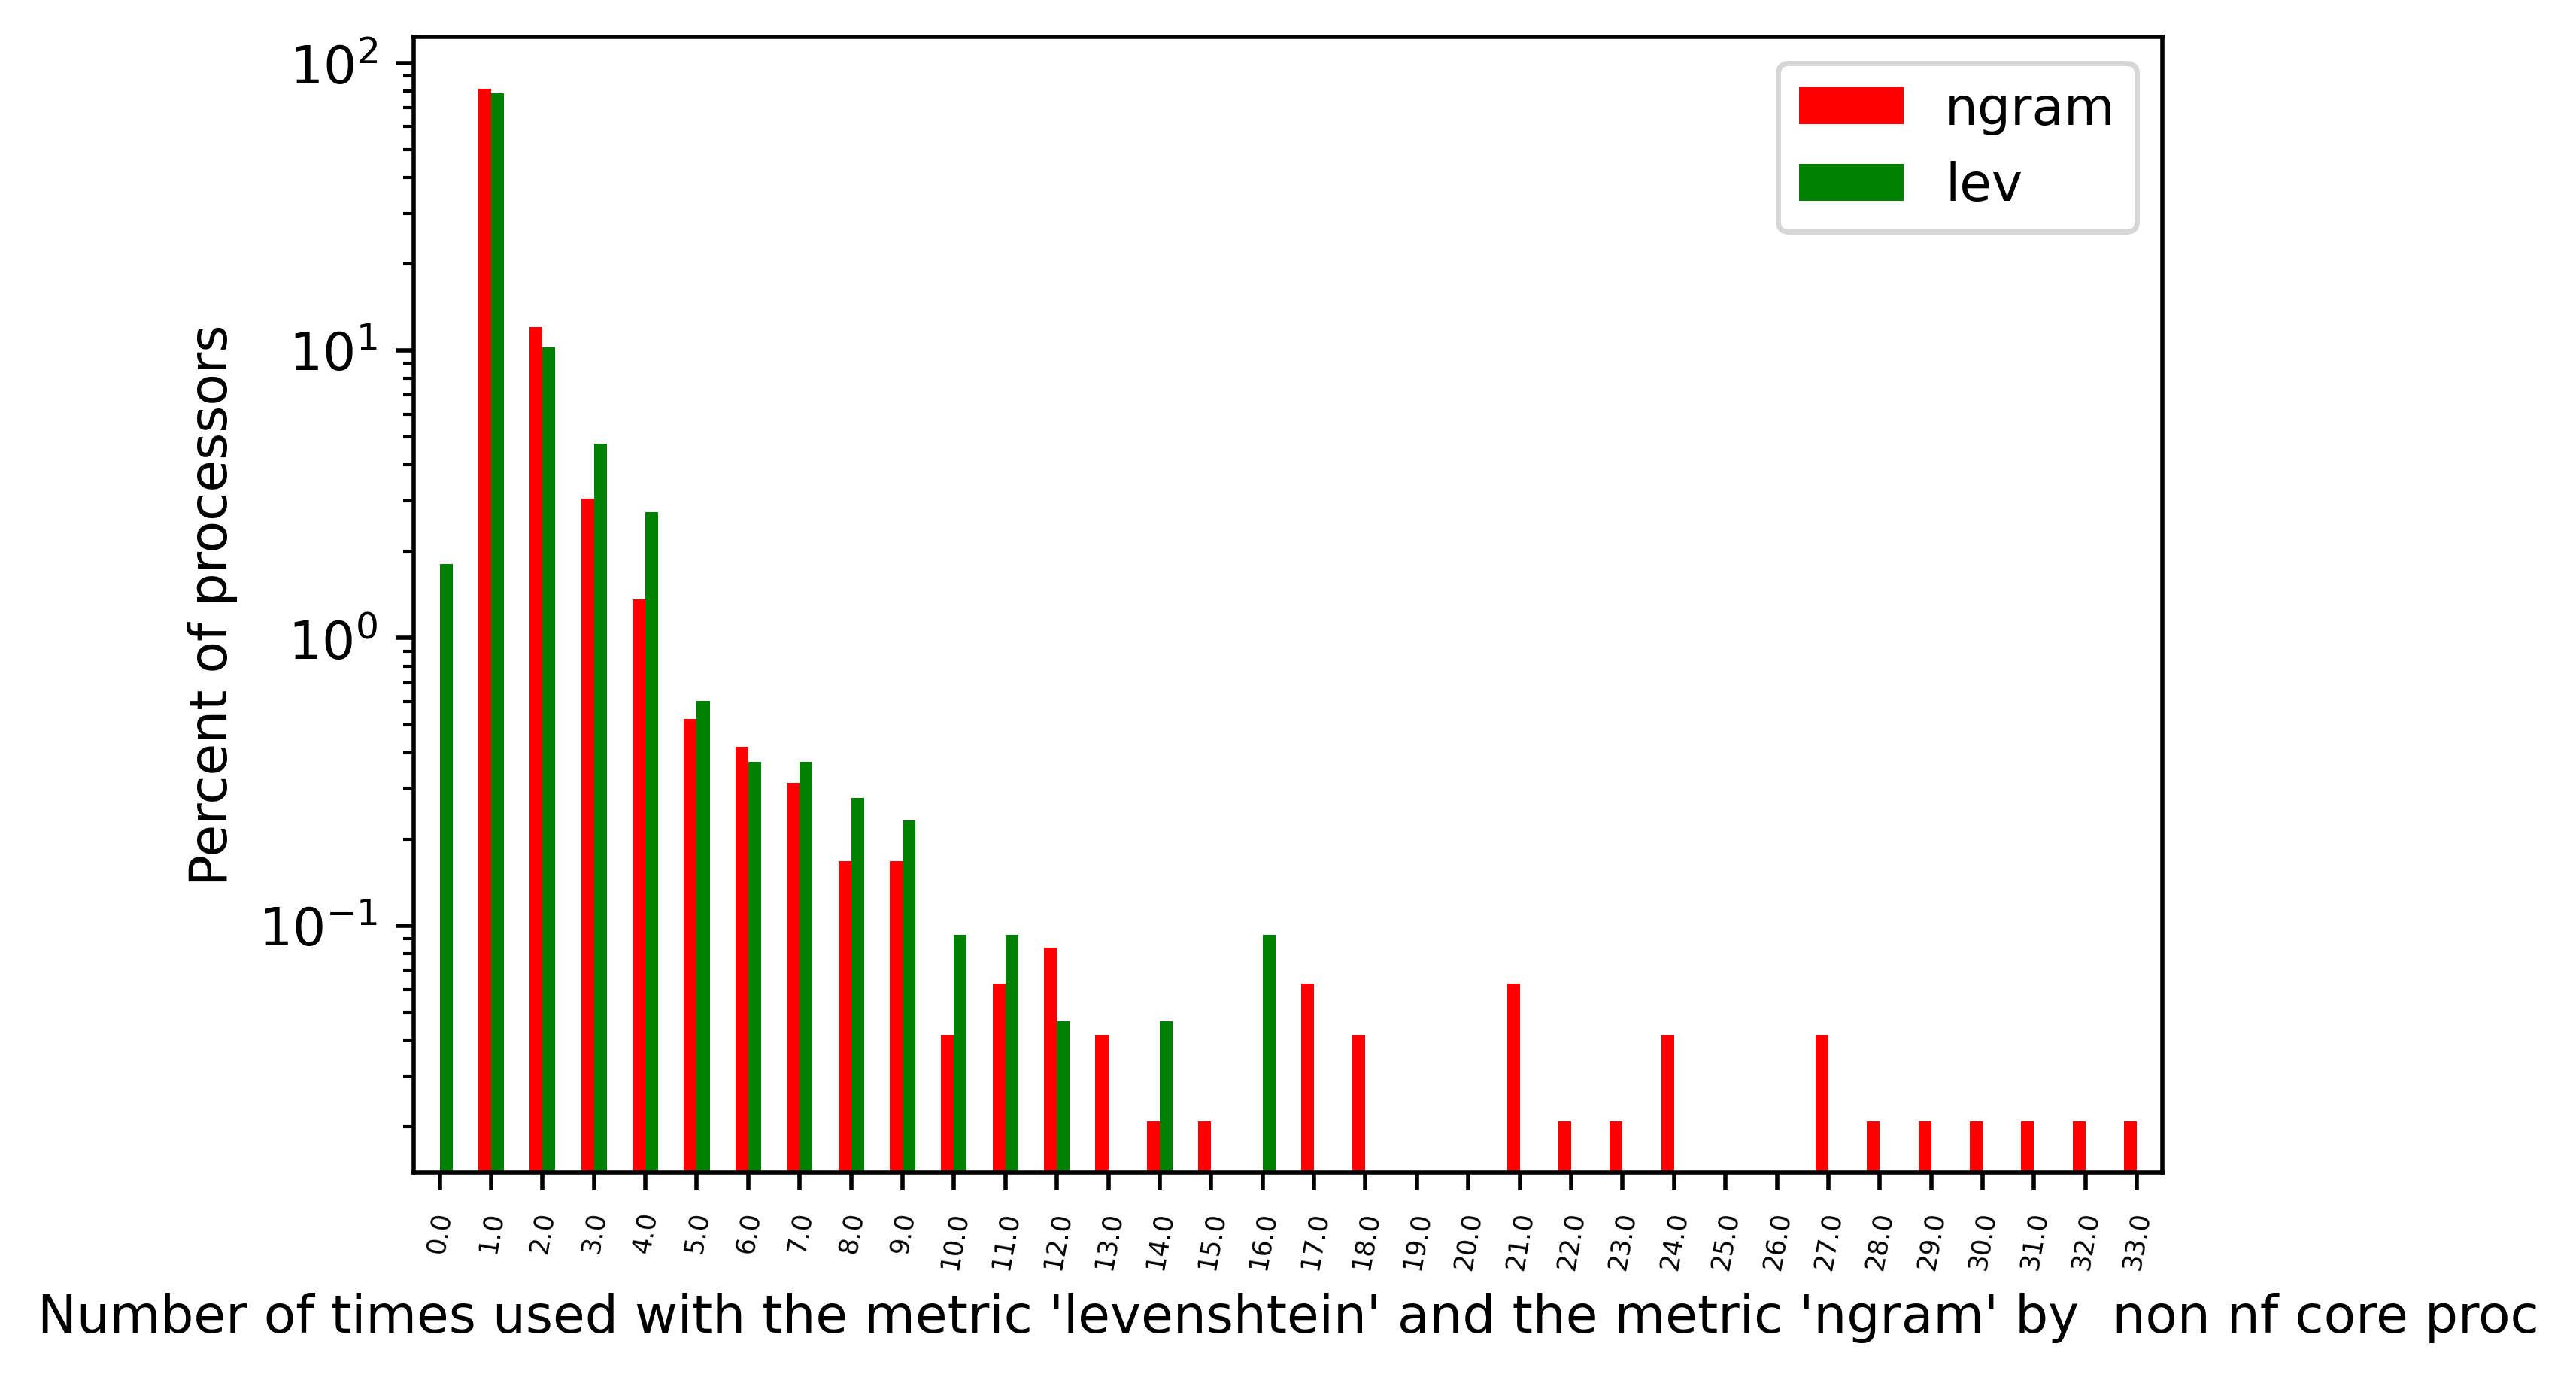

In [148]:
fig = disp_fig_props_nfc(df_tot_non_nfc," non nf core proc","processors")

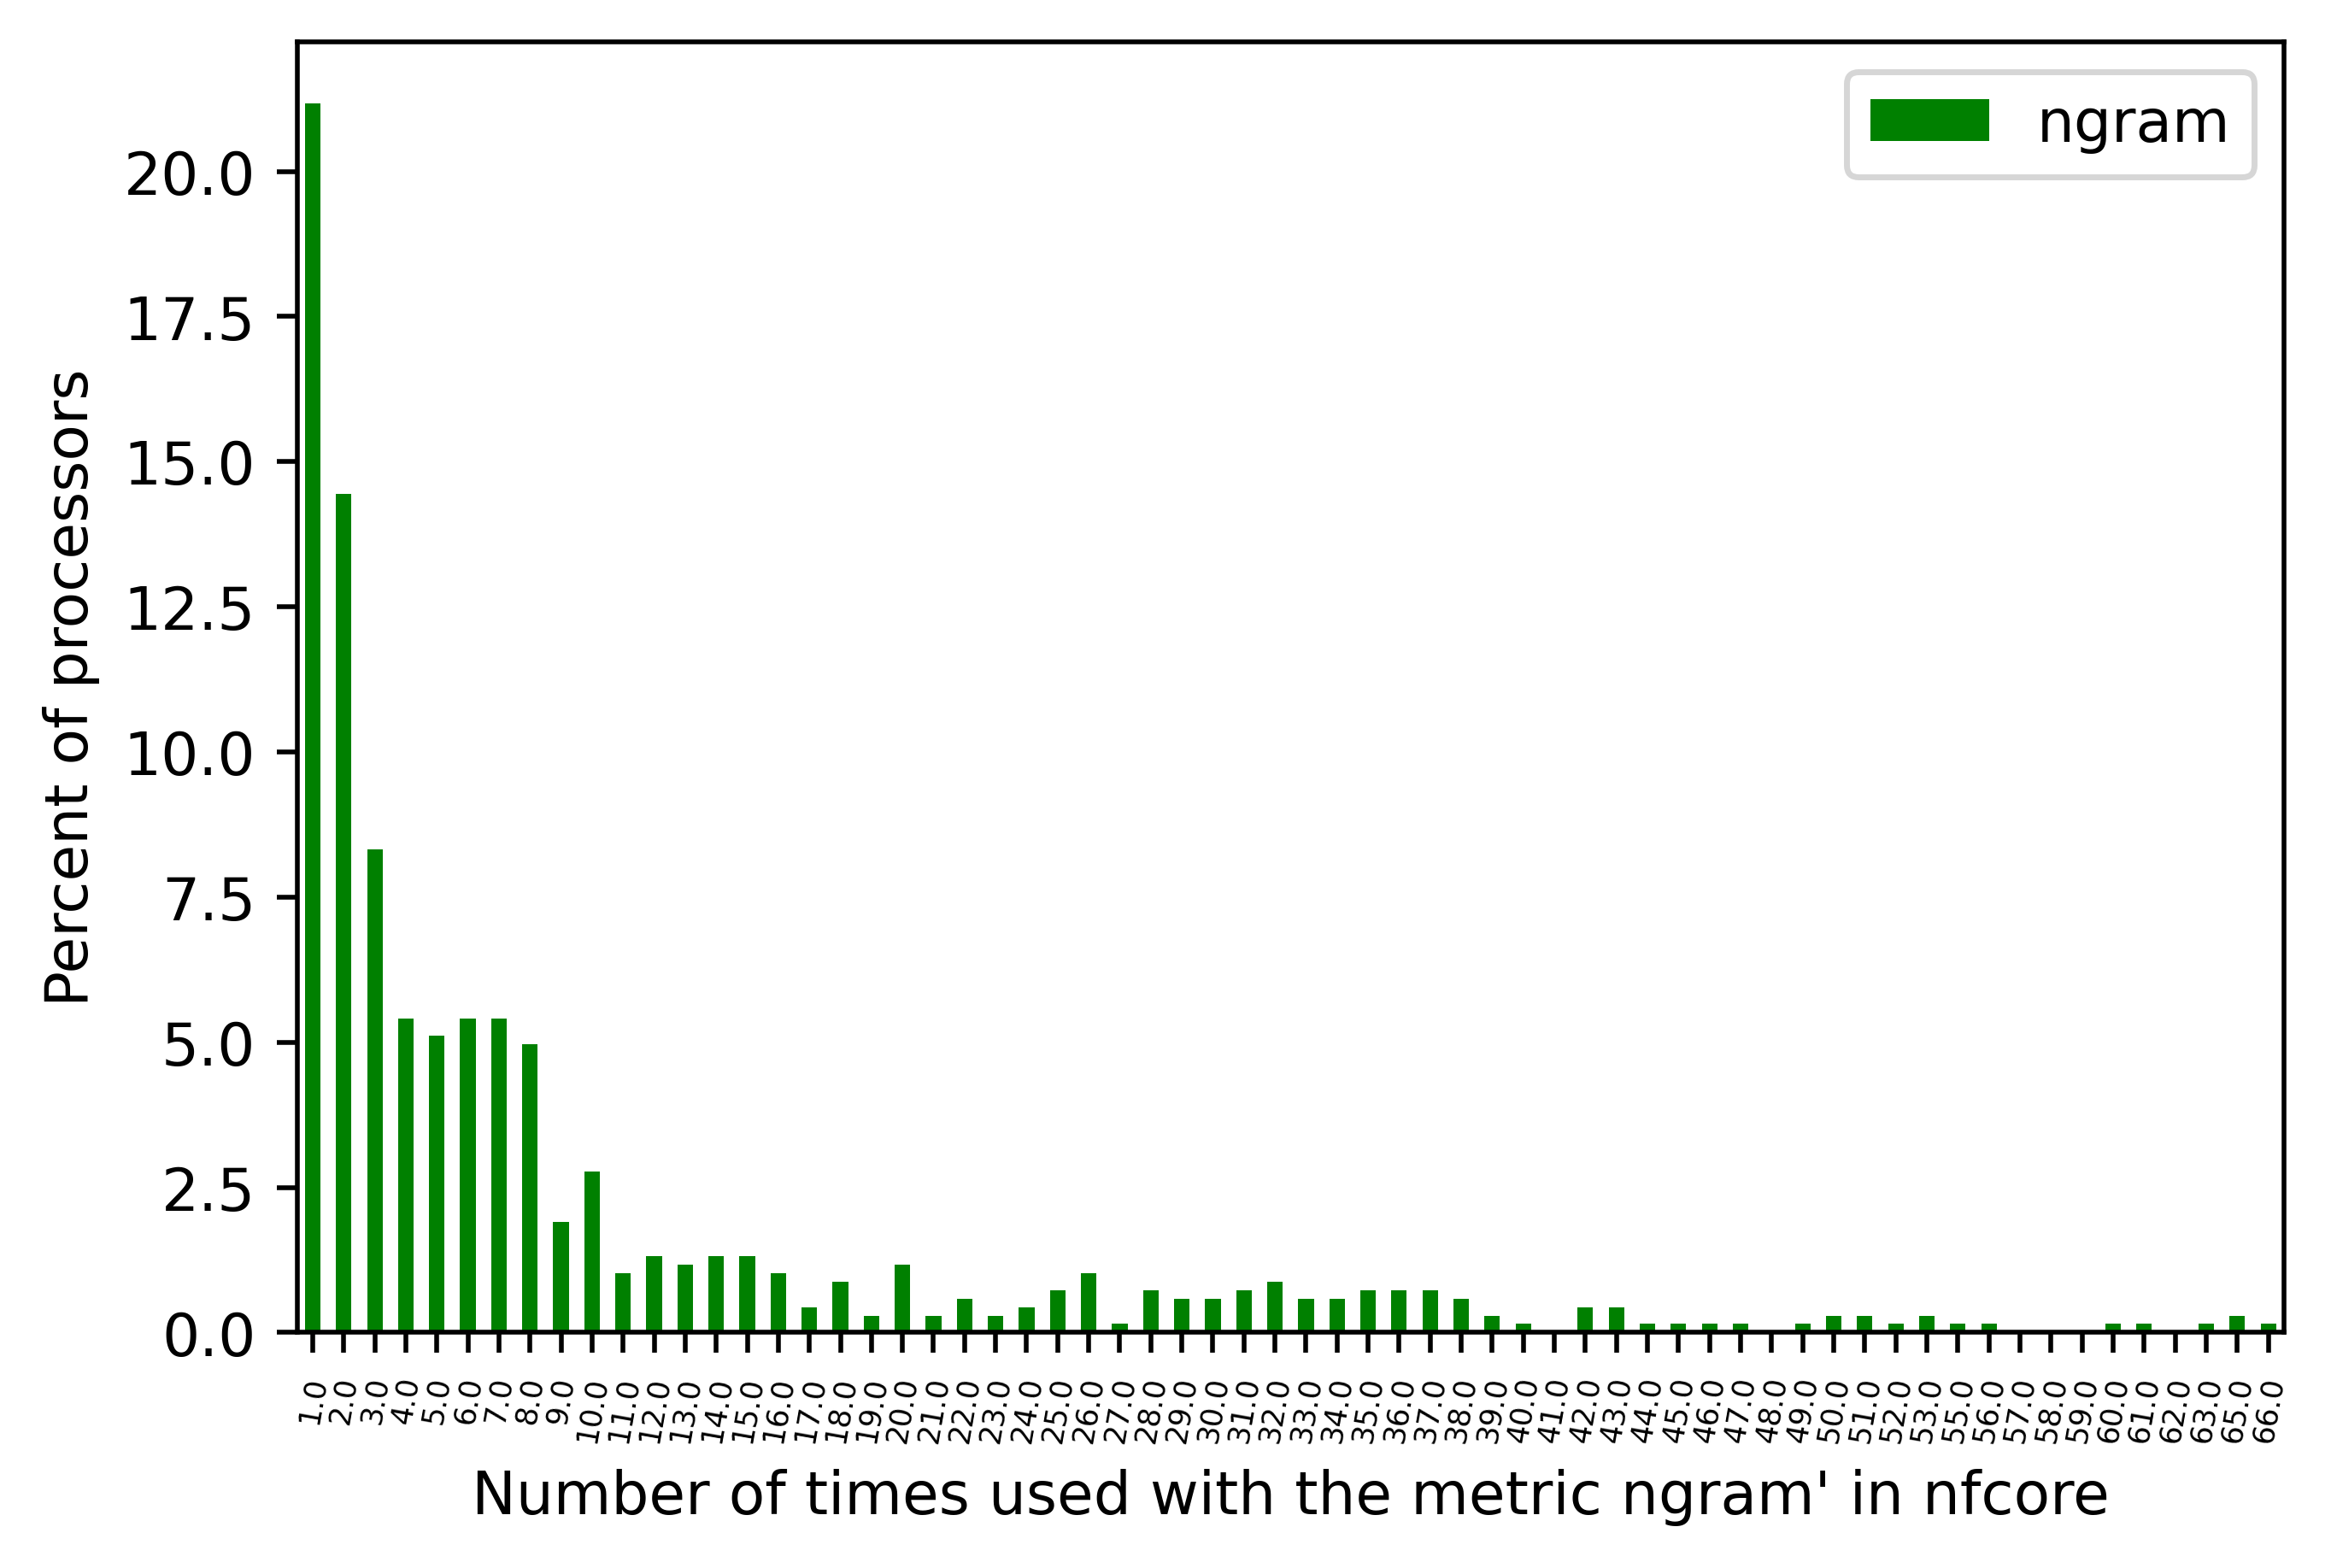

In [150]:
fig = disp_single_metric(df_nf_nfc_ngram,"nb_reuse","nfcore","ngram")

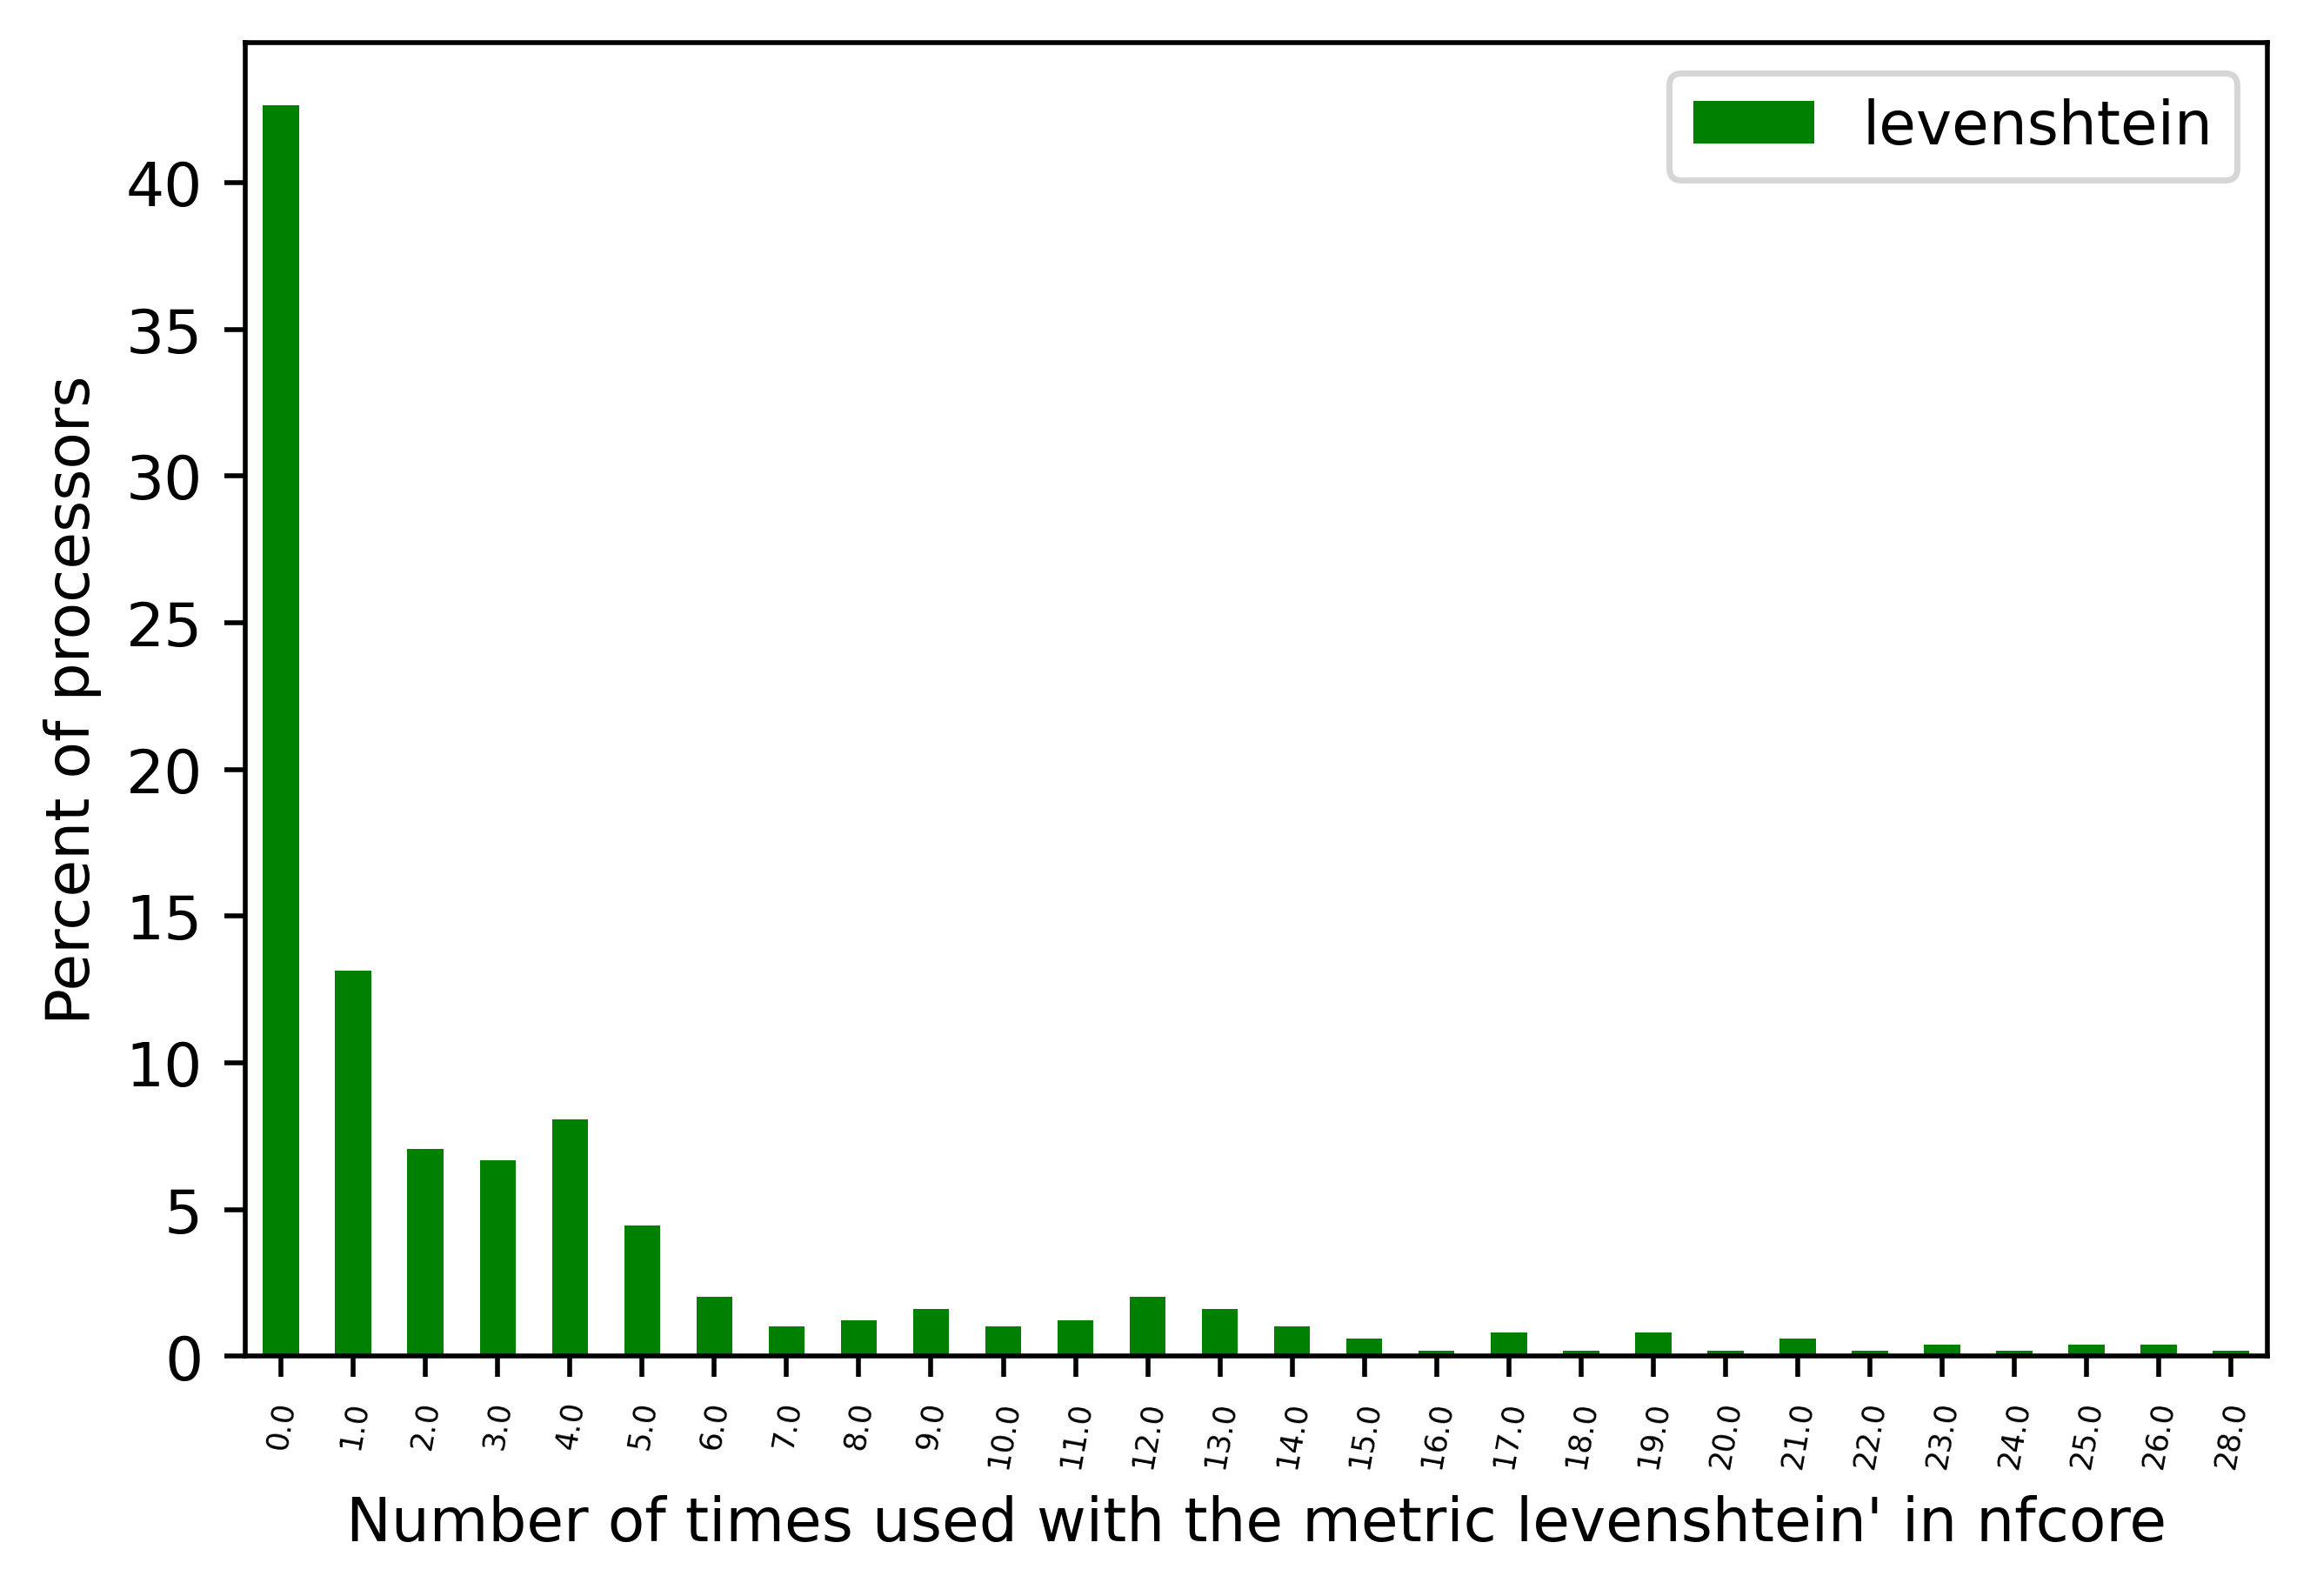

In [149]:
fig = disp_single_metric(df_nf_lev_nfc,"nb_reuse","nfcore","levenshtein")

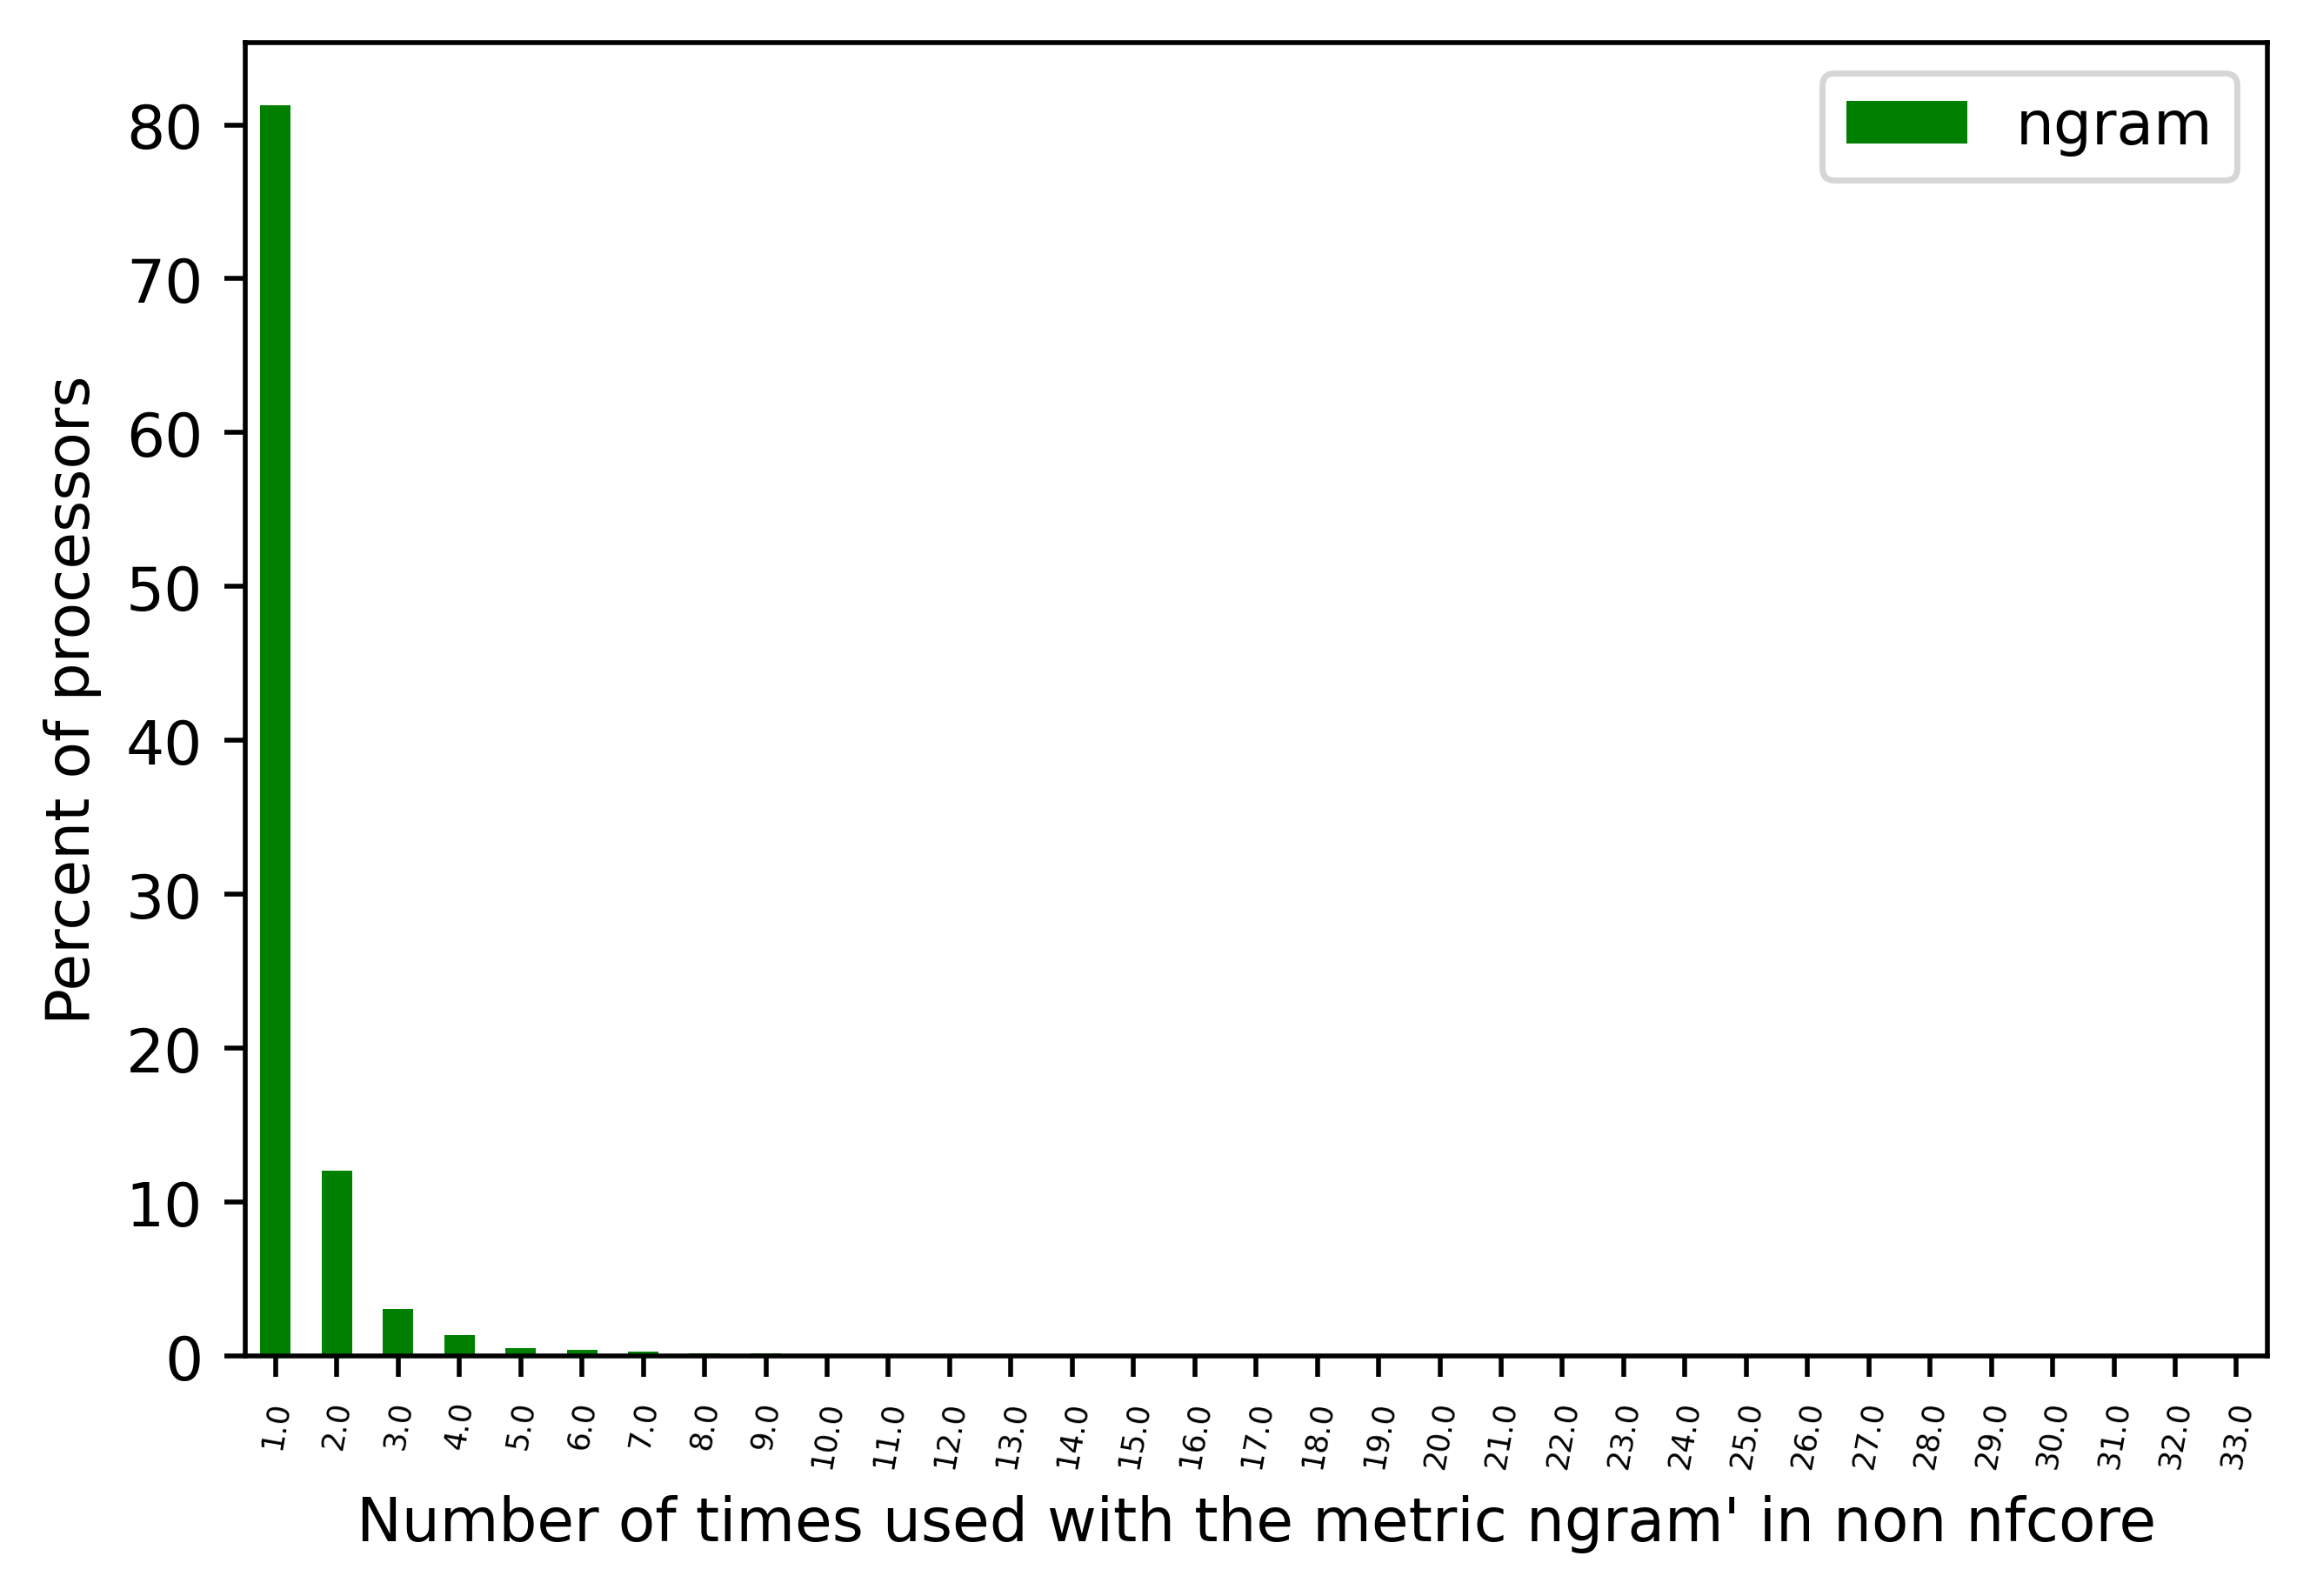

In [152]:
fig = disp_single_metric(df_nf_non_nfc_ngram,"nb_reuse","non nfcore","ngram")

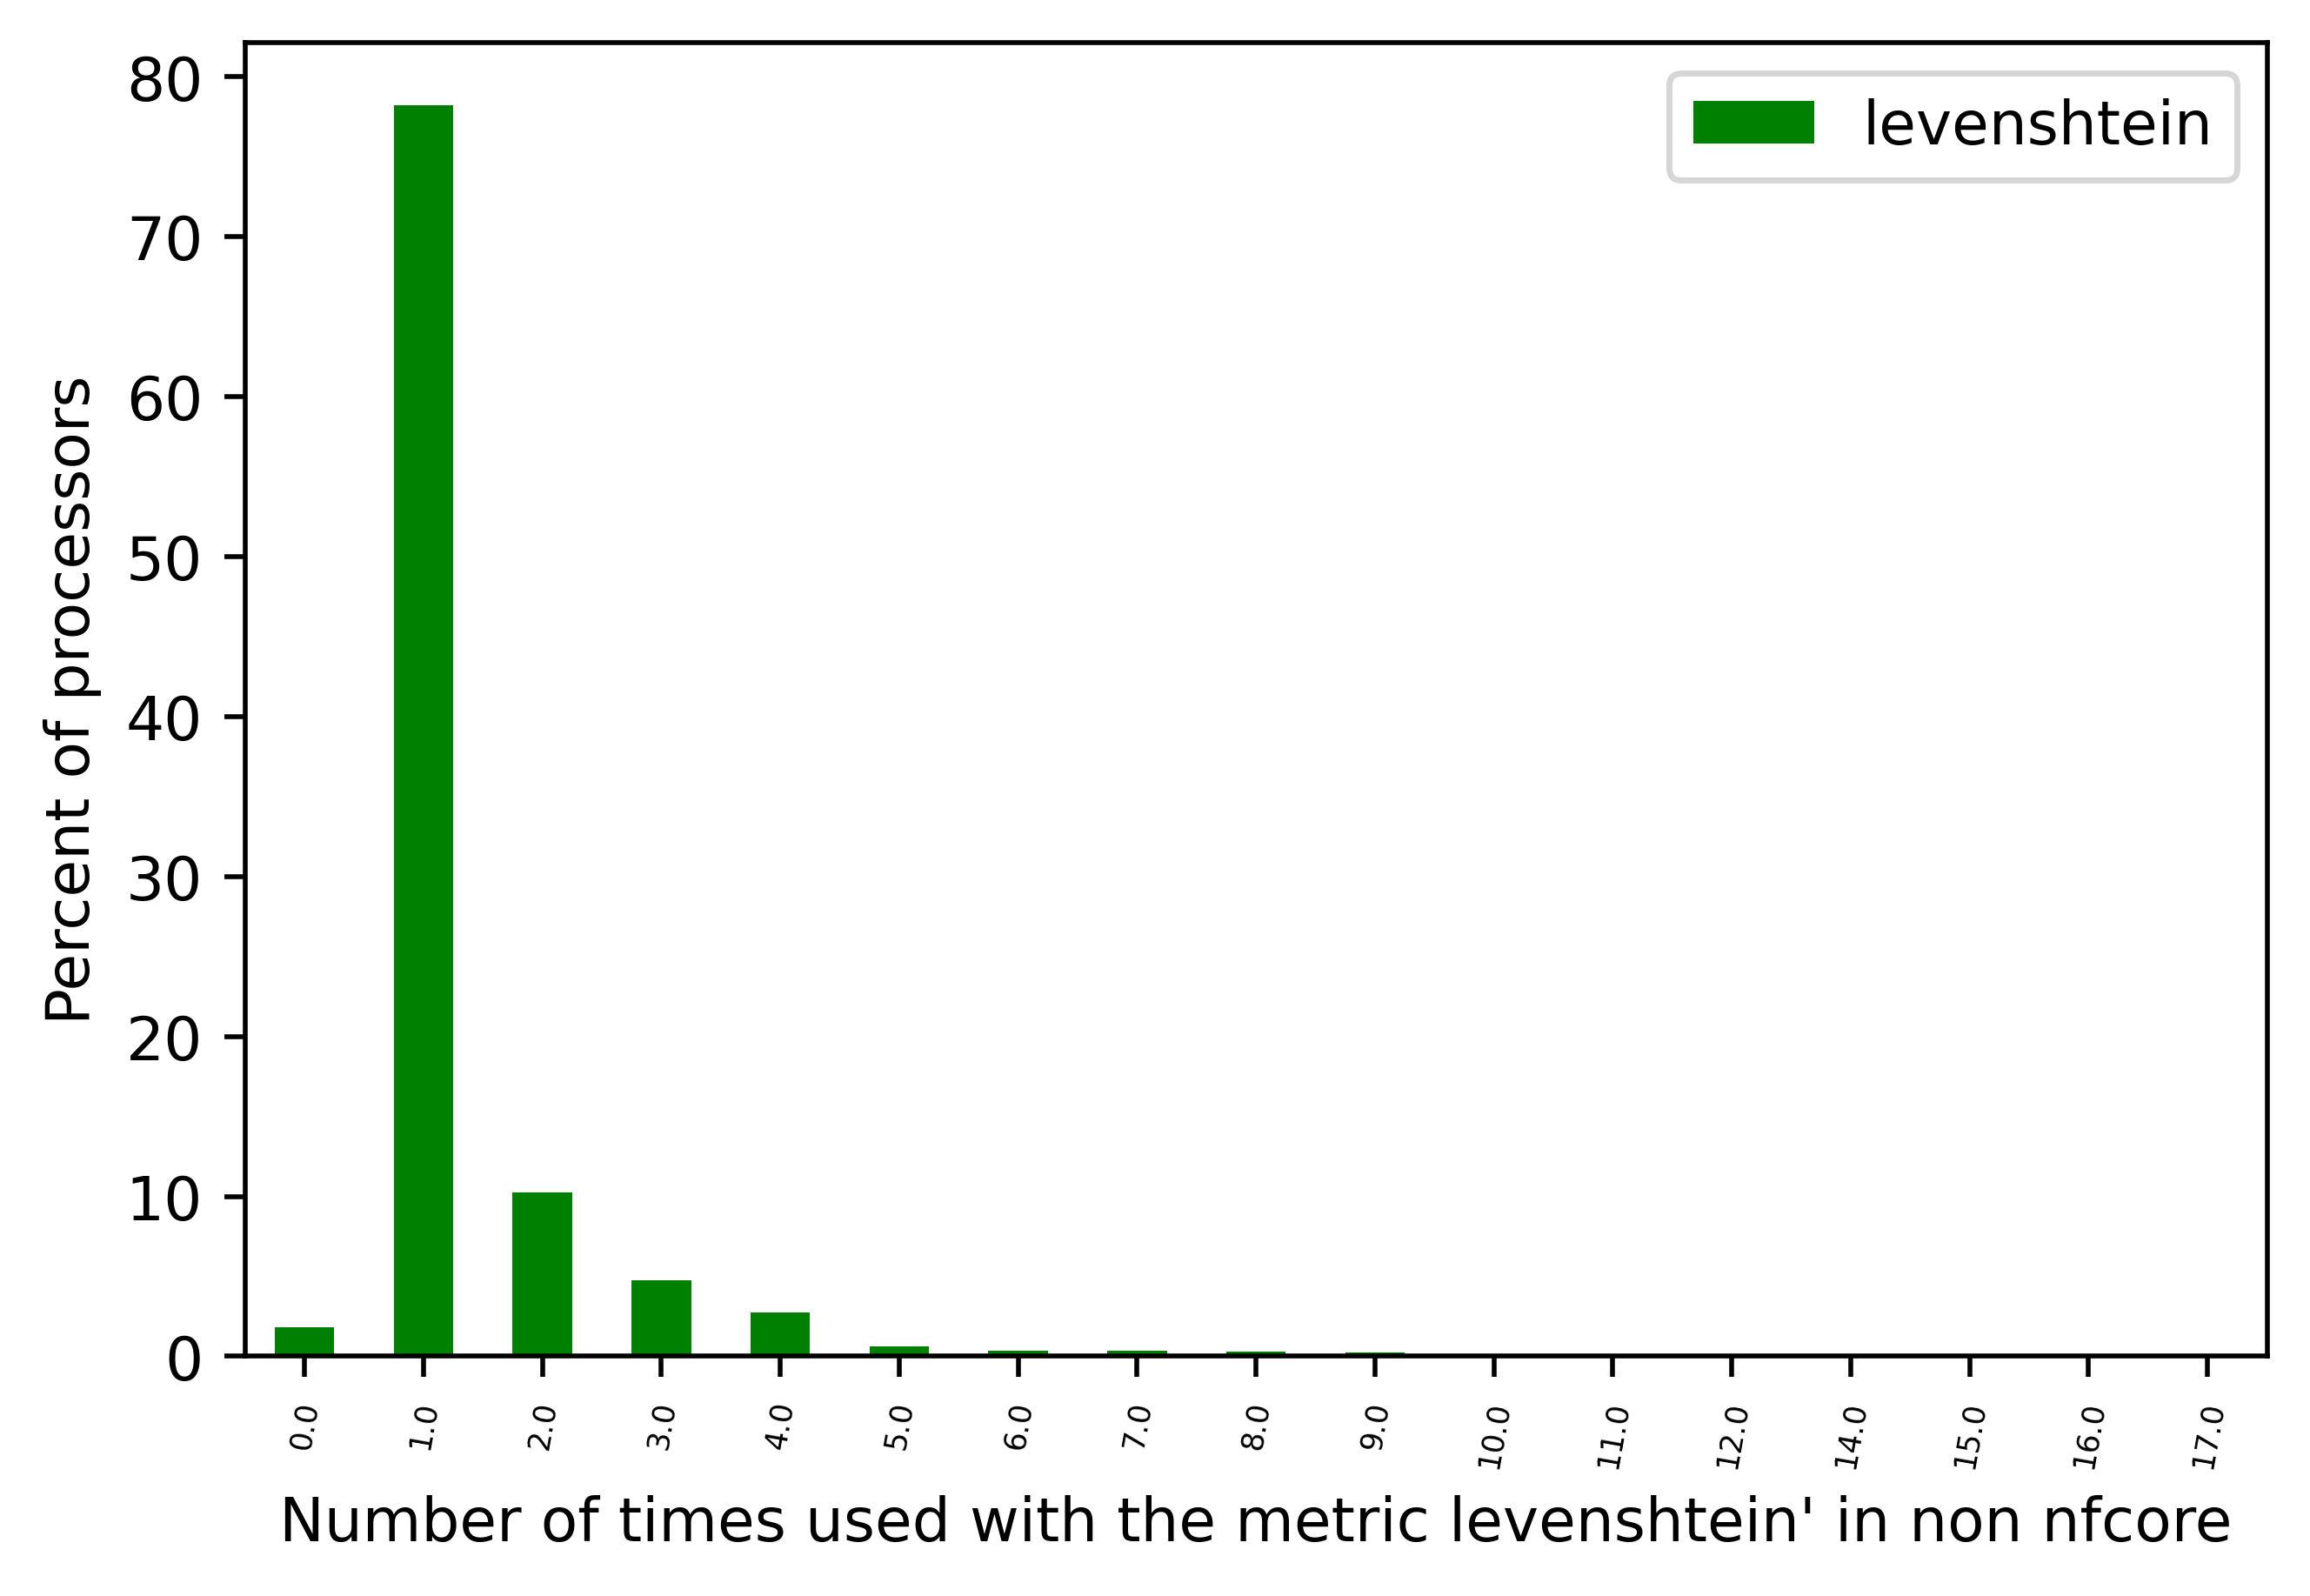

In [151]:
fig = disp_single_metric(df_nf_lev_non_nfc,"nb_reuse","non nfcore","levenshtein")

<AxesSubplot:title={'center':'Usage count of the 100 most used processors for metrics levenshtein and ngram in nfc'}, xlabel='Distinct processors', ylabel='Nb of times used'>

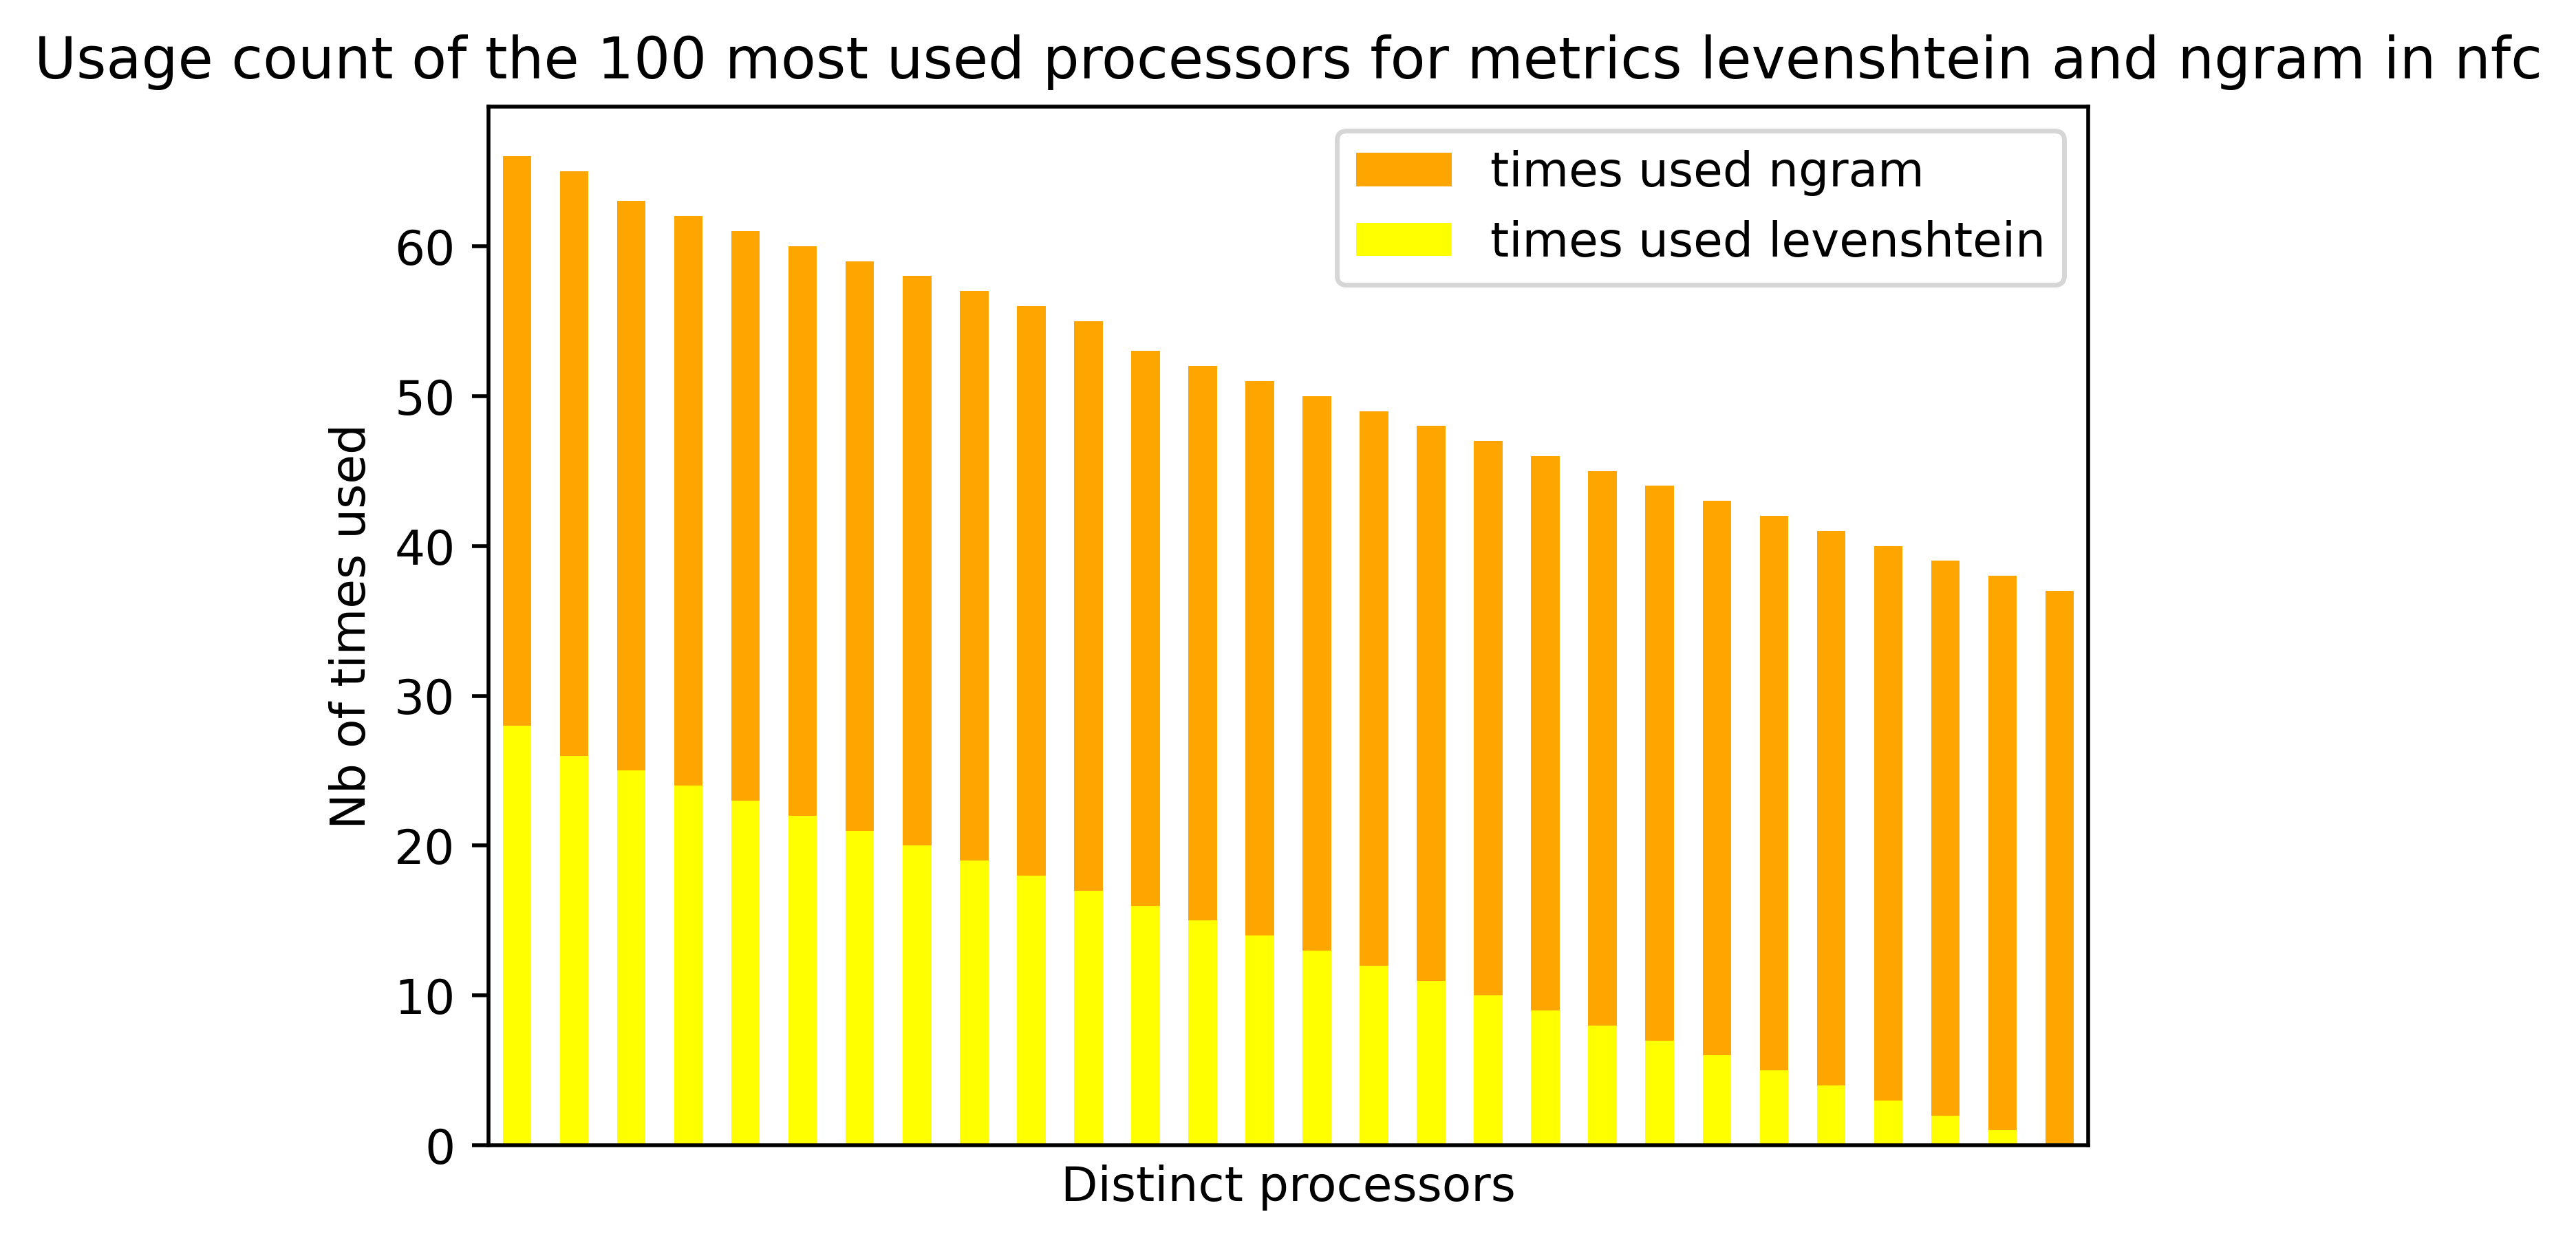

In [160]:
display_fig_stats_process_nfc(df_nf_nfc_ngram,df_nf_lev_nfc, 100, "nfc")

<AxesSubplot:title={'center':'Usage count of the 100 most used processors for metrics levenshtein and ngram in non fc'}, xlabel='Distinct processors', ylabel='Nb of times used'>

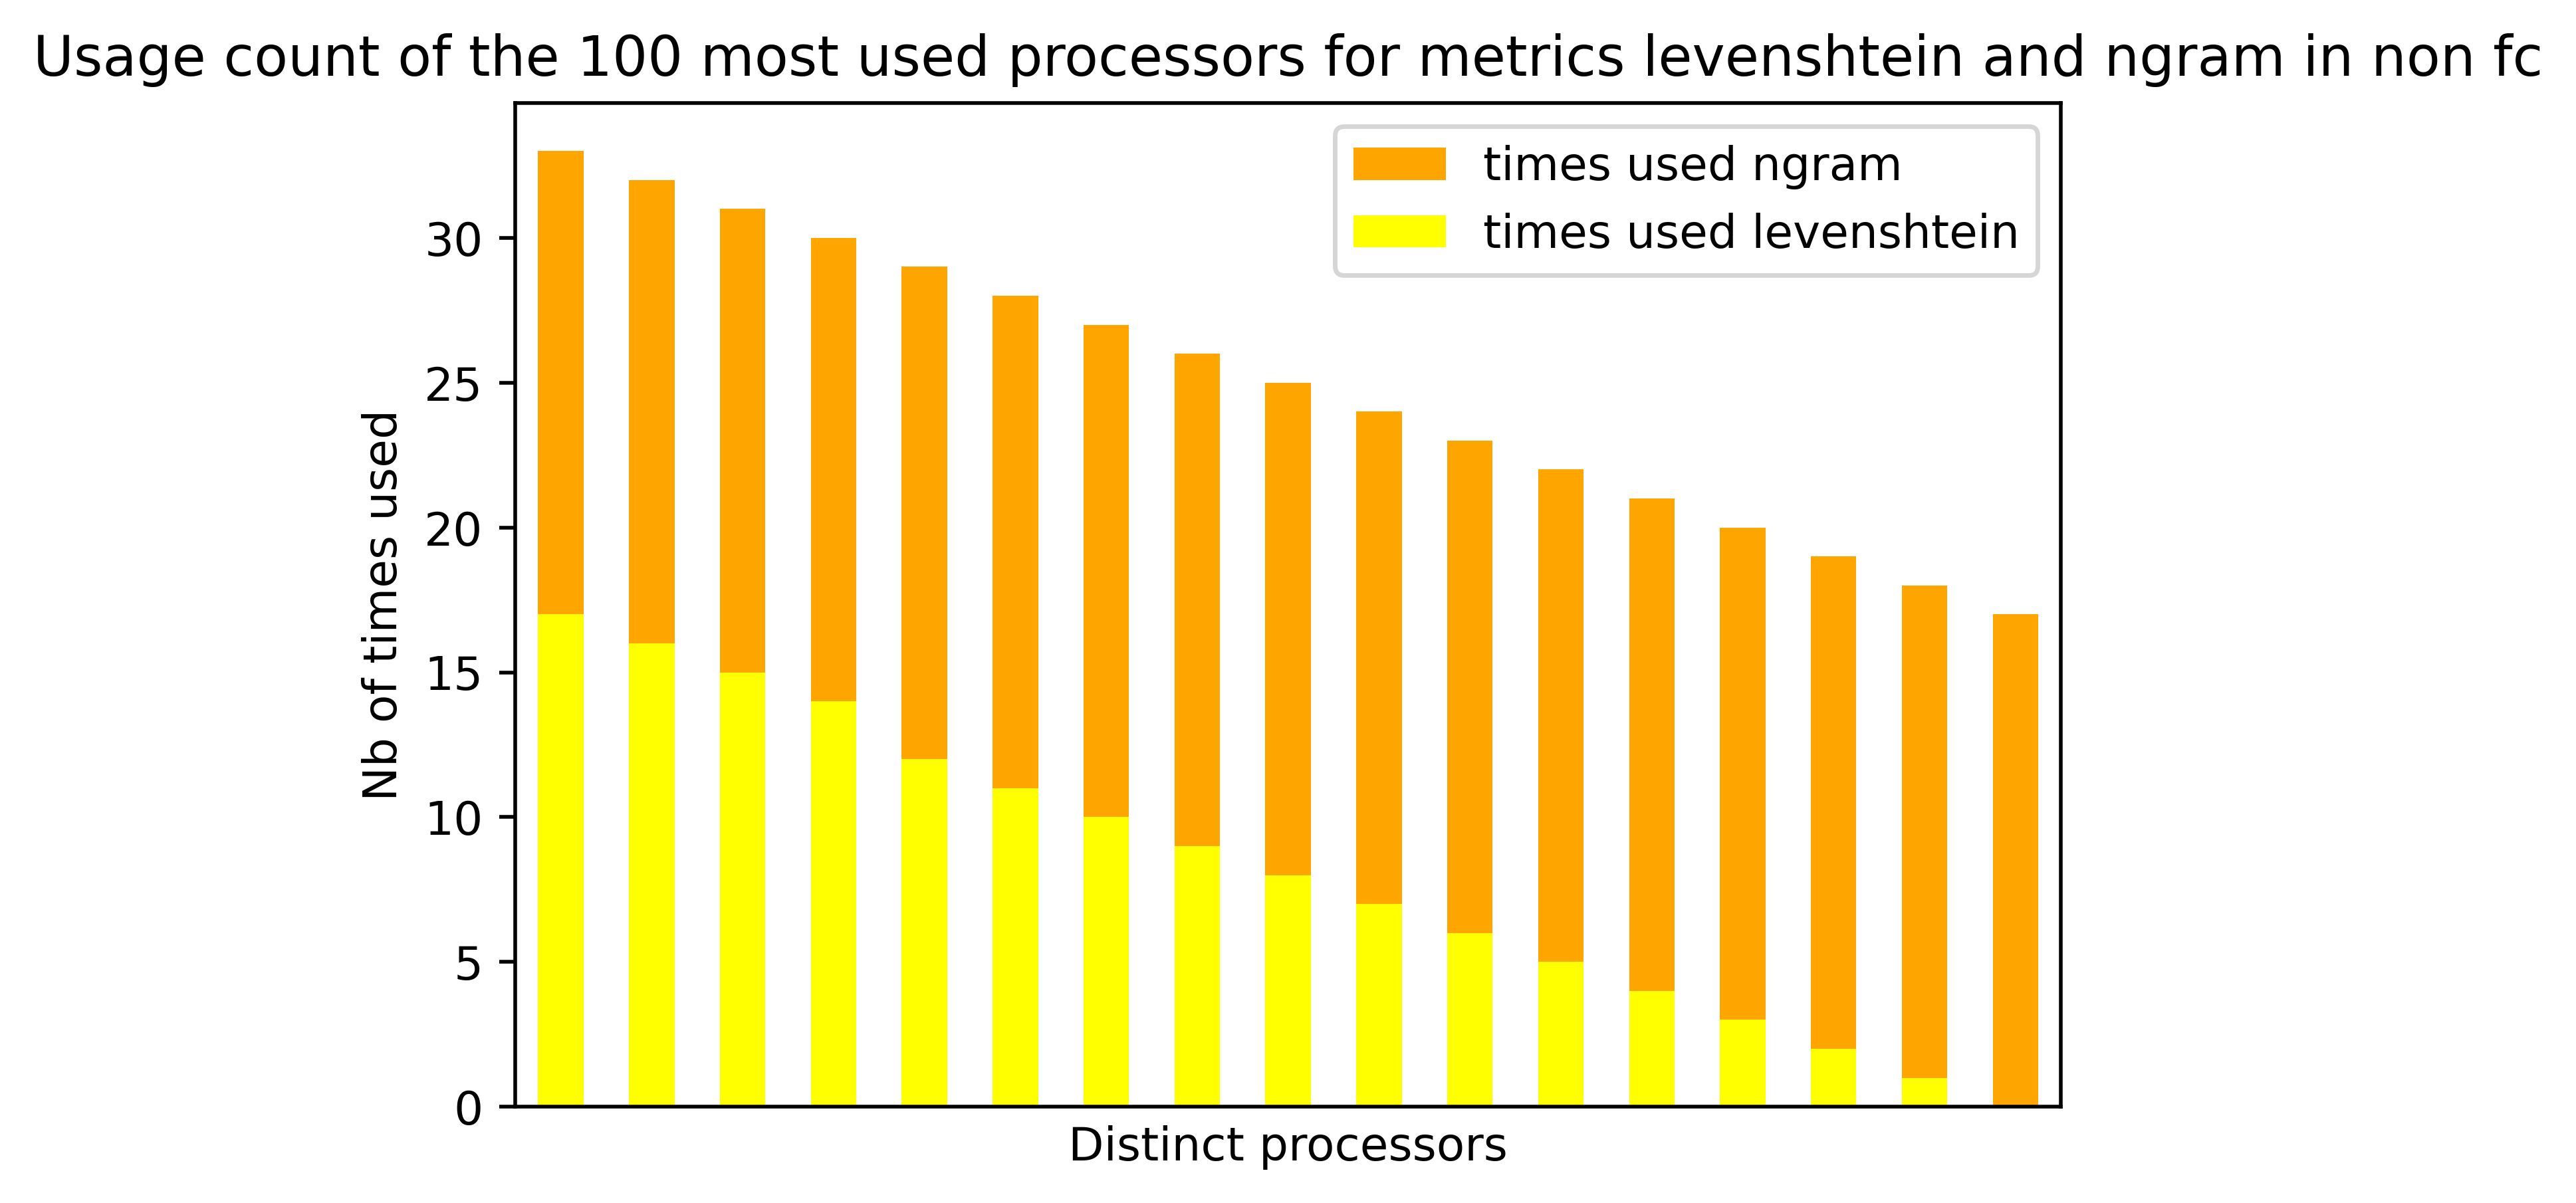

In [161]:
display_fig_stats_process_nfc(df_nf_non_nfc_ngram,df_nf_lev_non_nfc, 100, "non fc")

In [164]:
def display_fig_stats_process_nfc_non_nfc(df_sim, df_sim_p, nb_proc):
    df_sim_s = df_sim.sort_values(by=["nb_reuse"], ascending = False).head(nb_proc)
    df_sim_l = df_sim_p.sort_values(by=["nb_reuse"], ascending = False).head(nb_proc)
    ax = df_sim_s.plot(x='Unnamed: 0', y="nb_reuse", kind="bar", label = "times used nfc", color = "orange")
    df_sim_l.plot(x='Unnamed: 0', y="nb_reuse", ax=ax ,  kind="bar", color = "yellow", label = "times used non nfc")
    ax.set_title('Usage count of the '+str(nb_proc)+' most used processors for the levenshtein by non nfcore and nfcore proc') 
    plt.xticks([])
    #ax.set_xticklabels(l, rotation=80, size=5)
    ax.set_xlabel("Distinct processors")
    ax.set_ylabel("Nb of times used")
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return ax

<AxesSubplot:title={'center':'Usage count of the 100 most used processors for the levenshtein by non nfcore and nfcore proc'}, xlabel='Distinct processors', ylabel='Nb of times used'>

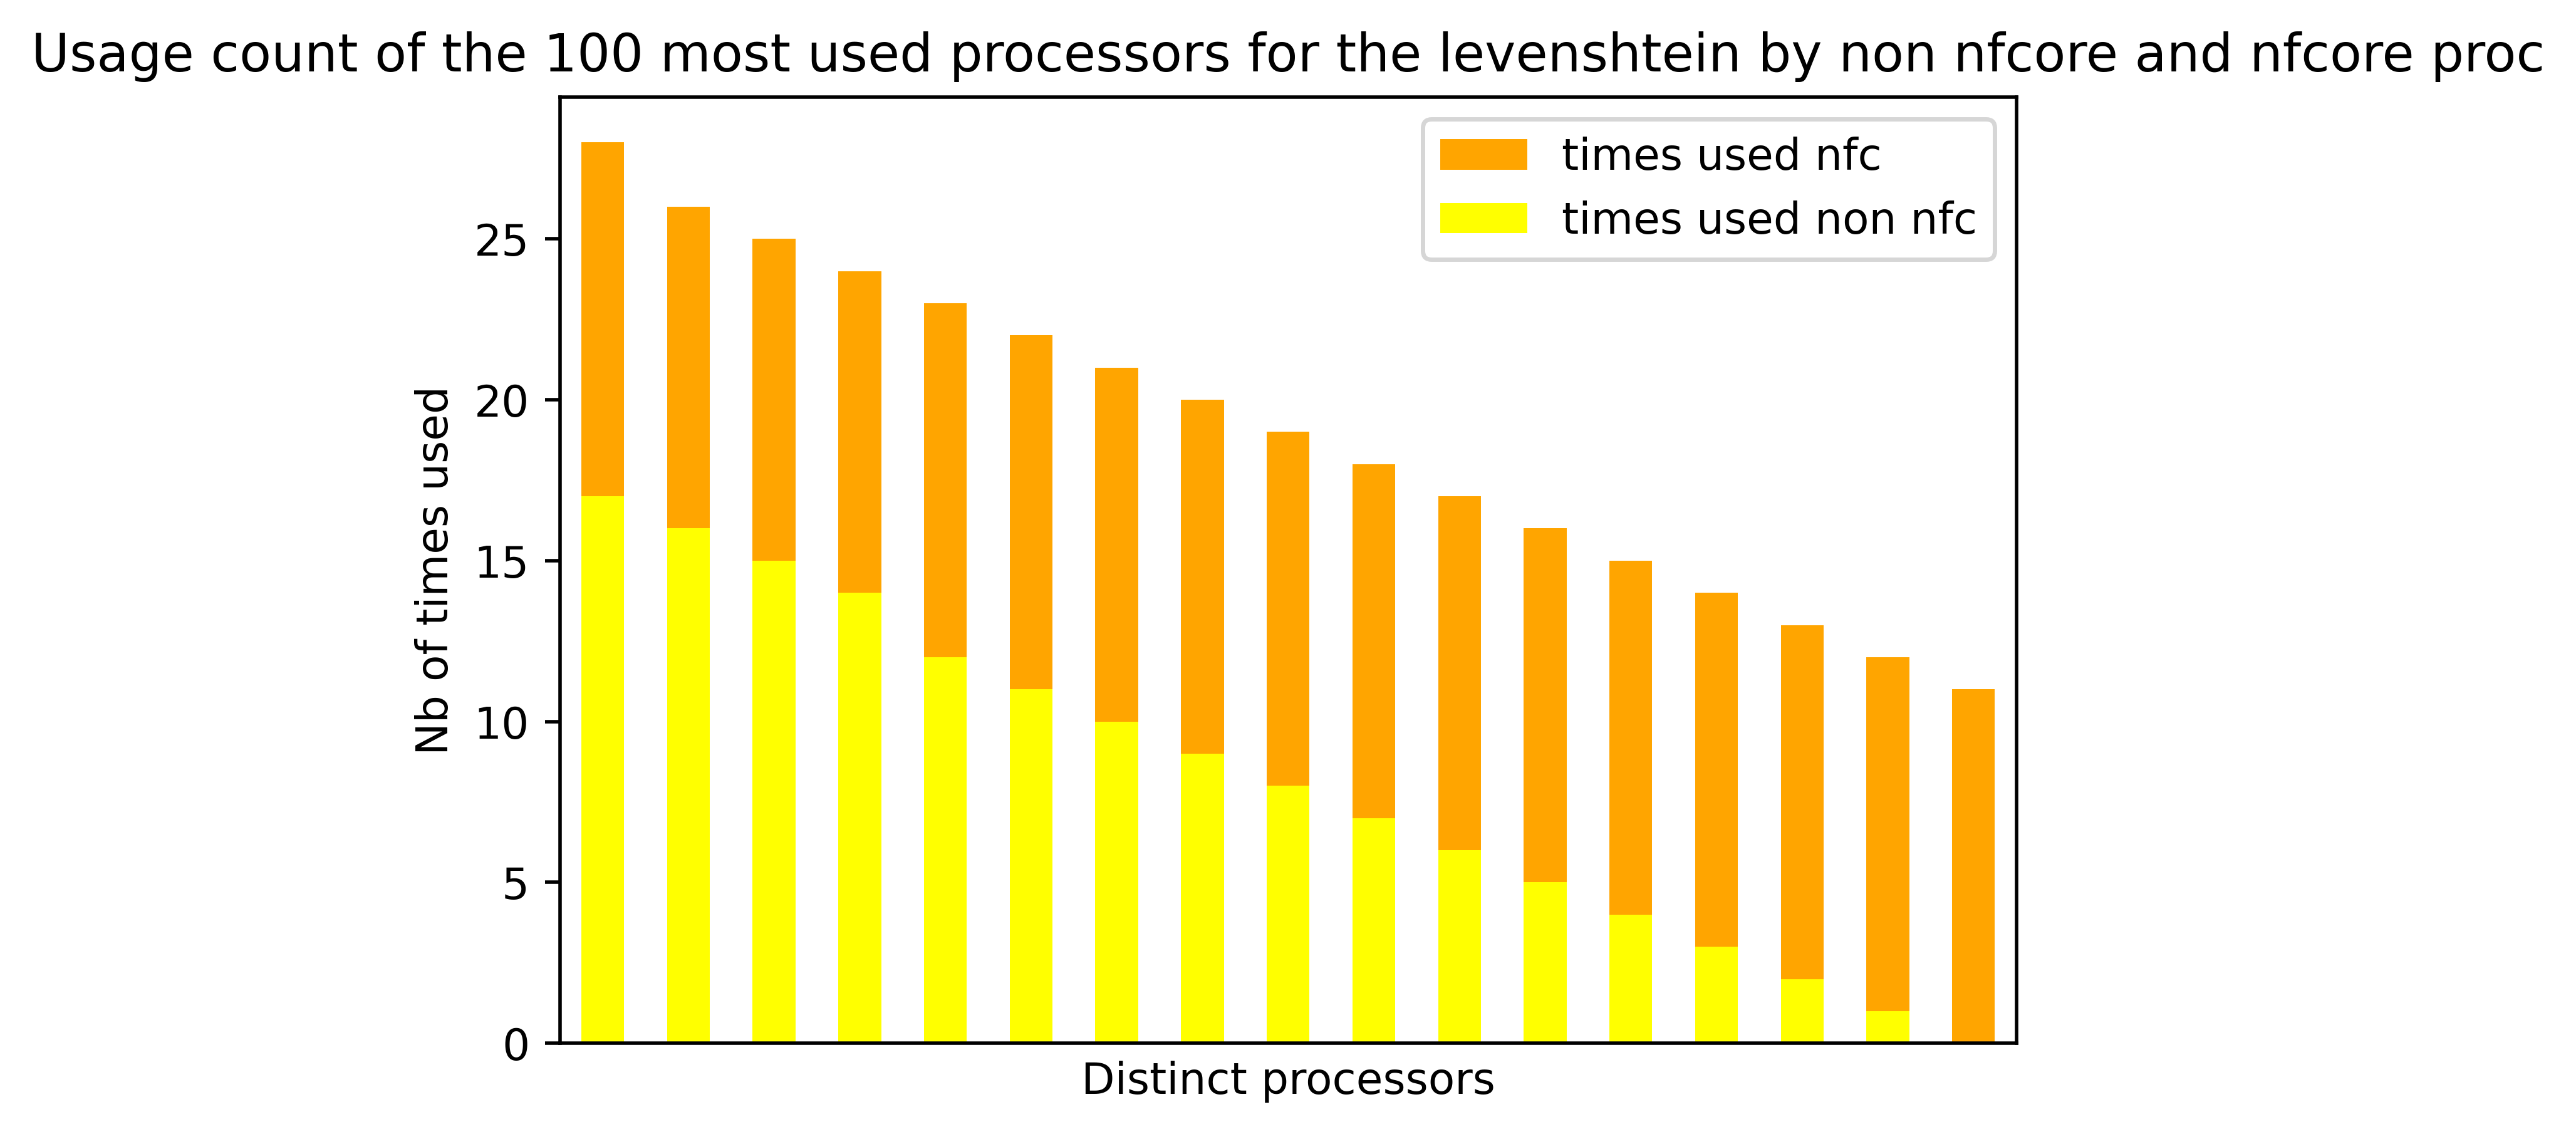

In [166]:
display_fig_stats_process_nfc_non_nfc(df_nf_lev_nfc,df_nf_lev_non_nfc, 100)